# Усовершенствование работы рекуррентной нейронной сети для ограниченного набора обучающих данных на примере прогнозирования медианной заработной платы женщин (анализ временного ряда за последние 50 лет).

In [2]:
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten, Dropout,  SimpleRNN, SimpleRNNCell
from tensorflow.keras.models import Model, Sequential
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae

2023-10-11 00:59:48.423289: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-11 00:59:48.424553: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-11 00:59:48.452271: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-11 00:59:48.452832: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 00:59:48.975932: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [3]:
df = pd.read_csv('gender_wage_gap.csv')

In [4]:
df.columns

Index(['year', 'men_median', 'men_average', 'women_median', 'women_average',
       'white_men_median', 'white_men_average', 'black_men_median',
       'black_men_average', 'hispanic_men_median', 'hispanic_men_average',
       'white_women_median', 'white_women_average', 'black_women_median',
       'black_women_average', 'hispanic_women_median',
       'hispanic_women_average'],
      dtype='object')

In [5]:
df = df[['year', 'men_median', 'men_average', 'women_median', 'women_average']]

In [6]:
df = df.sort_values(['year'])

In [7]:
df.head(10)

,year,men_median,men_average,women_median,women_average
49,1973,24.00,26.96,15.10,17.31
48,1974,23.70,26.48,14.88,17.01
47,1975,24.08,26.46,15.08,17.24
46,1976,23.69,26.73,15.22,17.64
45,1977,23.92,26.73,15.11,17.44
44,1978,24.27,26.86,15.17,17.50
43,1979,24.11,27.08,15.28,17.73
42,1980,23.88,26.54,15.21,17.54
41,1981,23.38,26.38,15.29,17.55
40,1982,23.39,26.60,15.12,17.85


Спрогнозируем медианную заработную плату женщин на базе анализа временного ряда по признакам средняя и медианная заработная плата мужчин и женщин, возьмем период предыдущие 10 лет.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 49 to 0
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           50 non-null     int64  
 1   men_median     50 non-null     float64
 2   men_average    50 non-null     float64
 3   women_median   50 non-null     float64
 4   women_average  50 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 2.3 KB


/home/ekaterina/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ekaterina/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='year', ylabel='women_median'>

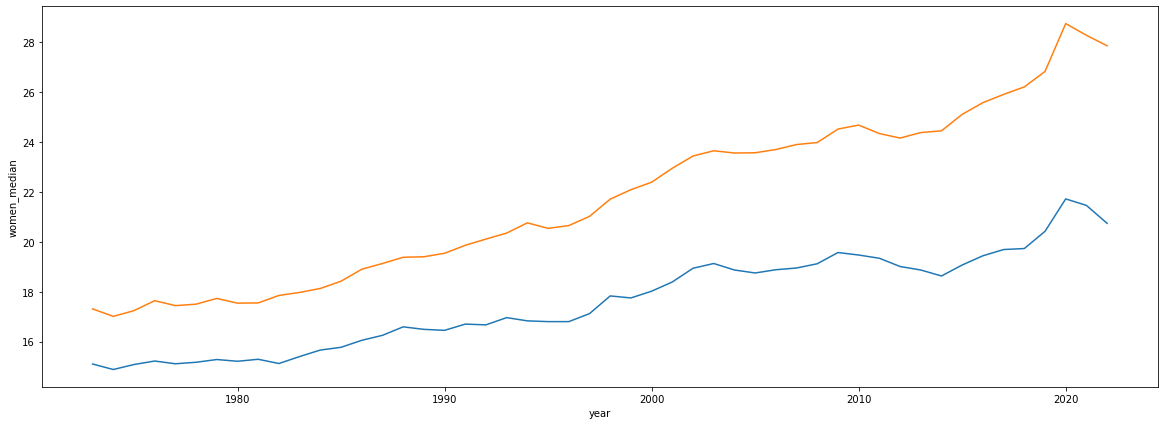

In [9]:
#посмотрим графики изменения средней и медианной заработной платы
from pylab import rcParams
rcParams['figure.figsize'] = 20,7
sns.lineplot(df['year'], df['women_median'])
sns.lineplot(df['year'], df['women_average'])

In [291]:
df['year'].unique()

array([1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2020, 2021, 2022])

In [292]:
x_len = 10 #анализируем 10 точек предыдущего периода
for i in range(1, x_len+1):
    df['women_median'+str(i)+'years_back'] = df['women_median'].shift(i, axis = 0)
    df['women_average'+str(i)+'years_back'] = df['women_average'].shift(i, axis = 0)
    df['men_median'+str(i)+'years_back'] = df['men_median'].shift(i, axis = 0)
    df['men_average'+str(i)+'years_back'] = df['men_average'].shift(i, axis = 0)    
    df['year'+str(i)+'years_back'] = df['year'].shift(i, axis = 0)

In [293]:
df.head(10)

,year,men_median,men_average,women_median,women_average,women_median1years_back,women_average1years_back,men_median1years_back,men_average1years_back,year1years_back,...,women_median9years_back,women_average9years_back,men_median9years_back,men_average9years_back,year9years_back,women_median10years_back,women_average10years_back,men_median10years_back,men_average10years_back,year10years_back
49,1973,24.00,26.96,15.10,17.31,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,1974,23.70,26.48,14.88,17.01,15.10,17.31,24.00,26.96,1973.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,1975,24.08,26.46,15.08,17.24,14.88,17.01,23.70,26.48,1974.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,1976,23.69,26.73,15.22,17.64,15.08,17.24,24.08,26.46,1975.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,1977,23.92,26.73,15.11,17.44,15.22,17.64,23.69,26.73,1976.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,1978,24.27,26.86,15.17,17.50,15.11,17.44,23.92,26.73,1977.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,1979,24.11,27.08,15.28,17.73,15.17,17.50,24.27,26.86,1978.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,1980,23.88,26.54,15.21,17.54,15.28,17.73,24.11,27.08,1979.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,1981,23.38,26.38,15.29,17.55,15.21,17.54,23.88,26.54,1980.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,1982,23.39,26.60,15.12,17.85,15.29,17.55,23.38,26.38,1981.0,...,15.1,17.31,24.0,26.96,1973.0,NaN,NaN,NaN,NaN,NaN


In [294]:
df.columns

Index(['year', 'men_median', 'men_average', 'women_median', 'women_average',
       'women_median1years_back', 'women_average1years_back',
       'men_median1years_back', 'men_average1years_back', 'year1years_back',
       'women_median2years_back', 'women_average2years_back',
       'men_median2years_back', 'men_average2years_back', 'year2years_back',
       'women_median3years_back', 'women_average3years_back',
       'men_median3years_back', 'men_average3years_back', 'year3years_back',
       'women_median4years_back', 'women_average4years_back',
       'men_median4years_back', 'men_average4years_back', 'year4years_back',
       'women_median5years_back', 'women_average5years_back',
       'men_median5years_back', 'men_average5years_back', 'year5years_back',
       'women_median6years_back', 'women_average6years_back',
       'men_median6years_back', 'men_average6years_back', 'year6years_back',
       'women_median7years_back', 'women_average7years_back',
       'men_median7years_ba

In [295]:
df_train = df.loc[df['year']<2018][x_len:]
df_train.shape

(35, 55)

In [296]:
df_test = df.loc[df['year']>=2018]

df_test.shape

(5, 55)

In [297]:
X_train = df_train[['year',
       'women_median1years_back', 'women_average1years_back',
       'men_median1years_back', 'men_average1years_back', 'year1years_back',
       'women_median2years_back', 'women_average2years_back',
       'men_median2years_back', 'men_average2years_back', 'year2years_back',
       'women_median3years_back', 'women_average3years_back',
       'men_median3years_back', 'men_average3years_back', 'year3years_back',
       'women_median4years_back', 'women_average4years_back',
       'men_median4years_back', 'men_average4years_back', 'year4years_back',
       'women_median5years_back', 'women_average5years_back',
       'men_median5years_back', 'men_average5years_back', 'year5years_back',
       'women_median6years_back', 'women_average6years_back',
       'men_median6years_back', 'men_average6years_back', 'year6years_back',
       'women_median7years_back', 'women_average7years_back',
       'men_median7years_back', 'men_average7years_back', 'year7years_back',
       'women_median8years_back', 'women_average8years_back',
       'men_median8years_back', 'men_average8years_back', 'year8years_back',
       'women_median9years_back', 'women_average9years_back',
       'men_median9years_back', 'men_average9years_back', 'year9years_back',
       'women_median10years_back', 'women_average10years_back',
       'men_median10years_back', 'men_average10years_back',
       'year10years_back']]
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled.shape

(35, 51)

In [298]:
X_train_scaled

array([[0.        , 0.        , 0.        , ..., 0.90217391, 0.19689119,
        0.        ],
       [0.02941176, 0.06292135, 0.01552393, ..., 0.79347826, 0.07253886,
        0.02941176],
       [0.05882353, 0.12134831, 0.03622251, ..., 0.93115942, 0.06735751,
        0.05882353],
       ...,
       [0.94117647, 0.78876404, 0.8538163 , ..., 0.48913043, 0.87305699,
        0.94117647],
       [0.97058824, 0.88764045, 0.93919793, ..., 0.59782609, 0.89378238,
        0.97058824],
       [1.        , 0.97078652, 1.        , ..., 0.63768116, 1.        ,
        1.        ]])

In [299]:
y_train = np.array(df_train['women_median'])

In [300]:
y_train.shape

(35,)

In [301]:
y_train

array([15.4 , 15.66, 15.77, 16.05, 16.25, 16.59, 16.49, 16.45, 16.7 ,
       16.67, 16.96, 16.83, 16.8 , 16.8 , 17.12, 17.83, 17.75, 18.02,
       18.39, 18.94, 19.13, 18.87, 18.75, 18.88, 18.95, 19.12, 19.57,
       19.47, 19.34, 19.01, 18.87, 18.63, 19.07, 19.44, 19.69])

In [302]:
X_test = df_test[['year',
       'women_median1years_back', 'women_average1years_back',
       'men_median1years_back', 'men_average1years_back', 'year1years_back',
       'women_median2years_back', 'women_average2years_back',
       'men_median2years_back', 'men_average2years_back', 'year2years_back',
       'women_median3years_back', 'women_average3years_back',
       'men_median3years_back', 'men_average3years_back', 'year3years_back',
       'women_median4years_back', 'women_average4years_back',
       'men_median4years_back', 'men_average4years_back', 'year4years_back',
       'women_median5years_back', 'women_average5years_back',
       'men_median5years_back', 'men_average5years_back', 'year5years_back',
       'women_median6years_back', 'women_average6years_back',
       'men_median6years_back', 'men_average6years_back', 'year6years_back',
       'women_median7years_back', 'women_average7years_back',
       'men_median7years_back', 'men_average7years_back', 'year7years_back',
       'women_median8years_back', 'women_average8years_back',
       'men_median8years_back', 'men_average8years_back', 'year8years_back',
       'women_median9years_back', 'women_average9years_back',
       'men_median9years_back', 'men_average9years_back', 'year9years_back',
       'women_median10years_back', 'women_average10years_back',
       'men_median10years_back', 'men_average10years_back',
       'year10years_back']]
X_test_scaled = scaler.transform(X_test)
X_test_scaled.shape

(5, 51)

In [303]:
y_test = np.array(df_test['women_median'])

In [304]:
y_test

array([19.73, 20.42, 21.72, 21.46, 20.74])

# Посмотрим, как с этой задачей справляется XGboost

In [305]:
XGBreg = XGBRegressor(random_state=21)

In [306]:
params = {'n_estimators':[500, 1000, 1500, 2000, 5000],
          'max_depth':[3, 5, 7], 'learning_rate':[0.01,0.1, 0.5, 1]}

In [307]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [308]:
rs = GridSearchCV(XGBreg, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X_train, y_train)

/home/ekaterina/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/ekaterina/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/ekaterina/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/ekaterina/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"

/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1261, i

/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1261, i

/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1261, i

/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1261, i

/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1261, i

/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1261, i

/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1261, i

/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1261, i

/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1261, i

/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1261, i

/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1261, i

/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1261, i

/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1261, i

/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1261, i

/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1261, i

/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1261, i

/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1261, i

/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1261, i

/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1261, i

/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1261, i

/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1261, i

/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1261, i

/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1261, i

/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1261, i

/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1261, i

/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1261, i

/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1261, i

/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1261, i

GridSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    inte...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                         

In [309]:
rs.best_params_

{'learning_rate': 1, 'max_depth': 3, 'n_estimators': 500}

In [310]:
XGBreg = XGBRegressor(n_estimators=500, max_depth=3, eta=1, random_state=21)

XGBreg.fit(X_train, y_train)

y_train_pred = XGBreg.predict(X_train)
y_test_pred = XGBreg.predict(X_test)

print(f'mse_test {mse(y_test, y_test_pred)}, mae_test {mae(y_test, y_test_pred)}')

mse_test 2.754596856556042, mae_test 1.4506931915283203


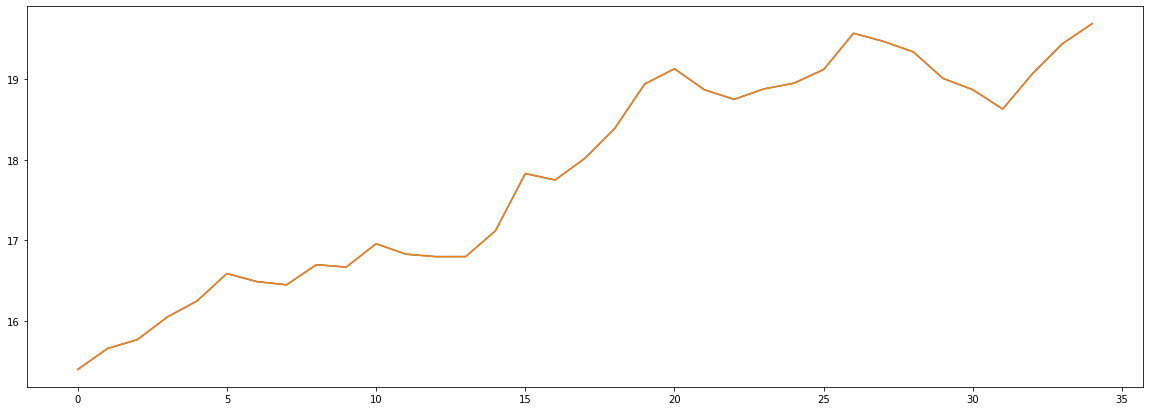

In [311]:
plt.plot(np.array(y_train))
plt.plot(y_train_pred)

На трейне модель XGboostRegressor очень хорошо обучилась

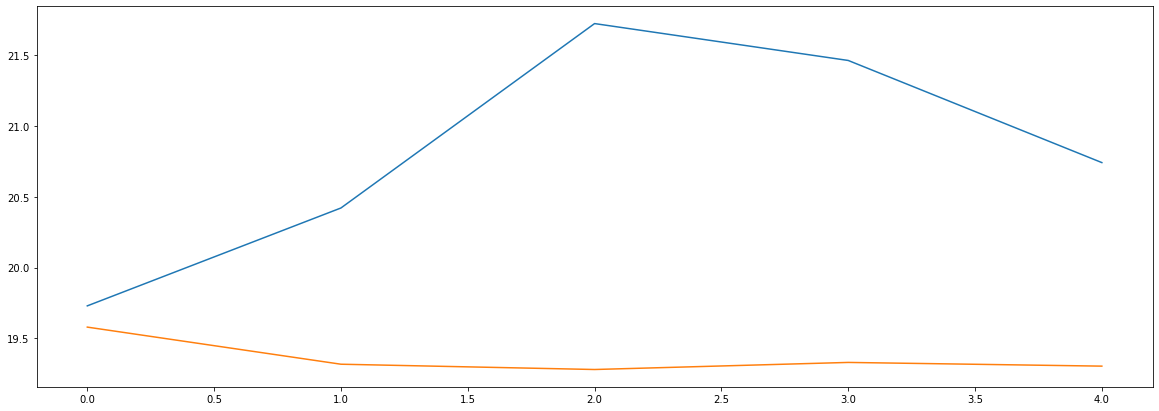

In [312]:
plt.plot(np.array(y_test))
plt.plot(y_test_pred)

На тесте модель XGboostRegressor не уловила тренд (присутствует переобучение), требуются дополнительные настройки параметров

# Полносвязная сеть

In [313]:
tf.random.set_seed(1)
inputs = Input(shape=(51))
hidden_layer_1 = Dense(128, activation='linear')(inputs) #linear работает лучше для данной сети, чем elu
outputs = Dense(1)(hidden_layer_1)

model = Model(inputs, outputs)

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history = model.fit(X_train, 
                    y_train, 
                    epochs=5000,
                    batch_size = 1,
                    validation_split=0.1, 
                    verbose=2)

Epoch 1/5000
31/31 - 0s - loss: 53519.5000 - mae: 130.6255 - val_loss: 4090.1025 - val_mae: 63.9486 - 267ms/epoch - 9ms/step
Epoch 2/5000
31/31 - 0s - loss: 35772.6953 - mae: 177.1655 - val_loss: 39226.8047 - val_mae: 198.0564 - 38ms/epoch - 1ms/step
Epoch 3/5000
31/31 - 0s - loss: 37194.0391 - mae: 191.3554 - val_loss: 37219.4414 - val_mae: 192.9212 - 37ms/epoch - 1ms/step
Epoch 4/5000
31/31 - 0s - loss: 35418.3398 - mae: 187.5055 - val_loss: 29409.8887 - val_mae: 171.4918 - 38ms/epoch - 1ms/step
Epoch 5/5000
31/31 - 0s - loss: 32705.7051 - mae: 180.1860 - val_loss: 41106.7812 - val_mae: 202.7459 - 34ms/epoch - 1ms/step
Epoch 6/5000
31/31 - 0s - loss: 32988.7891 - mae: 180.7060 - val_loss: 26675.0000 - val_mae: 163.3234 - 36ms/epoch - 1ms/step
Epoch 7/5000
31/31 - 0s - loss: 29556.3613 - mae: 171.6754 - val_loss: 35669.2891 - val_mae: 188.8609 - 36ms/epoch - 1ms/step
Epoch 8/5000
31/31 - 0s - loss: 30525.4043 - mae: 173.9416 - val_loss: 26037.9062 - val_mae: 161.3612 - 38ms/epoch - 1m

Epoch 66/5000
31/31 - 0s - loss: 8416.7373 - mae: 91.3304 - val_loss: 8980.0791 - val_mae: 94.7616 - 33ms/epoch - 1ms/step
Epoch 67/5000
31/31 - 0s - loss: 8189.2559 - mae: 90.3439 - val_loss: 8289.4688 - val_mae: 91.0440 - 33ms/epoch - 1ms/step
Epoch 68/5000
31/31 - 0s - loss: 8260.9385 - mae: 90.7236 - val_loss: 10634.5498 - val_mae: 103.1225 - 32ms/epoch - 1ms/step
Epoch 69/5000
31/31 - 0s - loss: 8206.6074 - mae: 90.2715 - val_loss: 7287.4268 - val_mae: 85.3638 - 33ms/epoch - 1ms/step
Epoch 70/5000
31/31 - 0s - loss: 7634.1021 - mae: 87.3004 - val_loss: 7783.2588 - val_mae: 88.2211 - 33ms/epoch - 1ms/step
Epoch 71/5000
31/31 - 0s - loss: 7634.5952 - mae: 87.1705 - val_loss: 8306.0352 - val_mae: 91.1350 - 33ms/epoch - 1ms/step
Epoch 72/5000
31/31 - 0s - loss: 7428.2227 - mae: 85.9143 - val_loss: 8988.2051 - val_mae: 94.8046 - 33ms/epoch - 1ms/step
Epoch 73/5000
31/31 - 0s - loss: 7413.7827 - mae: 85.9522 - val_loss: 7471.3115 - val_mae: 86.4344 - 32ms/epoch - 1ms/step
Epoch 74/5000


Epoch 133/5000
31/31 - 0s - loss: 1593.0658 - mae: 39.5282 - val_loss: 756.8394 - val_mae: 27.5076 - 32ms/epoch - 1ms/step
Epoch 134/5000
31/31 - 0s - loss: 1495.5107 - mae: 37.4276 - val_loss: 1229.9929 - val_mae: 35.0693 - 33ms/epoch - 1ms/step
Epoch 135/5000
31/31 - 0s - loss: 1411.0663 - mae: 36.7293 - val_loss: 2093.5610 - val_mae: 45.7535 - 33ms/epoch - 1ms/step
Epoch 136/5000
31/31 - 0s - loss: 1356.0789 - mae: 36.4561 - val_loss: 1408.4471 - val_mae: 37.5276 - 33ms/epoch - 1ms/step
Epoch 137/5000
31/31 - 0s - loss: 1388.5083 - mae: 36.4615 - val_loss: 481.3908 - val_mae: 21.9371 - 34ms/epoch - 1ms/step
Epoch 138/5000
31/31 - 0s - loss: 1442.1437 - mae: 37.2545 - val_loss: 1217.4424 - val_mae: 34.8901 - 33ms/epoch - 1ms/step
Epoch 139/5000
31/31 - 0s - loss: 1198.1558 - mae: 33.6311 - val_loss: 1603.8475 - val_mae: 40.0461 - 34ms/epoch - 1ms/step
Epoch 140/5000
31/31 - 0s - loss: 1190.3516 - mae: 33.8072 - val_loss: 1350.4709 - val_mae: 36.7471 - 34ms/epoch - 1ms/step
Epoch 141/

31/31 - 0s - loss: 259.4500 - mae: 12.4168 - val_loss: 139.5098 - val_mae: 11.8048 - 32ms/epoch - 1ms/step
Epoch 201/5000
31/31 - 0s - loss: 174.4029 - mae: 9.9544 - val_loss: 0.1564 - val_mae: 0.3561 - 34ms/epoch - 1ms/step
Epoch 202/5000
31/31 - 0s - loss: 240.9443 - mae: 11.5416 - val_loss: 115.0577 - val_mae: 10.7196 - 31ms/epoch - 1ms/step
Epoch 203/5000
31/31 - 0s - loss: 167.1726 - mae: 9.7870 - val_loss: 274.1435 - val_mae: 16.5525 - 33ms/epoch - 1ms/step
Epoch 204/5000
31/31 - 0s - loss: 218.8835 - mae: 12.7711 - val_loss: 15.1087 - val_mae: 3.8672 - 31ms/epoch - 1ms/step
Epoch 205/5000
31/31 - 0s - loss: 185.6738 - mae: 12.8173 - val_loss: 454.5124 - val_mae: 21.3152 - 34ms/epoch - 1ms/step
Epoch 206/5000
31/31 - 0s - loss: 169.9216 - mae: 10.0925 - val_loss: 3.0750 - val_mae: 1.7078 - 31ms/epoch - 1ms/step
Epoch 207/5000
31/31 - 0s - loss: 137.5623 - mae: 9.7096 - val_loss: 697.9440 - val_mae: 26.4153 - 34ms/epoch - 1ms/step
Epoch 208/5000
31/31 - 0s - loss: 188.9465 - mae: 

31/31 - 0s - loss: 24.5723 - mae: 4.3398 - val_loss: 0.2196 - val_mae: 0.3677 - 34ms/epoch - 1ms/step
Epoch 270/5000
31/31 - 0s - loss: 44.2455 - mae: 4.1207 - val_loss: 10.5114 - val_mae: 3.2179 - 32ms/epoch - 1ms/step
Epoch 271/5000
31/31 - 0s - loss: 21.7859 - mae: 3.9716 - val_loss: 8.5755 - val_mae: 2.9015 - 33ms/epoch - 1ms/step
Epoch 272/5000
31/31 - 0s - loss: 25.5389 - mae: 4.0024 - val_loss: 55.8531 - val_mae: 7.4626 - 32ms/epoch - 1ms/step
Epoch 273/5000
31/31 - 0s - loss: 43.7871 - mae: 4.5354 - val_loss: 2.9325 - val_mae: 1.6651 - 33ms/epoch - 1ms/step
Epoch 274/5000
31/31 - 0s - loss: 11.0021 - mae: 2.6406 - val_loss: 7.1362 - val_mae: 2.6410 - 32ms/epoch - 1ms/step
Epoch 275/5000
31/31 - 0s - loss: 34.8496 - mae: 4.4159 - val_loss: 4.6857 - val_mae: 2.1280 - 33ms/epoch - 1ms/step
Epoch 276/5000
31/31 - 0s - loss: 24.9489 - mae: 3.6334 - val_loss: 5.3144 - val_mae: 2.2704 - 35ms/epoch - 1ms/step
Epoch 277/5000
31/31 - 0s - loss: 45.1288 - mae: 4.4201 - val_loss: 3.9779 - 

31/31 - 0s - loss: 32.6084 - mae: 3.4778 - val_loss: 32.8791 - val_mae: 5.7207 - 34ms/epoch - 1ms/step
Epoch 340/5000
31/31 - 0s - loss: 11.8681 - mae: 2.8500 - val_loss: 114.4941 - val_mae: 10.6941 - 36ms/epoch - 1ms/step
Epoch 341/5000
31/31 - 0s - loss: 11.1135 - mae: 2.2953 - val_loss: 5.1931 - val_mae: 2.2456 - 34ms/epoch - 1ms/step
Epoch 342/5000
31/31 - 0s - loss: 27.2346 - mae: 3.4602 - val_loss: 4.6757 - val_mae: 2.1268 - 32ms/epoch - 1ms/step
Epoch 343/5000
31/31 - 0s - loss: 6.2536 - mae: 2.0370 - val_loss: 0.1552 - val_mae: 0.3508 - 34ms/epoch - 1ms/step
Epoch 344/5000
31/31 - 0s - loss: 8.0339 - mae: 2.4796 - val_loss: 21.9049 - val_mae: 4.6633 - 36ms/epoch - 1ms/step
Epoch 345/5000
31/31 - 0s - loss: 33.3385 - mae: 3.7562 - val_loss: 2.0361 - val_mae: 1.3741 - 33ms/epoch - 1ms/step
Epoch 346/5000
31/31 - 0s - loss: 11.5642 - mae: 2.4912 - val_loss: 30.8358 - val_mae: 5.5401 - 33ms/epoch - 1ms/step
Epoch 347/5000
31/31 - 0s - loss: 13.0012 - mae: 2.4670 - val_loss: 0.2844 

Epoch 410/5000
31/31 - 0s - loss: 15.3164 - mae: 2.3694 - val_loss: 5.9629 - val_mae: 2.4113 - 36ms/epoch - 1ms/step
Epoch 411/5000
31/31 - 0s - loss: 3.2322 - mae: 1.4722 - val_loss: 3.3688 - val_mae: 1.7945 - 32ms/epoch - 1ms/step
Epoch 412/5000
31/31 - 0s - loss: 19.6403 - mae: 2.9073 - val_loss: 0.1832 - val_mae: 0.3387 - 32ms/epoch - 1ms/step
Epoch 413/5000
31/31 - 0s - loss: 2.4708 - mae: 1.3675 - val_loss: 2.3667 - val_mae: 1.4884 - 32ms/epoch - 1ms/step
Epoch 414/5000
31/31 - 0s - loss: 5.4770 - mae: 1.7204 - val_loss: 9.1040 - val_mae: 2.9929 - 33ms/epoch - 1ms/step
Epoch 415/5000
31/31 - 0s - loss: 15.9631 - mae: 2.8158 - val_loss: 5.9850 - val_mae: 2.4155 - 33ms/epoch - 1ms/step
Epoch 416/5000
31/31 - 0s - loss: 2.8312 - mae: 1.4149 - val_loss: 0.2969 - val_mae: 0.4702 - 33ms/epoch - 1ms/step
Epoch 417/5000
31/31 - 0s - loss: 9.3530 - mae: 2.3212 - val_loss: 3.4021 - val_mae: 1.8045 - 35ms/epoch - 1ms/step
Epoch 418/5000
31/31 - 0s - loss: 5.5768 - mae: 1.7946 - val_loss: 0.

Epoch 481/5000
31/31 - 0s - loss: 2.9568 - mae: 1.5038 - val_loss: 4.5051 - val_mae: 2.0870 - 31ms/epoch - 1ms/step
Epoch 482/5000
31/31 - 0s - loss: 8.2547 - mae: 1.9939 - val_loss: 9.7761 - val_mae: 3.1041 - 33ms/epoch - 1ms/step
Epoch 483/5000
31/31 - 0s - loss: 8.6615 - mae: 2.1145 - val_loss: 0.3505 - val_mae: 0.5035 - 34ms/epoch - 1ms/step
Epoch 484/5000
31/31 - 0s - loss: 2.5332 - mae: 1.3156 - val_loss: 6.8093 - val_mae: 2.5815 - 33ms/epoch - 1ms/step
Epoch 485/5000
31/31 - 0s - loss: 21.9552 - mae: 2.6440 - val_loss: 3.5159 - val_mae: 1.8359 - 34ms/epoch - 1ms/step
Epoch 486/5000
31/31 - 0s - loss: 5.7861 - mae: 2.0485 - val_loss: 8.1312 - val_mae: 2.8254 - 34ms/epoch - 1ms/step
Epoch 487/5000
31/31 - 0s - loss: 3.8459 - mae: 1.4913 - val_loss: 3.5606 - val_mae: 1.8476 - 32ms/epoch - 1ms/step
Epoch 488/5000
31/31 - 0s - loss: 20.2491 - mae: 2.7248 - val_loss: 5.1025 - val_mae: 2.2259 - 34ms/epoch - 1ms/step
Epoch 489/5000
31/31 - 0s - loss: 2.4156 - mae: 1.2114 - val_loss: 1.3

Epoch 552/5000
31/31 - 0s - loss: 2.7796 - mae: 1.4679 - val_loss: 1.9245 - val_mae: 1.3386 - 41ms/epoch - 1ms/step
Epoch 553/5000
31/31 - 0s - loss: 18.8126 - mae: 2.5547 - val_loss: 5.0184 - val_mae: 2.2106 - 37ms/epoch - 1ms/step
Epoch 554/5000
31/31 - 0s - loss: 1.9827 - mae: 1.1641 - val_loss: 1.5627 - val_mae: 1.1934 - 36ms/epoch - 1ms/step
Epoch 555/5000
31/31 - 0s - loss: 7.9212 - mae: 1.9540 - val_loss: 3.9526 - val_mae: 1.9532 - 37ms/epoch - 1ms/step
Epoch 556/5000
31/31 - 0s - loss: 18.6681 - mae: 2.5113 - val_loss: 2.3149 - val_mae: 1.4734 - 37ms/epoch - 1ms/step
Epoch 557/5000
31/31 - 0s - loss: 1.8686 - mae: 0.9568 - val_loss: 0.2714 - val_mae: 0.4029 - 38ms/epoch - 1ms/step
Epoch 558/5000
31/31 - 0s - loss: 17.6783 - mae: 2.5777 - val_loss: 5.5957 - val_mae: 2.3345 - 40ms/epoch - 1ms/step
Epoch 559/5000
31/31 - 0s - loss: 2.0596 - mae: 1.1769 - val_loss: 2.5917 - val_mae: 1.5664 - 49ms/epoch - 2ms/step
Epoch 560/5000
31/31 - 0s - loss: 9.1652 - mae: 2.1064 - val_loss: 4.

Epoch 623/5000
31/31 - 0s - loss: 17.4704 - mae: 2.1134 - val_loss: 3.5001 - val_mae: 1.8362 - 35ms/epoch - 1ms/step
Epoch 624/5000
31/31 - 0s - loss: 2.1475 - mae: 1.0584 - val_loss: 12.8611 - val_mae: 3.5673 - 33ms/epoch - 1ms/step
Epoch 625/5000
31/31 - 0s - loss: 4.5488 - mae: 1.6500 - val_loss: 1.8242 - val_mae: 1.2999 - 33ms/epoch - 1ms/step
Epoch 626/5000
31/31 - 0s - loss: 14.4012 - mae: 2.0724 - val_loss: 3.4719 - val_mae: 1.8231 - 35ms/epoch - 1ms/step
Epoch 627/5000
31/31 - 0s - loss: 2.6834 - mae: 1.2609 - val_loss: 0.1920 - val_mae: 0.3367 - 34ms/epoch - 1ms/step
Epoch 628/5000
31/31 - 0s - loss: 10.7012 - mae: 2.1756 - val_loss: 0.1406 - val_mae: 0.3228 - 36ms/epoch - 1ms/step
Epoch 629/5000
31/31 - 0s - loss: 2.1646 - mae: 1.2385 - val_loss: 0.1279 - val_mae: 0.3122 - 32ms/epoch - 1ms/step
Epoch 630/5000
31/31 - 0s - loss: 11.3510 - mae: 2.3961 - val_loss: 1.8726 - val_mae: 1.3188 - 35ms/epoch - 1ms/step
Epoch 631/5000
31/31 - 0s - loss: 8.0539 - mae: 2.0545 - val_loss: 

Epoch 694/5000
31/31 - 0s - loss: 4.3571 - mae: 1.7230 - val_loss: 0.6144 - val_mae: 0.6996 - 48ms/epoch - 2ms/step
Epoch 695/5000
31/31 - 0s - loss: 11.0772 - mae: 1.9744 - val_loss: 19.3830 - val_mae: 4.3889 - 36ms/epoch - 1ms/step
Epoch 696/5000
31/31 - 0s - loss: 2.8112 - mae: 1.3221 - val_loss: 0.2178 - val_mae: 0.3595 - 38ms/epoch - 1ms/step
Epoch 697/5000
31/31 - 0s - loss: 20.0904 - mae: 2.1494 - val_loss: 2.7571 - val_mae: 1.6195 - 39ms/epoch - 1ms/step
Epoch 698/5000
31/31 - 0s - loss: 1.8207 - mae: 1.1036 - val_loss: 4.7908 - val_mae: 2.1588 - 37ms/epoch - 1ms/step
Epoch 699/5000
31/31 - 0s - loss: 3.6083 - mae: 1.5087 - val_loss: 6.7179 - val_mae: 2.5644 - 38ms/epoch - 1ms/step
Epoch 700/5000
31/31 - 0s - loss: 3.8909 - mae: 1.6353 - val_loss: 0.1547 - val_mae: 0.3439 - 40ms/epoch - 1ms/step
Epoch 701/5000
31/31 - 0s - loss: 16.2090 - mae: 2.3214 - val_loss: 0.4627 - val_mae: 0.5783 - 38ms/epoch - 1ms/step
Epoch 702/5000
31/31 - 0s - loss: 1.0457 - mae: 0.8312 - val_loss: 3

Epoch 765/5000
31/31 - 0s - loss: 16.5059 - mae: 2.2500 - val_loss: 1.5444 - val_mae: 1.1917 - 39ms/epoch - 1ms/step
Epoch 766/5000
31/31 - 0s - loss: 2.0337 - mae: 1.2617 - val_loss: 0.1634 - val_mae: 0.3198 - 38ms/epoch - 1ms/step
Epoch 767/5000
31/31 - 0s - loss: 5.5179 - mae: 1.5531 - val_loss: 0.8815 - val_mae: 0.8708 - 38ms/epoch - 1ms/step
Epoch 768/5000
31/31 - 0s - loss: 36.0199 - mae: 2.4164 - val_loss: 0.6330 - val_mae: 0.7142 - 37ms/epoch - 1ms/step
Epoch 769/5000
31/31 - 0s - loss: 1.6948 - mae: 1.0430 - val_loss: 1.0409 - val_mae: 0.9594 - 38ms/epoch - 1ms/step
Epoch 770/5000
31/31 - 0s - loss: 6.0267 - mae: 1.6817 - val_loss: 2.8189 - val_mae: 1.6407 - 38ms/epoch - 1ms/step
Epoch 771/5000
31/31 - 0s - loss: 3.0976 - mae: 1.4587 - val_loss: 0.9592 - val_mae: 0.9083 - 38ms/epoch - 1ms/step
Epoch 772/5000
31/31 - 0s - loss: 6.0837 - mae: 1.7175 - val_loss: 1.6409 - val_mae: 1.2327 - 37ms/epoch - 1ms/step
Epoch 773/5000
31/31 - 0s - loss: 13.0469 - mae: 2.0990 - val_loss: 4.

Epoch 836/5000
31/31 - 0s - loss: 3.2039 - mae: 1.2665 - val_loss: 0.1846 - val_mae: 0.3298 - 39ms/epoch - 1ms/step
Epoch 837/5000
31/31 - 0s - loss: 8.6050 - mae: 2.0289 - val_loss: 0.1166 - val_mae: 0.3002 - 38ms/epoch - 1ms/step
Epoch 838/5000
31/31 - 0s - loss: 1.9215 - mae: 1.0654 - val_loss: 0.2504 - val_mae: 0.4386 - 38ms/epoch - 1ms/step
Epoch 839/5000
31/31 - 0s - loss: 15.7297 - mae: 2.3012 - val_loss: 0.3887 - val_mae: 0.5136 - 39ms/epoch - 1ms/step
Epoch 840/5000
31/31 - 0s - loss: 7.6607 - mae: 1.6991 - val_loss: 1.8228 - val_mae: 1.3073 - 37ms/epoch - 1ms/step
Epoch 841/5000
31/31 - 0s - loss: 2.1869 - mae: 1.1167 - val_loss: 0.2893 - val_mae: 0.4637 - 36ms/epoch - 1ms/step
Epoch 842/5000
31/31 - 0s - loss: 9.0004 - mae: 1.9452 - val_loss: 0.7245 - val_mae: 0.7715 - 36ms/epoch - 1ms/step
Epoch 843/5000
31/31 - 0s - loss: 1.7659 - mae: 1.0845 - val_loss: 1.8041 - val_mae: 1.2890 - 37ms/epoch - 1ms/step
Epoch 844/5000
31/31 - 0s - loss: 10.7176 - mae: 2.0384 - val_loss: 2.4

Epoch 907/5000
31/31 - 0s - loss: 15.7772 - mae: 2.0865 - val_loss: 8.5060 - val_mae: 2.8941 - 40ms/epoch - 1ms/step
Epoch 908/5000
31/31 - 0s - loss: 1.9758 - mae: 1.1039 - val_loss: 21.8486 - val_mae: 4.6603 - 36ms/epoch - 1ms/step
Epoch 909/5000
31/31 - 0s - loss: 10.7000 - mae: 2.0722 - val_loss: 2.1710 - val_mae: 1.4337 - 37ms/epoch - 1ms/step
Epoch 910/5000
31/31 - 0s - loss: 11.9724 - mae: 1.9056 - val_loss: 0.3430 - val_mae: 0.4784 - 38ms/epoch - 1ms/step
Epoch 911/5000
31/31 - 0s - loss: 1.2129 - mae: 0.8737 - val_loss: 0.1257 - val_mae: 0.3008 - 39ms/epoch - 1ms/step
Epoch 912/5000
31/31 - 0s - loss: 13.0170 - mae: 2.1052 - val_loss: 1.1480 - val_mae: 1.0156 - 38ms/epoch - 1ms/step
Epoch 913/5000
31/31 - 0s - loss: 1.7867 - mae: 1.1110 - val_loss: 1.8366 - val_mae: 1.3113 - 37ms/epoch - 1ms/step
Epoch 914/5000
31/31 - 0s - loss: 11.8136 - mae: 2.3236 - val_loss: 2.8120 - val_mae: 1.6408 - 37ms/epoch - 1ms/step
Epoch 915/5000
31/31 - 0s - loss: 11.2269 - mae: 2.1170 - val_loss

Epoch 978/5000
31/31 - 0s - loss: 2.7604 - mae: 1.2058 - val_loss: 1.8969 - val_mae: 1.3354 - 47ms/epoch - 2ms/step
Epoch 979/5000
31/31 - 0s - loss: 1.0698 - mae: 0.8785 - val_loss: 0.7166 - val_mae: 0.7722 - 49ms/epoch - 2ms/step
Epoch 980/5000
31/31 - 0s - loss: 17.6011 - mae: 2.1491 - val_loss: 0.5704 - val_mae: 0.6774 - 44ms/epoch - 1ms/step
Epoch 981/5000
31/31 - 0s - loss: 1.5521 - mae: 1.0910 - val_loss: 2.8082 - val_mae: 1.6417 - 43ms/epoch - 1ms/step
Epoch 982/5000
31/31 - 0s - loss: 10.4027 - mae: 2.2188 - val_loss: 1.1513 - val_mae: 1.0174 - 45ms/epoch - 1ms/step
Epoch 983/5000
31/31 - 0s - loss: 14.1688 - mae: 2.2444 - val_loss: 0.2519 - val_mae: 0.4396 - 43ms/epoch - 1ms/step
Epoch 984/5000
31/31 - 0s - loss: 1.5174 - mae: 0.9720 - val_loss: 2.3769 - val_mae: 1.5038 - 48ms/epoch - 2ms/step
Epoch 985/5000
31/31 - 0s - loss: 10.1977 - mae: 1.7970 - val_loss: 0.1756 - val_mae: 0.3785 - 42ms/epoch - 1ms/step
Epoch 986/5000
31/31 - 0s - loss: 0.9621 - mae: 0.7786 - val_loss: 1

Epoch 1048/5000
31/31 - 0s - loss: 2.2438 - mae: 1.1787 - val_loss: 2.0491 - val_mae: 1.3915 - 38ms/epoch - 1ms/step
Epoch 1049/5000
31/31 - 0s - loss: 3.8971 - mae: 1.4244 - val_loss: 0.9855 - val_mae: 0.9314 - 37ms/epoch - 1ms/step
Epoch 1050/5000
31/31 - 0s - loss: 8.0415 - mae: 1.7723 - val_loss: 0.1908 - val_mae: 0.3310 - 34ms/epoch - 1ms/step
Epoch 1051/5000
31/31 - 0s - loss: 0.7451 - mae: 0.6957 - val_loss: 6.1210 - val_mae: 2.4483 - 37ms/epoch - 1ms/step
Epoch 1052/5000
31/31 - 0s - loss: 12.4273 - mae: 1.9094 - val_loss: 0.4147 - val_mae: 0.5522 - 37ms/epoch - 1ms/step
Epoch 1053/5000
31/31 - 0s - loss: 11.4990 - mae: 1.8836 - val_loss: 2.2282 - val_mae: 1.4559 - 36ms/epoch - 1ms/step
Epoch 1054/5000
31/31 - 0s - loss: 3.7067 - mae: 1.4948 - val_loss: 0.9188 - val_mae: 0.8940 - 36ms/epoch - 1ms/step
Epoch 1055/5000
31/31 - 0s - loss: 0.9170 - mae: 0.7724 - val_loss: 10.5418 - val_mae: 3.2309 - 36ms/epoch - 1ms/step
Epoch 1056/5000
31/31 - 0s - loss: 16.2167 - mae: 2.4431 - va

Epoch 1118/5000
31/31 - 0s - loss: 31.8026 - mae: 2.4874 - val_loss: 0.2508 - val_mae: 0.3762 - 37ms/epoch - 1ms/step
Epoch 1119/5000
31/31 - 0s - loss: 1.9477 - mae: 1.1658 - val_loss: 0.5029 - val_mae: 0.6217 - 38ms/epoch - 1ms/step
Epoch 1120/5000
31/31 - 0s - loss: 13.8177 - mae: 2.1871 - val_loss: 13.0611 - val_mae: 3.5972 - 37ms/epoch - 1ms/step
Epoch 1121/5000
31/31 - 0s - loss: 1.4593 - mae: 0.9206 - val_loss: 0.5429 - val_mae: 0.6555 - 46ms/epoch - 1ms/step
Epoch 1122/5000
31/31 - 0s - loss: 7.6819 - mae: 1.6111 - val_loss: 0.2414 - val_mae: 0.3736 - 38ms/epoch - 1ms/step
Epoch 1123/5000
31/31 - 0s - loss: 12.6704 - mae: 1.8837 - val_loss: 1.0495 - val_mae: 0.9710 - 37ms/epoch - 1ms/step
Epoch 1124/5000
31/31 - 0s - loss: 0.9526 - mae: 0.7284 - val_loss: 1.9627 - val_mae: 1.3595 - 37ms/epoch - 1ms/step
Epoch 1125/5000
31/31 - 0s - loss: 13.7079 - mae: 2.0921 - val_loss: 0.1333 - val_mae: 0.3219 - 36ms/epoch - 1ms/step
Epoch 1126/5000
31/31 - 0s - loss: 1.6173 - mae: 1.0485 - v

Epoch 1188/5000
31/31 - 0s - loss: 0.6233 - mae: 0.6271 - val_loss: 1.1348 - val_mae: 1.0118 - 37ms/epoch - 1ms/step
Epoch 1189/5000
31/31 - 0s - loss: 35.7049 - mae: 2.2841 - val_loss: 1.0172 - val_mae: 0.9560 - 36ms/epoch - 1ms/step
Epoch 1190/5000
31/31 - 0s - loss: 2.5639 - mae: 1.1314 - val_loss: 0.4429 - val_mae: 0.5736 - 36ms/epoch - 1ms/step
Epoch 1191/5000
31/31 - 0s - loss: 7.7188 - mae: 1.6693 - val_loss: 1.6779 - val_mae: 1.2523 - 37ms/epoch - 1ms/step
Epoch 1192/5000
31/31 - 0s - loss: 1.2707 - mae: 0.9465 - val_loss: 0.2052 - val_mae: 0.4040 - 37ms/epoch - 1ms/step
Epoch 1193/5000
31/31 - 0s - loss: 8.9396 - mae: 1.9770 - val_loss: 0.4513 - val_mae: 0.5822 - 37ms/epoch - 1ms/step
Epoch 1194/5000
31/31 - 0s - loss: 13.9142 - mae: 2.3044 - val_loss: 0.2682 - val_mae: 0.3971 - 38ms/epoch - 1ms/step
Epoch 1195/5000
31/31 - 0s - loss: 0.8426 - mae: 0.7317 - val_loss: 0.6841 - val_mae: 0.7529 - 39ms/epoch - 1ms/step
Epoch 1196/5000
31/31 - 0s - loss: 13.8342 - mae: 1.9883 - val

Epoch 1258/5000
31/31 - 0s - loss: 9.5314 - mae: 1.6662 - val_loss: 28.7160 - val_mae: 5.3453 - 38ms/epoch - 1ms/step
Epoch 1259/5000
31/31 - 0s - loss: 5.8914 - mae: 1.8392 - val_loss: 0.3749 - val_mae: 0.5091 - 38ms/epoch - 1ms/step
Epoch 1260/5000
31/31 - 0s - loss: 4.0604 - mae: 1.3294 - val_loss: 271.9180 - val_mae: 16.4872 - 37ms/epoch - 1ms/step
Epoch 1261/5000
31/31 - 0s - loss: 8.8040 - mae: 1.5829 - val_loss: 1.8571 - val_mae: 1.3207 - 36ms/epoch - 1ms/step
Epoch 1262/5000
31/31 - 0s - loss: 4.0258 - mae: 1.5653 - val_loss: 20.9649 - val_mae: 4.5649 - 37ms/epoch - 1ms/step
Epoch 1263/5000
31/31 - 0s - loss: 1.1424 - mae: 0.7581 - val_loss: 0.8067 - val_mae: 0.8294 - 37ms/epoch - 1ms/step
Epoch 1264/5000
31/31 - 0s - loss: 16.7213 - mae: 2.2174 - val_loss: 3.5624 - val_mae: 1.8545 - 38ms/epoch - 1ms/step
Epoch 1265/5000
31/31 - 0s - loss: 1.8937 - mae: 1.1848 - val_loss: 0.1150 - val_mae: 0.2947 - 37ms/epoch - 1ms/step
Epoch 1266/5000
31/31 - 0s - loss: 24.3761 - mae: 1.8565 -

Epoch 1328/5000
31/31 - 0s - loss: 14.9218 - mae: 2.1213 - val_loss: 4.4648 - val_mae: 2.0865 - 37ms/epoch - 1ms/step
Epoch 1329/5000
31/31 - 0s - loss: 7.8609 - mae: 1.5942 - val_loss: 1.2607 - val_mae: 1.0676 - 37ms/epoch - 1ms/step
Epoch 1330/5000
31/31 - 0s - loss: 2.9717 - mae: 1.2659 - val_loss: 3.0240 - val_mae: 1.7065 - 38ms/epoch - 1ms/step
Epoch 1331/5000
31/31 - 0s - loss: 33.9355 - mae: 2.5136 - val_loss: 0.3870 - val_mae: 0.5177 - 37ms/epoch - 1ms/step
Epoch 1332/5000
31/31 - 0s - loss: 1.7932 - mae: 1.0836 - val_loss: 0.2712 - val_mae: 0.3934 - 38ms/epoch - 1ms/step
Epoch 1333/5000
31/31 - 0s - loss: 1.9051 - mae: 1.0425 - val_loss: 0.8531 - val_mae: 0.8620 - 37ms/epoch - 1ms/step
Epoch 1334/5000
31/31 - 0s - loss: 22.5301 - mae: 2.1884 - val_loss: 2.0235 - val_mae: 1.3833 - 36ms/epoch - 1ms/step
Epoch 1335/5000
31/31 - 0s - loss: 2.4397 - mae: 1.1190 - val_loss: 0.3316 - val_mae: 0.4725 - 38ms/epoch - 1ms/step
Epoch 1336/5000
31/31 - 0s - loss: 18.1213 - mae: 1.9796 - va

Epoch 1398/5000
31/31 - 0s - loss: 1.0977 - mae: 0.7301 - val_loss: 0.1115 - val_mae: 0.2934 - 43ms/epoch - 1ms/step
Epoch 1399/5000
31/31 - 0s - loss: 18.7381 - mae: 2.0644 - val_loss: 0.7455 - val_mae: 0.7964 - 44ms/epoch - 1ms/step
Epoch 1400/5000
31/31 - 0s - loss: 3.0199 - mae: 1.4194 - val_loss: 2.9386 - val_mae: 1.6807 - 46ms/epoch - 1ms/step
Epoch 1401/5000
31/31 - 0s - loss: 11.9815 - mae: 1.9699 - val_loss: 0.1110 - val_mae: 0.2838 - 45ms/epoch - 1ms/step
Epoch 1402/5000
31/31 - 0s - loss: 1.7103 - mae: 0.9684 - val_loss: 2.2050 - val_mae: 1.4467 - 45ms/epoch - 1ms/step
Epoch 1403/5000
31/31 - 0s - loss: 7.1736 - mae: 1.8130 - val_loss: 0.3415 - val_mae: 0.4833 - 47ms/epoch - 2ms/step
Epoch 1404/5000
31/31 - 0s - loss: 5.0421 - mae: 1.1313 - val_loss: 11.0625 - val_mae: 3.3112 - 45ms/epoch - 1ms/step
Epoch 1405/5000
31/31 - 0s - loss: 3.6433 - mae: 1.3706 - val_loss: 0.6123 - val_mae: 0.7043 - 41ms/epoch - 1ms/step
Epoch 1406/5000
31/31 - 0s - loss: 7.8172 - mae: 1.5623 - val

Epoch 1468/5000
31/31 - 0s - loss: 22.8225 - mae: 2.1505 - val_loss: 8.8375 - val_mae: 2.9549 - 40ms/epoch - 1ms/step
Epoch 1469/5000
31/31 - 0s - loss: 1.8328 - mae: 0.9745 - val_loss: 1.4733 - val_mae: 1.1677 - 39ms/epoch - 1ms/step
Epoch 1470/5000
31/31 - 0s - loss: 18.1991 - mae: 2.0595 - val_loss: 0.2720 - val_mae: 0.4019 - 39ms/epoch - 1ms/step
Epoch 1471/5000
31/31 - 0s - loss: 1.0514 - mae: 0.7386 - val_loss: 0.5160 - val_mae: 0.6355 - 37ms/epoch - 1ms/step
Epoch 1472/5000
31/31 - 0s - loss: 11.4561 - mae: 1.9683 - val_loss: 3.4459 - val_mae: 1.8254 - 38ms/epoch - 1ms/step
Epoch 1473/5000
31/31 - 0s - loss: 3.3050 - mae: 1.4312 - val_loss: 1.7924 - val_mae: 1.2984 - 37ms/epoch - 1ms/step
Epoch 1474/5000
31/31 - 0s - loss: 10.1072 - mae: 1.9559 - val_loss: 0.7516 - val_mae: 0.7990 - 36ms/epoch - 1ms/step
Epoch 1475/5000
31/31 - 0s - loss: 1.3077 - mae: 0.9353 - val_loss: 0.8253 - val_mae: 0.8463 - 40ms/epoch - 1ms/step
Epoch 1476/5000
31/31 - 0s - loss: 15.3907 - mae: 2.1132 - v

Epoch 1538/5000
31/31 - 0s - loss: 12.9276 - mae: 2.1982 - val_loss: 1.0207 - val_mae: 0.9507 - 37ms/epoch - 1ms/step
Epoch 1539/5000
31/31 - 0s - loss: 2.4840 - mae: 1.3399 - val_loss: 0.5546 - val_mae: 0.6662 - 38ms/epoch - 1ms/step
Epoch 1540/5000
31/31 - 0s - loss: 20.6782 - mae: 2.2114 - val_loss: 0.1786 - val_mae: 0.3200 - 37ms/epoch - 1ms/step
Epoch 1541/5000
31/31 - 0s - loss: 1.4964 - mae: 0.9281 - val_loss: 0.7066 - val_mae: 0.7763 - 37ms/epoch - 1ms/step
Epoch 1542/5000
31/31 - 0s - loss: 6.3707 - mae: 1.9857 - val_loss: 0.3694 - val_mae: 0.5063 - 39ms/epoch - 1ms/step
Epoch 1543/5000
31/31 - 0s - loss: 8.0617 - mae: 1.5146 - val_loss: 43.1542 - val_mae: 6.5616 - 37ms/epoch - 1ms/step
Epoch 1544/5000
31/31 - 0s - loss: 4.6075 - mae: 1.3353 - val_loss: 0.1060 - val_mae: 0.2846 - 38ms/epoch - 1ms/step
Epoch 1545/5000
31/31 - 0s - loss: 8.9151 - mae: 1.7838 - val_loss: 17.4186 - val_mae: 4.1619 - 37ms/epoch - 1ms/step
Epoch 1546/5000
31/31 - 0s - loss: 1.9771 - mae: 1.0955 - va

Epoch 1608/5000
31/31 - 0s - loss: 1.1837 - mae: 0.9223 - val_loss: 0.5497 - val_mae: 0.6583 - 36ms/epoch - 1ms/step
Epoch 1609/5000
31/31 - 0s - loss: 6.7663 - mae: 1.7965 - val_loss: 8.2071 - val_mae: 2.8457 - 37ms/epoch - 1ms/step
Epoch 1610/5000
31/31 - 0s - loss: 1.7954 - mae: 0.9161 - val_loss: 1.2929 - val_mae: 1.0827 - 39ms/epoch - 1ms/step
Epoch 1611/5000
31/31 - 0s - loss: 8.3851 - mae: 1.8092 - val_loss: 3.6734 - val_mae: 1.8880 - 38ms/epoch - 1ms/step
Epoch 1612/5000
31/31 - 0s - loss: 7.6016 - mae: 1.3989 - val_loss: 0.7581 - val_mae: 0.8007 - 36ms/epoch - 1ms/step
Epoch 1613/5000
31/31 - 0s - loss: 1.7073 - mae: 0.9979 - val_loss: 0.1226 - val_mae: 0.2950 - 37ms/epoch - 1ms/step
Epoch 1614/5000
31/31 - 0s - loss: 13.8266 - mae: 1.9512 - val_loss: 0.4786 - val_mae: 0.6048 - 37ms/epoch - 1ms/step
Epoch 1615/5000
31/31 - 0s - loss: 0.5260 - mae: 0.5875 - val_loss: 6.8075 - val_mae: 2.5890 - 37ms/epoch - 1ms/step
Epoch 1616/5000
31/31 - 0s - loss: 31.3237 - mae: 2.3311 - val_

Epoch 1678/5000
31/31 - 0s - loss: 1.3509 - mae: 0.9583 - val_loss: 1.2495 - val_mae: 1.0638 - 36ms/epoch - 1ms/step
Epoch 1679/5000
31/31 - 0s - loss: 23.2963 - mae: 2.1668 - val_loss: 0.3681 - val_mae: 0.5157 - 38ms/epoch - 1ms/step
Epoch 1680/5000
31/31 - 0s - loss: 2.2114 - mae: 1.1713 - val_loss: 0.0985 - val_mae: 0.2704 - 36ms/epoch - 1ms/step
Epoch 1681/5000
31/31 - 0s - loss: 13.2648 - mae: 1.9967 - val_loss: 0.1309 - val_mae: 0.2899 - 34ms/epoch - 1ms/step
Epoch 1682/5000
31/31 - 0s - loss: 5.8241 - mae: 1.4102 - val_loss: 86.4000 - val_mae: 9.2900 - 35ms/epoch - 1ms/step
Epoch 1683/5000
31/31 - 0s - loss: 6.7700 - mae: 1.5260 - val_loss: 2.3584 - val_mae: 1.5006 - 36ms/epoch - 1ms/step
Epoch 1684/5000
31/31 - 0s - loss: 9.8851 - mae: 1.9809 - val_loss: 0.2507 - val_mae: 0.3817 - 37ms/epoch - 1ms/step
Epoch 1685/5000
31/31 - 0s - loss: 0.9469 - mae: 0.7284 - val_loss: 0.1892 - val_mae: 0.3903 - 38ms/epoch - 1ms/step
Epoch 1686/5000
31/31 - 0s - loss: 10.2841 - mae: 1.9605 - va

Epoch 1748/5000
31/31 - 0s - loss: 7.9982 - mae: 1.7776 - val_loss: 1.7360 - val_mae: 1.2772 - 37ms/epoch - 1ms/step
Epoch 1749/5000
31/31 - 0s - loss: 1.9558 - mae: 1.1144 - val_loss: 0.9124 - val_mae: 0.8937 - 35ms/epoch - 1ms/step
Epoch 1750/5000
31/31 - 0s - loss: 8.2451 - mae: 1.7928 - val_loss: 1.1293 - val_mae: 1.0037 - 37ms/epoch - 1ms/step
Epoch 1751/5000
31/31 - 0s - loss: 1.2503 - mae: 0.9674 - val_loss: 12.4107 - val_mae: 3.5055 - 37ms/epoch - 1ms/step
Epoch 1752/5000
31/31 - 0s - loss: 28.3780 - mae: 2.4847 - val_loss: 1.9527 - val_mae: 1.3572 - 37ms/epoch - 1ms/step
Epoch 1753/5000
31/31 - 0s - loss: 1.3765 - mae: 1.0180 - val_loss: 0.3284 - val_mae: 0.4850 - 37ms/epoch - 1ms/step
Epoch 1754/5000
31/31 - 0s - loss: 10.5713 - mae: 1.8510 - val_loss: 0.2402 - val_mae: 0.4307 - 37ms/epoch - 1ms/step
Epoch 1755/5000
31/31 - 0s - loss: 0.4928 - mae: 0.5484 - val_loss: 0.6645 - val_mae: 0.7420 - 35ms/epoch - 1ms/step
Epoch 1756/5000
31/31 - 0s - loss: 20.5480 - mae: 1.8648 - va

Epoch 1818/5000
31/31 - 0s - loss: 17.8962 - mae: 2.1757 - val_loss: 0.4592 - val_mae: 0.5965 - 40ms/epoch - 1ms/step
Epoch 1819/5000
31/31 - 0s - loss: 0.6434 - mae: 0.5789 - val_loss: 0.7512 - val_mae: 0.8014 - 39ms/epoch - 1ms/step
Epoch 1820/5000
31/31 - 0s - loss: 0.8470 - mae: 0.7532 - val_loss: 2.7988 - val_mae: 1.6403 - 38ms/epoch - 1ms/step
Epoch 1821/5000
31/31 - 0s - loss: 18.4657 - mae: 2.0707 - val_loss: 1.5985 - val_mae: 1.2221 - 39ms/epoch - 1ms/step
Epoch 1822/5000
31/31 - 0s - loss: 0.7799 - mae: 0.7376 - val_loss: 1.3133 - val_mae: 1.0978 - 39ms/epoch - 1ms/step
Epoch 1823/5000
31/31 - 0s - loss: 26.2239 - mae: 2.1385 - val_loss: 0.4359 - val_mae: 0.5745 - 39ms/epoch - 1ms/step
Epoch 1824/5000
31/31 - 0s - loss: 1.4656 - mae: 1.0016 - val_loss: 2.0798 - val_mae: 1.4042 - 38ms/epoch - 1ms/step
Epoch 1825/5000
31/31 - 0s - loss: 3.9888 - mae: 1.5303 - val_loss: 0.5228 - val_mae: 0.6436 - 36ms/epoch - 1ms/step
Epoch 1826/5000
31/31 - 0s - loss: 11.8739 - mae: 1.9178 - va

Epoch 1888/5000
31/31 - 0s - loss: 2.4880 - mae: 1.2637 - val_loss: 11.7126 - val_mae: 3.4078 - 37ms/epoch - 1ms/step
Epoch 1889/5000
31/31 - 0s - loss: 1.7862 - mae: 1.0677 - val_loss: 16.3020 - val_mae: 4.0224 - 38ms/epoch - 1ms/step
Epoch 1890/5000
31/31 - 0s - loss: 1.6525 - mae: 0.9076 - val_loss: 0.8607 - val_mae: 0.8702 - 38ms/epoch - 1ms/step
Epoch 1891/5000
31/31 - 0s - loss: 25.3069 - mae: 2.4156 - val_loss: 5.3894 - val_mae: 2.2998 - 35ms/epoch - 1ms/step
Epoch 1892/5000
31/31 - 0s - loss: 1.8066 - mae: 1.0113 - val_loss: 0.2610 - val_mae: 0.4443 - 38ms/epoch - 1ms/step
Epoch 1893/5000
31/31 - 0s - loss: 6.6294 - mae: 1.7316 - val_loss: 2.6595 - val_mae: 1.5976 - 37ms/epoch - 1ms/step
Epoch 1894/5000
31/31 - 0s - loss: 2.1086 - mae: 1.1862 - val_loss: 1.0528 - val_mae: 0.9723 - 37ms/epoch - 1ms/step
Epoch 1895/5000
31/31 - 0s - loss: 12.6986 - mae: 2.0064 - val_loss: 0.4438 - val_mae: 0.5793 - 37ms/epoch - 1ms/step
Epoch 1896/5000
31/31 - 0s - loss: 1.4193 - mae: 1.0561 - va

Epoch 1958/5000
31/31 - 0s - loss: 22.0711 - mae: 2.2421 - val_loss: 2.1364 - val_mae: 1.4205 - 36ms/epoch - 1ms/step
Epoch 1959/5000
31/31 - 0s - loss: 1.7220 - mae: 1.1294 - val_loss: 0.5194 - val_mae: 0.6383 - 36ms/epoch - 1ms/step
Epoch 1960/5000
31/31 - 0s - loss: 5.1031 - mae: 1.6667 - val_loss: 8.5613 - val_mae: 2.9073 - 37ms/epoch - 1ms/step
Epoch 1961/5000
31/31 - 0s - loss: 1.1490 - mae: 0.7957 - val_loss: 1.1977 - val_mae: 1.0417 - 35ms/epoch - 1ms/step
Epoch 1962/5000
31/31 - 0s - loss: 7.0613 - mae: 1.8310 - val_loss: 0.1325 - val_mae: 0.2873 - 37ms/epoch - 1ms/step
Epoch 1963/5000
31/31 - 0s - loss: 11.8990 - mae: 2.0369 - val_loss: 0.1175 - val_mae: 0.3082 - 37ms/epoch - 1ms/step
Epoch 1964/5000
31/31 - 0s - loss: 0.9704 - mae: 0.7670 - val_loss: 2.8764 - val_mae: 1.6671 - 37ms/epoch - 1ms/step
Epoch 1965/5000
31/31 - 0s - loss: 17.6328 - mae: 2.2912 - val_loss: 0.1202 - val_mae: 0.2831 - 36ms/epoch - 1ms/step
Epoch 1966/5000
31/31 - 0s - loss: 1.2237 - mae: 0.9415 - val

Epoch 2028/5000
31/31 - 0s - loss: 1.9766 - mae: 1.1589 - val_loss: 2.8689 - val_mae: 1.6611 - 39ms/epoch - 1ms/step
Epoch 2029/5000
31/31 - 0s - loss: 5.1549 - mae: 1.7722 - val_loss: 0.2253 - val_mae: 0.3550 - 37ms/epoch - 1ms/step
Epoch 2030/5000
31/31 - 0s - loss: 17.5445 - mae: 1.6678 - val_loss: 80.6728 - val_mae: 8.9752 - 38ms/epoch - 1ms/step
Epoch 2031/5000
31/31 - 0s - loss: 5.6524 - mae: 1.1652 - val_loss: 2.3905 - val_mae: 1.5098 - 37ms/epoch - 1ms/step
Epoch 2032/5000
31/31 - 0s - loss: 0.9303 - mae: 0.8105 - val_loss: 0.3823 - val_mae: 0.5276 - 37ms/epoch - 1ms/step
Epoch 2033/5000
31/31 - 0s - loss: 11.3101 - mae: 2.0100 - val_loss: 0.1485 - val_mae: 0.3488 - 39ms/epoch - 1ms/step
Epoch 2034/5000
31/31 - 0s - loss: 8.1571 - mae: 1.7556 - val_loss: 128.1224 - val_mae: 11.3148 - 35ms/epoch - 1ms/step
Epoch 2035/5000
31/31 - 0s - loss: 4.4002 - mae: 1.0032 - val_loss: 0.1728 - val_mae: 0.3761 - 36ms/epoch - 1ms/step
Epoch 2036/5000
31/31 - 0s - loss: 18.3077 - mae: 1.8655 -

Epoch 2098/5000
31/31 - 0s - loss: 18.6127 - mae: 1.8274 - val_loss: 1.2628 - val_mae: 1.0747 - 37ms/epoch - 1ms/step
Epoch 2099/5000
31/31 - 0s - loss: 2.5273 - mae: 1.1806 - val_loss: 1.9006 - val_mae: 1.3405 - 35ms/epoch - 1ms/step
Epoch 2100/5000
31/31 - 0s - loss: 10.7134 - mae: 1.6679 - val_loss: 22.0405 - val_mae: 4.6815 - 37ms/epoch - 1ms/step
Epoch 2101/5000
31/31 - 0s - loss: 3.0860 - mae: 1.3215 - val_loss: 0.3428 - val_mae: 0.4939 - 37ms/epoch - 1ms/step
Epoch 2102/5000
31/31 - 0s - loss: 19.7897 - mae: 2.3082 - val_loss: 0.1190 - val_mae: 0.3028 - 37ms/epoch - 1ms/step
Epoch 2103/5000
31/31 - 0s - loss: 0.9779 - mae: 0.7324 - val_loss: 0.1088 - val_mae: 0.2846 - 36ms/epoch - 1ms/step
Epoch 2104/5000
31/31 - 0s - loss: 10.2329 - mae: 1.8344 - val_loss: 31.3746 - val_mae: 5.5908 - 37ms/epoch - 1ms/step
Epoch 2105/5000
31/31 - 0s - loss: 2.1618 - mae: 1.0676 - val_loss: 1.3254 - val_mae: 1.1047 - 36ms/epoch - 1ms/step
Epoch 2106/5000
31/31 - 0s - loss: 12.1263 - mae: 2.0944 -

Epoch 2168/5000
31/31 - 0s - loss: 20.7411 - mae: 1.8919 - val_loss: 0.6655 - val_mae: 0.7488 - 38ms/epoch - 1ms/step
Epoch 2169/5000
31/31 - 0s - loss: 1.7013 - mae: 1.1280 - val_loss: 0.2714 - val_mae: 0.4039 - 37ms/epoch - 1ms/step
Epoch 2170/5000
31/31 - 0s - loss: 7.9632 - mae: 1.4090 - val_loss: 166.2468 - val_mae: 12.8888 - 37ms/epoch - 1ms/step
Epoch 2171/5000
31/31 - 0s - loss: 7.6849 - mae: 1.1892 - val_loss: 0.1371 - val_mae: 0.3364 - 38ms/epoch - 1ms/step
Epoch 2172/5000
31/31 - 0s - loss: 14.8745 - mae: 2.0094 - val_loss: 0.5610 - val_mae: 0.6811 - 37ms/epoch - 1ms/step
Epoch 2173/5000
31/31 - 0s - loss: 0.9951 - mae: 0.7250 - val_loss: 3.1362 - val_mae: 1.7407 - 37ms/epoch - 1ms/step
Epoch 2174/5000
31/31 - 0s - loss: 21.6928 - mae: 2.2918 - val_loss: 0.3119 - val_mae: 0.4506 - 37ms/epoch - 1ms/step
Epoch 2175/5000
31/31 - 0s - loss: 1.4987 - mae: 0.8097 - val_loss: 0.6131 - val_mae: 0.7101 - 39ms/epoch - 1ms/step
Epoch 2176/5000
31/31 - 0s - loss: 0.7429 - mae: 0.7462 - 

Epoch 2238/5000
31/31 - 0s - loss: 0.7389 - mae: 0.7144 - val_loss: 1.6649 - val_mae: 1.2468 - 39ms/epoch - 1ms/step
Epoch 2239/5000
31/31 - 0s - loss: 16.5981 - mae: 2.3102 - val_loss: 7.2701 - val_mae: 2.6757 - 38ms/epoch - 1ms/step
Epoch 2240/5000
31/31 - 0s - loss: 1.4083 - mae: 0.9375 - val_loss: 21.0761 - val_mae: 4.5806 - 38ms/epoch - 1ms/step
Epoch 2241/5000
31/31 - 0s - loss: 8.6484 - mae: 2.1729 - val_loss: 1.1432 - val_mae: 1.0127 - 36ms/epoch - 1ms/step
Epoch 2242/5000
31/31 - 0s - loss: 17.4881 - mae: 2.0981 - val_loss: 0.1171 - val_mae: 0.2817 - 36ms/epoch - 1ms/step
Epoch 2243/5000
31/31 - 0s - loss: 2.7788 - mae: 1.4247 - val_loss: 0.9818 - val_mae: 0.9361 - 37ms/epoch - 1ms/step
Epoch 2244/5000
31/31 - 0s - loss: 13.1720 - mae: 2.0638 - val_loss: 0.7582 - val_mae: 0.8105 - 37ms/epoch - 1ms/step
Epoch 2245/5000
31/31 - 0s - loss: 0.3546 - mae: 0.4782 - val_loss: 0.5125 - val_mae: 0.6353 - 36ms/epoch - 1ms/step
Epoch 2246/5000
31/31 - 0s - loss: 7.2445 - mae: 1.6572 - va

Epoch 2308/5000
31/31 - 0s - loss: 0.7149 - mae: 0.7096 - val_loss: 3.2789 - val_mae: 1.7794 - 36ms/epoch - 1ms/step
Epoch 2309/5000
31/31 - 0s - loss: 15.3446 - mae: 1.9162 - val_loss: 1.0940 - val_mae: 0.9892 - 37ms/epoch - 1ms/step
Epoch 2310/5000
31/31 - 0s - loss: 17.5162 - mae: 2.1411 - val_loss: 7.1217 - val_mae: 2.6457 - 37ms/epoch - 1ms/step
Epoch 2311/5000
31/31 - 0s - loss: 2.2938 - mae: 1.2537 - val_loss: 0.1225 - val_mae: 0.3016 - 37ms/epoch - 1ms/step
Epoch 2312/5000
31/31 - 0s - loss: 1.7038 - mae: 0.9306 - val_loss: 1.0339 - val_mae: 0.9644 - 36ms/epoch - 1ms/step
Epoch 2313/5000
31/31 - 0s - loss: 14.2245 - mae: 1.8777 - val_loss: 2.2936 - val_mae: 1.4802 - 35ms/epoch - 1ms/step
Epoch 2314/5000
31/31 - 0s - loss: 1.2845 - mae: 0.8517 - val_loss: 0.7185 - val_mae: 0.7814 - 37ms/epoch - 1ms/step
Epoch 2315/5000
31/31 - 0s - loss: 20.4123 - mae: 2.1463 - val_loss: 0.4413 - val_mae: 0.5754 - 37ms/epoch - 1ms/step
Epoch 2316/5000
31/31 - 0s - loss: 1.2814 - mae: 0.9141 - va

Epoch 2378/5000
31/31 - 0s - loss: 2.8454 - mae: 1.2328 - val_loss: 8.8283 - val_mae: 2.9531 - 36ms/epoch - 1ms/step
Epoch 2379/5000
31/31 - 0s - loss: 10.9587 - mae: 2.4216 - val_loss: 0.7811 - val_mae: 0.8152 - 38ms/epoch - 1ms/step
Epoch 2380/5000
31/31 - 0s - loss: 2.6647 - mae: 1.3986 - val_loss: 1.5348 - val_mae: 1.1953 - 36ms/epoch - 1ms/step
Epoch 2381/5000
31/31 - 0s - loss: 19.6598 - mae: 2.2434 - val_loss: 1.2264 - val_mae: 1.0588 - 34ms/epoch - 1ms/step
Epoch 2382/5000
31/31 - 0s - loss: 1.2191 - mae: 0.9628 - val_loss: 0.1215 - val_mae: 0.3079 - 36ms/epoch - 1ms/step
Epoch 2383/5000
31/31 - 0s - loss: 10.4475 - mae: 2.0536 - val_loss: 0.2644 - val_mae: 0.4050 - 38ms/epoch - 1ms/step
Epoch 2384/5000
31/31 - 0s - loss: 0.7701 - mae: 0.6891 - val_loss: 1.2596 - val_mae: 1.0722 - 37ms/epoch - 1ms/step
Epoch 2385/5000
31/31 - 0s - loss: 12.8131 - mae: 1.9861 - val_loss: 0.1946 - val_mae: 0.3964 - 37ms/epoch - 1ms/step
Epoch 2386/5000
31/31 - 0s - loss: 1.0956 - mae: 0.7359 - va

Epoch 2448/5000
31/31 - 0s - loss: 2.2661 - mae: 1.0175 - val_loss: 3.9948 - val_mae: 1.9693 - 36ms/epoch - 1ms/step
Epoch 2449/5000
31/31 - 0s - loss: 13.7091 - mae: 1.9362 - val_loss: 3.7177 - val_mae: 1.9021 - 38ms/epoch - 1ms/step
Epoch 2450/5000
31/31 - 0s - loss: 9.9112 - mae: 2.0455 - val_loss: 0.5399 - val_mae: 0.6572 - 37ms/epoch - 1ms/step
Epoch 2451/5000
31/31 - 0s - loss: 0.7979 - mae: 0.6952 - val_loss: 0.2132 - val_mae: 0.4111 - 36ms/epoch - 1ms/step
Epoch 2452/5000
31/31 - 0s - loss: 18.7470 - mae: 1.9824 - val_loss: 4.2094 - val_mae: 2.0261 - 37ms/epoch - 1ms/step
Epoch 2453/5000
31/31 - 0s - loss: 1.1405 - mae: 0.8915 - val_loss: 2.3712 - val_mae: 1.5045 - 36ms/epoch - 1ms/step
Epoch 2454/5000
31/31 - 0s - loss: 13.6656 - mae: 2.2509 - val_loss: 2.4431 - val_mae: 1.5284 - 35ms/epoch - 1ms/step
Epoch 2455/5000
31/31 - 0s - loss: 1.5754 - mae: 0.9752 - val_loss: 0.1410 - val_mae: 0.3404 - 34ms/epoch - 1ms/step
Epoch 2456/5000
31/31 - 0s - loss: 13.4086 - mae: 2.0576 - va

Epoch 2518/5000
31/31 - 0s - loss: 3.1054 - mae: 1.2779 - val_loss: 2.8817 - val_mae: 1.6649 - 36ms/epoch - 1ms/step
Epoch 2519/5000
31/31 - 0s - loss: 11.4742 - mae: 2.0993 - val_loss: 0.2997 - val_mae: 0.4668 - 35ms/epoch - 1ms/step
Epoch 2520/5000
31/31 - 0s - loss: 1.2111 - mae: 0.8929 - val_loss: 1.4634 - val_mae: 1.1636 - 36ms/epoch - 1ms/step
Epoch 2521/5000
31/31 - 0s - loss: 15.9806 - mae: 2.1936 - val_loss: 6.6612 - val_mae: 2.5603 - 37ms/epoch - 1ms/step
Epoch 2522/5000
31/31 - 0s - loss: 2.8006 - mae: 1.3522 - val_loss: 0.6466 - val_mae: 0.7313 - 37ms/epoch - 1ms/step
Epoch 2523/5000
31/31 - 0s - loss: 16.4459 - mae: 2.3296 - val_loss: 41.0888 - val_mae: 6.4019 - 38ms/epoch - 1ms/step
Epoch 2524/5000
31/31 - 0s - loss: 2.5624 - mae: 1.1214 - val_loss: 0.5195 - val_mae: 0.6445 - 36ms/epoch - 1ms/step
Epoch 2525/5000
31/31 - 0s - loss: 28.6222 - mae: 2.3352 - val_loss: 0.7629 - val_mae: 0.8111 - 36ms/epoch - 1ms/step
Epoch 2526/5000
31/31 - 0s - loss: 2.2113 - mae: 0.9245 - v

Epoch 2588/5000
31/31 - 0s - loss: 11.4512 - mae: 1.8768 - val_loss: 0.1660 - val_mae: 0.3668 - 37ms/epoch - 1ms/step
Epoch 2589/5000
31/31 - 0s - loss: 3.0650 - mae: 1.4344 - val_loss: 0.3963 - val_mae: 0.5306 - 35ms/epoch - 1ms/step
Epoch 2590/5000
31/31 - 0s - loss: 16.0853 - mae: 2.2788 - val_loss: 0.3106 - val_mae: 0.4529 - 35ms/epoch - 1ms/step
Epoch 2591/5000
31/31 - 0s - loss: 1.6693 - mae: 0.8749 - val_loss: 0.4011 - val_mae: 0.5448 - 36ms/epoch - 1ms/step
Epoch 2592/5000
31/31 - 0s - loss: 9.4905 - mae: 2.0060 - val_loss: 0.1451 - val_mae: 0.2874 - 37ms/epoch - 1ms/step
Epoch 2593/5000
31/31 - 0s - loss: 0.5841 - mae: 0.5523 - val_loss: 0.7168 - val_mae: 0.7823 - 36ms/epoch - 1ms/step
Epoch 2594/5000
31/31 - 0s - loss: 14.5503 - mae: 1.8439 - val_loss: 10.8187 - val_mae: 3.2735 - 35ms/epoch - 1ms/step
Epoch 2595/5000
31/31 - 0s - loss: 3.4082 - mae: 1.4777 - val_loss: 6.6780 - val_mae: 2.5649 - 36ms/epoch - 1ms/step
Epoch 2596/5000
31/31 - 0s - loss: 10.1396 - mae: 1.7581 - v

Epoch 2658/5000
31/31 - 0s - loss: 26.1164 - mae: 2.1720 - val_loss: 0.3781 - val_mae: 0.5278 - 37ms/epoch - 1ms/step
Epoch 2659/5000
31/31 - 0s - loss: 1.2515 - mae: 0.8224 - val_loss: 0.3063 - val_mae: 0.4526 - 36ms/epoch - 1ms/step
Epoch 2660/5000
31/31 - 0s - loss: 1.3906 - mae: 1.0046 - val_loss: 6.2644 - val_mae: 2.4803 - 37ms/epoch - 1ms/step
Epoch 2661/5000
31/31 - 0s - loss: 6.7266 - mae: 2.0273 - val_loss: 2.0643 - val_mae: 1.4007 - 36ms/epoch - 1ms/step
Epoch 2662/5000
31/31 - 0s - loss: 11.9717 - mae: 2.0276 - val_loss: 8.2673 - val_mae: 2.8576 - 38ms/epoch - 1ms/step
Epoch 2663/5000
31/31 - 0s - loss: 2.2052 - mae: 1.1361 - val_loss: 0.3530 - val_mae: 0.4999 - 35ms/epoch - 1ms/step
Epoch 2664/5000
31/31 - 0s - loss: 12.0415 - mae: 2.1000 - val_loss: 0.1182 - val_mae: 0.2873 - 35ms/epoch - 1ms/step
Epoch 2665/5000
31/31 - 0s - loss: 1.8658 - mae: 0.9238 - val_loss: 2.4228 - val_mae: 1.5211 - 37ms/epoch - 1ms/step
Epoch 2666/5000
31/31 - 0s - loss: 20.9305 - mae: 2.4255 - va

Epoch 2728/5000
31/31 - 0s - loss: 3.9641 - mae: 1.6026 - val_loss: 1.5678 - val_mae: 1.2086 - 37ms/epoch - 1ms/step
Epoch 2729/5000
31/31 - 0s - loss: 14.8738 - mae: 2.0702 - val_loss: 0.5365 - val_mae: 0.6549 - 35ms/epoch - 1ms/step
Epoch 2730/5000
31/31 - 0s - loss: 1.3362 - mae: 0.9489 - val_loss: 0.3213 - val_mae: 0.4625 - 36ms/epoch - 1ms/step
Epoch 2731/5000
31/31 - 0s - loss: 19.0630 - mae: 2.2477 - val_loss: 0.1159 - val_mae: 0.2922 - 36ms/epoch - 1ms/step
Epoch 2732/5000
31/31 - 0s - loss: 1.2260 - mae: 0.9270 - val_loss: 2.5360 - val_mae: 1.5589 - 36ms/epoch - 1ms/step
Epoch 2733/5000
31/31 - 0s - loss: 16.6642 - mae: 2.4245 - val_loss: 1.8362 - val_mae: 1.3159 - 36ms/epoch - 1ms/step
Epoch 2734/5000
31/31 - 0s - loss: 0.5619 - mae: 0.6011 - val_loss: 0.6794 - val_mae: 0.7566 - 36ms/epoch - 1ms/step
Epoch 2735/5000
31/31 - 0s - loss: 0.7561 - mae: 0.7406 - val_loss: 2.9952 - val_mae: 1.6996 - 37ms/epoch - 1ms/step
Epoch 2736/5000
31/31 - 0s - loss: 13.7691 - mae: 2.0309 - va

Epoch 2798/5000
31/31 - 0s - loss: 0.9422 - mae: 0.8352 - val_loss: 1.7776 - val_mae: 1.2941 - 36ms/epoch - 1ms/step
Epoch 2799/5000
31/31 - 0s - loss: 17.1627 - mae: 1.9418 - val_loss: 1.2134 - val_mae: 1.0514 - 36ms/epoch - 1ms/step
Epoch 2800/5000
31/31 - 0s - loss: 2.2374 - mae: 1.2193 - val_loss: 0.2369 - val_mae: 0.3615 - 35ms/epoch - 1ms/step
Epoch 2801/5000
31/31 - 0s - loss: 8.1201 - mae: 1.8641 - val_loss: 6.8314 - val_mae: 2.5925 - 36ms/epoch - 1ms/step
Epoch 2802/5000
31/31 - 0s - loss: 2.0621 - mae: 1.1352 - val_loss: 3.5355 - val_mae: 1.8542 - 45ms/epoch - 1ms/step
Epoch 2803/5000
31/31 - 0s - loss: 11.2041 - mae: 1.9693 - val_loss: 1.7439 - val_mae: 1.2818 - 38ms/epoch - 1ms/step
Epoch 2804/5000
31/31 - 0s - loss: 6.1624 - mae: 1.7080 - val_loss: 3.3465 - val_mae: 1.8003 - 39ms/epoch - 1ms/step
Epoch 2805/5000
31/31 - 0s - loss: 1.3694 - mae: 0.9267 - val_loss: 0.5722 - val_mae: 0.6821 - 36ms/epoch - 1ms/step
Epoch 2806/5000
31/31 - 0s - loss: 20.5927 - mae: 2.4399 - val

Epoch 2868/5000
31/31 - 0s - loss: 16.0002 - mae: 1.7230 - val_loss: 1.1376 - val_mae: 1.0147 - 35ms/epoch - 1ms/step
Epoch 2869/5000
31/31 - 0s - loss: 0.7769 - mae: 0.6364 - val_loss: 0.7793 - val_mae: 0.8227 - 36ms/epoch - 1ms/step
Epoch 2870/5000
31/31 - 0s - loss: 15.2836 - mae: 2.1128 - val_loss: 0.2502 - val_mae: 0.4388 - 37ms/epoch - 1ms/step
Epoch 2871/5000
31/31 - 0s - loss: 1.4588 - mae: 0.8785 - val_loss: 0.1703 - val_mae: 0.3745 - 35ms/epoch - 1ms/step
Epoch 2872/5000
31/31 - 0s - loss: 18.8287 - mae: 2.0473 - val_loss: 0.6522 - val_mae: 0.7389 - 34ms/epoch - 1ms/step
Epoch 2873/5000
31/31 - 0s - loss: 1.8030 - mae: 1.1103 - val_loss: 0.1193 - val_mae: 0.2860 - 38ms/epoch - 1ms/step
Epoch 2874/5000
31/31 - 0s - loss: 16.2576 - mae: 2.0805 - val_loss: 0.4901 - val_mae: 0.6234 - 36ms/epoch - 1ms/step
Epoch 2875/5000
31/31 - 0s - loss: 1.4135 - mae: 0.9435 - val_loss: 1.5532 - val_mae: 1.2033 - 36ms/epoch - 1ms/step
Epoch 2876/5000
31/31 - 0s - loss: 19.4565 - mae: 2.1743 - v

Epoch 2938/5000
31/31 - 0s - loss: 0.6680 - mae: 0.6954 - val_loss: 1.7987 - val_mae: 1.3011 - 36ms/epoch - 1ms/step
Epoch 2939/5000
31/31 - 0s - loss: 9.3681 - mae: 2.1653 - val_loss: 1.3544 - val_mae: 1.1140 - 36ms/epoch - 1ms/step
Epoch 2940/5000
31/31 - 0s - loss: 1.7262 - mae: 1.0303 - val_loss: 4.3081 - val_mae: 2.0515 - 36ms/epoch - 1ms/step
Epoch 2941/5000
31/31 - 0s - loss: 19.6556 - mae: 2.3130 - val_loss: 0.1020 - val_mae: 0.2773 - 35ms/epoch - 1ms/step
Epoch 2942/5000
31/31 - 0s - loss: 0.8835 - mae: 0.7877 - val_loss: 3.4060 - val_mae: 1.8153 - 35ms/epoch - 1ms/step
Epoch 2943/5000
31/31 - 0s - loss: 13.0081 - mae: 1.9337 - val_loss: 0.1110 - val_mae: 0.2854 - 37ms/epoch - 1ms/step
Epoch 2944/5000
31/31 - 0s - loss: 2.4009 - mae: 1.1598 - val_loss: 7.4191 - val_mae: 2.7028 - 38ms/epoch - 1ms/step
Epoch 2945/5000
31/31 - 0s - loss: 5.7598 - mae: 1.7226 - val_loss: 1.9095 - val_mae: 1.3406 - 35ms/epoch - 1ms/step
Epoch 2946/5000
31/31 - 0s - loss: 1.8715 - mae: 1.0204 - val_

Epoch 3008/5000
31/31 - 0s - loss: 2.3586 - mae: 0.9904 - val_loss: 310.9115 - val_mae: 17.6292 - 48ms/epoch - 2ms/step
Epoch 3009/5000
31/31 - 0s - loss: 17.0241 - mae: 2.0081 - val_loss: 0.2832 - val_mae: 0.4579 - 37ms/epoch - 1ms/step
Epoch 3010/5000
31/31 - 0s - loss: 0.8054 - mae: 0.7250 - val_loss: 1.8895 - val_mae: 1.3359 - 38ms/epoch - 1ms/step
Epoch 3011/5000
31/31 - 0s - loss: 13.5825 - mae: 1.9606 - val_loss: 0.8276 - val_mae: 0.8489 - 38ms/epoch - 1ms/step
Epoch 3012/5000
31/31 - 0s - loss: 2.1274 - mae: 1.1986 - val_loss: 1.8110 - val_mae: 1.3066 - 36ms/epoch - 1ms/step
Epoch 3013/5000
31/31 - 0s - loss: 24.2553 - mae: 2.0814 - val_loss: 0.2990 - val_mae: 0.4674 - 36ms/epoch - 1ms/step
Epoch 3014/5000
31/31 - 0s - loss: 1.4637 - mae: 0.9391 - val_loss: 0.6261 - val_mae: 0.7186 - 36ms/epoch - 1ms/step
Epoch 3015/5000
31/31 - 0s - loss: 13.1694 - mae: 2.0219 - val_loss: 1.1198 - val_mae: 1.0074 - 37ms/epoch - 1ms/step
Epoch 3016/5000
31/31 - 0s - loss: 0.5784 - mae: 0.6705 -

Epoch 3078/5000
31/31 - 0s - loss: 6.5469 - mae: 1.6170 - val_loss: 0.4875 - val_mae: 0.6203 - 39ms/epoch - 1ms/step
Epoch 3079/5000
31/31 - 0s - loss: 0.5312 - mae: 0.5877 - val_loss: 0.6821 - val_mae: 0.7598 - 37ms/epoch - 1ms/step
Epoch 3080/5000
31/31 - 0s - loss: 9.8638 - mae: 1.7807 - val_loss: 0.2481 - val_mae: 0.3764 - 39ms/epoch - 1ms/step
Epoch 3081/5000
31/31 - 0s - loss: 8.6366 - mae: 1.4993 - val_loss: 76.9998 - val_mae: 8.7684 - 37ms/epoch - 1ms/step
Epoch 3082/5000
31/31 - 0s - loss: 5.9137 - mae: 1.5666 - val_loss: 0.4866 - val_mae: 0.6209 - 36ms/epoch - 1ms/step
Epoch 3083/5000
31/31 - 0s - loss: 11.2460 - mae: 1.7838 - val_loss: 1.1995 - val_mae: 1.0447 - 38ms/epoch - 1ms/step
Epoch 3084/5000
31/31 - 0s - loss: 2.0036 - mae: 1.1974 - val_loss: 0.1401 - val_mae: 0.2879 - 36ms/epoch - 1ms/step
Epoch 3085/5000
31/31 - 0s - loss: 5.7793 - mae: 1.7963 - val_loss: 2.2331 - val_mae: 1.4572 - 36ms/epoch - 1ms/step
Epoch 3086/5000
31/31 - 0s - loss: 5.3075 - mae: 1.4239 - val_

Epoch 3148/5000
31/31 - 0s - loss: 1.9479 - mae: 0.9710 - val_loss: 10.6406 - val_mae: 3.2465 - 39ms/epoch - 1ms/step
Epoch 3149/5000
31/31 - 0s - loss: 10.1126 - mae: 2.0845 - val_loss: 10.3526 - val_mae: 3.2031 - 38ms/epoch - 1ms/step
Epoch 3150/5000
31/31 - 0s - loss: 2.4070 - mae: 1.1672 - val_loss: 0.1342 - val_mae: 0.2799 - 37ms/epoch - 1ms/step
Epoch 3151/5000
31/31 - 0s - loss: 13.7462 - mae: 2.1795 - val_loss: 0.3139 - val_mae: 0.4776 - 38ms/epoch - 1ms/step
Epoch 3152/5000
31/31 - 0s - loss: 0.7831 - mae: 0.7113 - val_loss: 0.5956 - val_mae: 0.7010 - 37ms/epoch - 1ms/step
Epoch 3153/5000
31/31 - 0s - loss: 9.7233 - mae: 1.7333 - val_loss: 0.2098 - val_mae: 0.4089 - 37ms/epoch - 1ms/step
Epoch 3154/5000
31/31 - 0s - loss: 0.5092 - mae: 0.5889 - val_loss: 0.1060 - val_mae: 0.2793 - 36ms/epoch - 1ms/step
Epoch 3155/5000
31/31 - 0s - loss: 20.6335 - mae: 2.2373 - val_loss: 1.1942 - val_mae: 1.0436 - 36ms/epoch - 1ms/step
Epoch 3156/5000
31/31 - 0s - loss: 1.5336 - mae: 0.9165 - v

Epoch 3218/5000
31/31 - 0s - loss: 1.4550 - mae: 1.0088 - val_loss: 1.3201 - val_mae: 1.1043 - 36ms/epoch - 1ms/step
Epoch 3219/5000
31/31 - 0s - loss: 10.6189 - mae: 1.6770 - val_loss: 2.9017 - val_mae: 1.6729 - 37ms/epoch - 1ms/step
Epoch 3220/5000
31/31 - 0s - loss: 3.0009 - mae: 1.4130 - val_loss: 0.6036 - val_mae: 0.7086 - 38ms/epoch - 1ms/step
Epoch 3221/5000
31/31 - 0s - loss: 0.7666 - mae: 0.6743 - val_loss: 0.5521 - val_mae: 0.6743 - 36ms/epoch - 1ms/step
Epoch 3222/5000
31/31 - 0s - loss: 17.8819 - mae: 2.1734 - val_loss: 3.1858 - val_mae: 1.7562 - 36ms/epoch - 1ms/step
Epoch 3223/5000
31/31 - 0s - loss: 1.2208 - mae: 0.7977 - val_loss: 1.4398 - val_mae: 1.1557 - 38ms/epoch - 1ms/step
Epoch 3224/5000
31/31 - 0s - loss: 19.0275 - mae: 2.2846 - val_loss: 5.3708 - val_mae: 2.2963 - 36ms/epoch - 1ms/step
Epoch 3225/5000
31/31 - 0s - loss: 1.4450 - mae: 0.9562 - val_loss: 0.2337 - val_mae: 0.3593 - 40ms/epoch - 1ms/step
Epoch 3226/5000
31/31 - 0s - loss: 13.9502 - mae: 1.7888 - va

Epoch 3288/5000
31/31 - 0s - loss: 14.8021 - mae: 1.9522 - val_loss: 0.1065 - val_mae: 0.2854 - 37ms/epoch - 1ms/step
Epoch 3289/5000
31/31 - 0s - loss: 1.2783 - mae: 0.8404 - val_loss: 32.6264 - val_mae: 5.7017 - 34ms/epoch - 1ms/step
Epoch 3290/5000
31/31 - 0s - loss: 9.9065 - mae: 1.5989 - val_loss: 2.0875 - val_mae: 1.4078 - 36ms/epoch - 1ms/step
Epoch 3291/5000
31/31 - 0s - loss: 0.8617 - mae: 0.6463 - val_loss: 1.0823 - val_mae: 0.9848 - 37ms/epoch - 1ms/step
Epoch 3292/5000
31/31 - 0s - loss: 20.8665 - mae: 2.0951 - val_loss: 13.4547 - val_mae: 3.6546 - 37ms/epoch - 1ms/step
Epoch 3293/5000
31/31 - 0s - loss: 1.4342 - mae: 0.8713 - val_loss: 0.1029 - val_mae: 0.2768 - 36ms/epoch - 1ms/step
Epoch 3294/5000
31/31 - 0s - loss: 17.3632 - mae: 2.0836 - val_loss: 2.7010 - val_mae: 1.6101 - 37ms/epoch - 1ms/step
Epoch 3295/5000
31/31 - 0s - loss: 1.7190 - mae: 0.8883 - val_loss: 3.2225 - val_mae: 1.7668 - 37ms/epoch - 1ms/step
Epoch 3296/5000
31/31 - 0s - loss: 10.9816 - mae: 2.0483 - 

Epoch 3358/5000
31/31 - 0s - loss: 1.1168 - mae: 0.7800 - val_loss: 0.6013 - val_mae: 0.7054 - 37ms/epoch - 1ms/step
Epoch 3359/5000
31/31 - 0s - loss: 7.8699 - mae: 1.6372 - val_loss: 0.3381 - val_mae: 0.4892 - 37ms/epoch - 1ms/step
Epoch 3360/5000
31/31 - 0s - loss: 0.6074 - mae: 0.6517 - val_loss: 0.6678 - val_mae: 0.7518 - 37ms/epoch - 1ms/step
Epoch 3361/5000
31/31 - 0s - loss: 34.5531 - mae: 2.2565 - val_loss: 1.5770 - val_mae: 1.2160 - 36ms/epoch - 1ms/step
Epoch 3362/5000
31/31 - 0s - loss: 2.3586 - mae: 1.0155 - val_loss: 2.8374 - val_mae: 1.6534 - 37ms/epoch - 1ms/step
Epoch 3363/5000
31/31 - 0s - loss: 18.9194 - mae: 2.3026 - val_loss: 2.4355 - val_mae: 1.5266 - 36ms/epoch - 1ms/step
Epoch 3364/5000
31/31 - 0s - loss: 1.1184 - mae: 0.7709 - val_loss: 0.1136 - val_mae: 0.2791 - 38ms/epoch - 1ms/step
Epoch 3365/5000
31/31 - 0s - loss: 0.4920 - mae: 0.5947 - val_loss: 0.2182 - val_mae: 0.3464 - 36ms/epoch - 1ms/step
Epoch 3366/5000
31/31 - 0s - loss: 29.3328 - mae: 2.4690 - val

Epoch 3428/5000
31/31 - 0s - loss: 22.1240 - mae: 2.0384 - val_loss: 0.5357 - val_mae: 0.6552 - 37ms/epoch - 1ms/step
Epoch 3429/5000
31/31 - 0s - loss: 1.4103 - mae: 0.9136 - val_loss: 0.1076 - val_mae: 0.2834 - 36ms/epoch - 1ms/step
Epoch 3430/5000
31/31 - 0s - loss: 15.8453 - mae: 1.8520 - val_loss: 3.4164 - val_mae: 1.8214 - 34ms/epoch - 1ms/step
Epoch 3431/5000
31/31 - 0s - loss: 1.1466 - mae: 0.8629 - val_loss: 1.0753 - val_mae: 0.9860 - 39ms/epoch - 1ms/step
Epoch 3432/5000
31/31 - 0s - loss: 13.8560 - mae: 2.2696 - val_loss: 9.1933 - val_mae: 3.0162 - 36ms/epoch - 1ms/step
Epoch 3433/5000
31/31 - 0s - loss: 13.0942 - mae: 2.1405 - val_loss: 0.1086 - val_mae: 0.2775 - 37ms/epoch - 1ms/step
Epoch 3434/5000
31/31 - 0s - loss: 1.1398 - mae: 0.8472 - val_loss: 6.6293 - val_mae: 2.5553 - 36ms/epoch - 1ms/step
Epoch 3435/5000
31/31 - 0s - loss: 11.5397 - mae: 1.9541 - val_loss: 80.1846 - val_mae: 8.9482 - 37ms/epoch - 1ms/step
Epoch 3436/5000
31/31 - 0s - loss: 3.3310 - mae: 0.9807 - 

Epoch 3498/5000
31/31 - 0s - loss: 1.2898 - mae: 0.9600 - val_loss: 3.7466 - val_mae: 1.9099 - 36ms/epoch - 1ms/step
Epoch 3499/5000
31/31 - 0s - loss: 17.3740 - mae: 2.1491 - val_loss: 0.1699 - val_mae: 0.3734 - 37ms/epoch - 1ms/step
Epoch 3500/5000
31/31 - 0s - loss: 1.1102 - mae: 0.8680 - val_loss: 0.5878 - val_mae: 0.6888 - 38ms/epoch - 1ms/step
Epoch 3501/5000
31/31 - 0s - loss: 10.5873 - mae: 1.7264 - val_loss: 0.1197 - val_mae: 0.2787 - 35ms/epoch - 1ms/step
Epoch 3502/5000
31/31 - 0s - loss: 1.2340 - mae: 0.9948 - val_loss: 0.1532 - val_mae: 0.2862 - 37ms/epoch - 1ms/step
Epoch 3503/5000
31/31 - 0s - loss: 11.4108 - mae: 2.0323 - val_loss: 8.6972 - val_mae: 2.9323 - 37ms/epoch - 1ms/step
Epoch 3504/5000
31/31 - 0s - loss: 1.8060 - mae: 1.0740 - val_loss: 2.7115 - val_mae: 1.6153 - 35ms/epoch - 1ms/step
Epoch 3505/5000
31/31 - 0s - loss: 15.0701 - mae: 2.2081 - val_loss: 0.4128 - val_mae: 0.5534 - 36ms/epoch - 1ms/step
Epoch 3506/5000
31/31 - 0s - loss: 2.5103 - mae: 1.3260 - va

Epoch 3568/5000
31/31 - 0s - loss: 12.6817 - mae: 2.1708 - val_loss: 0.1168 - val_mae: 0.2987 - 35ms/epoch - 1ms/step
Epoch 3569/5000
31/31 - 0s - loss: 1.4047 - mae: 0.9432 - val_loss: 0.3375 - val_mae: 0.4884 - 35ms/epoch - 1ms/step
Epoch 3570/5000
31/31 - 0s - loss: 2.8600 - mae: 1.3448 - val_loss: 0.1090 - val_mae: 0.2858 - 37ms/epoch - 1ms/step
Epoch 3571/5000
31/31 - 0s - loss: 7.8502 - mae: 1.6230 - val_loss: 1.5798 - val_mae: 1.2142 - 36ms/epoch - 1ms/step
Epoch 3572/5000
31/31 - 0s - loss: 2.5189 - mae: 1.4208 - val_loss: 2.3203 - val_mae: 1.4913 - 35ms/epoch - 1ms/step
Epoch 3573/5000
31/31 - 0s - loss: 16.5604 - mae: 2.1925 - val_loss: 0.3319 - val_mae: 0.4849 - 35ms/epoch - 1ms/step
Epoch 3574/5000
31/31 - 0s - loss: 2.6167 - mae: 1.1889 - val_loss: 267.3542 - val_mae: 16.3476 - 36ms/epoch - 1ms/step
Epoch 3575/5000
31/31 - 0s - loss: 10.4531 - mae: 1.5662 - val_loss: 0.6688 - val_mae: 0.7508 - 37ms/epoch - 1ms/step
Epoch 3576/5000
31/31 - 0s - loss: 16.9320 - mae: 2.2159 -

Epoch 3638/5000
31/31 - 0s - loss: 12.7517 - mae: 2.0123 - val_loss: 0.4237 - val_mae: 0.5641 - 36ms/epoch - 1ms/step
Epoch 3639/5000
31/31 - 0s - loss: 1.0073 - mae: 0.7643 - val_loss: 5.8793 - val_mae: 2.4042 - 35ms/epoch - 1ms/step
Epoch 3640/5000
31/31 - 0s - loss: 13.5377 - mae: 1.9829 - val_loss: 0.4151 - val_mae: 0.5538 - 37ms/epoch - 1ms/step
Epoch 3641/5000
31/31 - 0s - loss: 1.6497 - mae: 1.0299 - val_loss: 0.1333 - val_mae: 0.2833 - 37ms/epoch - 1ms/step
Epoch 3642/5000
31/31 - 0s - loss: 1.5527 - mae: 0.9242 - val_loss: 225.9592 - val_mae: 15.0289 - 36ms/epoch - 1ms/step
Epoch 3643/5000
31/31 - 0s - loss: 16.8994 - mae: 2.0377 - val_loss: 1.0298 - val_mae: 0.9625 - 38ms/epoch - 1ms/step
Epoch 3644/5000
31/31 - 0s - loss: 0.6718 - mae: 0.6526 - val_loss: 0.5010 - val_mae: 0.6323 - 37ms/epoch - 1ms/step
Epoch 3645/5000
31/31 - 0s - loss: 11.6645 - mae: 1.9390 - val_loss: 0.3857 - val_mae: 0.5222 - 37ms/epoch - 1ms/step
Epoch 3646/5000
31/31 - 0s - loss: 3.2641 - mae: 1.3989 -

Epoch 3708/5000
31/31 - 0s - loss: 1.6258 - mae: 1.0509 - val_loss: 0.3710 - val_mae: 0.5217 - 37ms/epoch - 1ms/step
Epoch 3709/5000
31/31 - 0s - loss: 13.1536 - mae: 1.9785 - val_loss: 1.6438 - val_mae: 1.2413 - 35ms/epoch - 1ms/step
Epoch 3710/5000
31/31 - 0s - loss: 1.8192 - mae: 1.0075 - val_loss: 0.5285 - val_mae: 0.6514 - 35ms/epoch - 1ms/step
Epoch 3711/5000
31/31 - 0s - loss: 20.4659 - mae: 1.8879 - val_loss: 0.1234 - val_mae: 0.2756 - 36ms/epoch - 1ms/step
Epoch 3712/5000
31/31 - 0s - loss: 1.2543 - mae: 0.7754 - val_loss: 0.2711 - val_mae: 0.4507 - 35ms/epoch - 1ms/step
Epoch 3713/5000
31/31 - 0s - loss: 17.2573 - mae: 2.1864 - val_loss: 0.6238 - val_mae: 0.7208 - 37ms/epoch - 1ms/step
Epoch 3714/5000
31/31 - 0s - loss: 0.8227 - mae: 0.6867 - val_loss: 2.2322 - val_mae: 1.4607 - 37ms/epoch - 1ms/step
Epoch 3715/5000
31/31 - 0s - loss: 14.9396 - mae: 2.0715 - val_loss: 0.1104 - val_mae: 0.2919 - 37ms/epoch - 1ms/step
Epoch 3716/5000
31/31 - 0s - loss: 1.1111 - mae: 0.6709 - va

Epoch 3778/5000
31/31 - 0s - loss: 10.4465 - mae: 1.9669 - val_loss: 7.6602 - val_mae: 2.7491 - 35ms/epoch - 1ms/step
Epoch 3779/5000
31/31 - 0s - loss: 1.1093 - mae: 0.9104 - val_loss: 3.1829 - val_mae: 1.7555 - 39ms/epoch - 1ms/step
Epoch 3780/5000
31/31 - 0s - loss: 20.9976 - mae: 2.1817 - val_loss: 0.3265 - val_mae: 0.4743 - 36ms/epoch - 1ms/step
Epoch 3781/5000
31/31 - 0s - loss: 1.7819 - mae: 1.0272 - val_loss: 0.1104 - val_mae: 0.2906 - 36ms/epoch - 1ms/step
Epoch 3782/5000
31/31 - 0s - loss: 25.4053 - mae: 2.3230 - val_loss: 0.1894 - val_mae: 0.3192 - 34ms/epoch - 1ms/step
Epoch 3783/5000
31/31 - 0s - loss: 1.4911 - mae: 0.9428 - val_loss: 0.6183 - val_mae: 0.7178 - 37ms/epoch - 1ms/step
Epoch 3784/5000
31/31 - 0s - loss: 3.6318 - mae: 1.1470 - val_loss: 0.5292 - val_mae: 0.6538 - 36ms/epoch - 1ms/step
Epoch 3785/5000
31/31 - 0s - loss: 9.1933 - mae: 1.5296 - val_loss: 0.1863 - val_mae: 0.3216 - 37ms/epoch - 1ms/step
Epoch 3786/5000
31/31 - 0s - loss: 1.9144 - mae: 1.0845 - val

Epoch 3848/5000
31/31 - 0s - loss: 3.3746 - mae: 1.2954 - val_loss: 1.0676 - val_mae: 0.9817 - 37ms/epoch - 1ms/step
Epoch 3849/5000
31/31 - 0s - loss: 19.5448 - mae: 1.6733 - val_loss: 210.6885 - val_mae: 14.5119 - 35ms/epoch - 1ms/step
Epoch 3850/5000
31/31 - 0s - loss: 8.6785 - mae: 1.3355 - val_loss: 10.0666 - val_mae: 3.1570 - 37ms/epoch - 1ms/step
Epoch 3851/5000
31/31 - 0s - loss: 1.0981 - mae: 0.8814 - val_loss: 0.2782 - val_mae: 0.4215 - 36ms/epoch - 1ms/step
Epoch 3852/5000
31/31 - 0s - loss: 6.2331 - mae: 1.7997 - val_loss: 0.6620 - val_mae: 0.7461 - 37ms/epoch - 1ms/step
Epoch 3853/5000
31/31 - 0s - loss: 10.1264 - mae: 2.2228 - val_loss: 5.5356 - val_mae: 2.3311 - 38ms/epoch - 1ms/step
Epoch 3854/5000
31/31 - 0s - loss: 4.0040 - mae: 1.6064 - val_loss: 0.1885 - val_mae: 0.3914 - 36ms/epoch - 1ms/step
Epoch 3855/5000
31/31 - 0s - loss: 4.7017 - mae: 1.0657 - val_loss: 16.0633 - val_mae: 3.9963 - 36ms/epoch - 1ms/step
Epoch 3856/5000
31/31 - 0s - loss: 14.9031 - mae: 2.2787 

Epoch 3918/5000
31/31 - 0s - loss: 14.4633 - mae: 2.0569 - val_loss: 0.2400 - val_mae: 0.4303 - 36ms/epoch - 1ms/step
Epoch 3919/5000
31/31 - 0s - loss: 1.2437 - mae: 0.9493 - val_loss: 2.4257 - val_mae: 1.5263 - 37ms/epoch - 1ms/step
Epoch 3920/5000
31/31 - 0s - loss: 15.6139 - mae: 1.8471 - val_loss: 6.0918 - val_mae: 2.4463 - 38ms/epoch - 1ms/step
Epoch 3921/5000
31/31 - 0s - loss: 2.5217 - mae: 1.4167 - val_loss: 0.5416 - val_mae: 0.6628 - 38ms/epoch - 1ms/step
Epoch 3922/5000
31/31 - 0s - loss: 13.6380 - mae: 1.8262 - val_loss: 0.8768 - val_mae: 0.8818 - 36ms/epoch - 1ms/step
Epoch 3923/5000
31/31 - 0s - loss: 1.2437 - mae: 0.9448 - val_loss: 0.1004 - val_mae: 0.2734 - 36ms/epoch - 1ms/step
Epoch 3924/5000
31/31 - 0s - loss: 10.5206 - mae: 2.0768 - val_loss: 3.7293 - val_mae: 1.9056 - 36ms/epoch - 1ms/step
Epoch 3925/5000
31/31 - 0s - loss: 0.9489 - mae: 0.7340 - val_loss: 1.3855 - val_mae: 1.1323 - 35ms/epoch - 1ms/step
Epoch 3926/5000
31/31 - 0s - loss: 10.2868 - mae: 1.7812 - v

Epoch 3988/5000
31/31 - 0s - loss: 1.6230 - mae: 1.0393 - val_loss: 0.1077 - val_mae: 0.2807 - 35ms/epoch - 1ms/step
Epoch 3989/5000
31/31 - 0s - loss: 0.6208 - mae: 0.5987 - val_loss: 0.4153 - val_mae: 0.5599 - 36ms/epoch - 1ms/step
Epoch 3990/5000
31/31 - 0s - loss: 11.3537 - mae: 1.7033 - val_loss: 2.3510 - val_mae: 1.5000 - 37ms/epoch - 1ms/step
Epoch 3991/5000
31/31 - 0s - loss: 0.8452 - mae: 0.7412 - val_loss: 1.1863 - val_mae: 1.0417 - 37ms/epoch - 1ms/step
Epoch 3992/5000
31/31 - 0s - loss: 16.4050 - mae: 2.0278 - val_loss: 1.5380 - val_mae: 1.1997 - 37ms/epoch - 1ms/step
Epoch 3993/5000
31/31 - 0s - loss: 0.5557 - mae: 0.5764 - val_loss: 2.6097 - val_mae: 1.5844 - 37ms/epoch - 1ms/step
Epoch 3994/5000
31/31 - 0s - loss: 13.9003 - mae: 2.0477 - val_loss: 0.1936 - val_mae: 0.3958 - 35ms/epoch - 1ms/step
Epoch 3995/5000
31/31 - 0s - loss: 2.1954 - mae: 1.1616 - val_loss: 20.1168 - val_mae: 4.4730 - 37ms/epoch - 1ms/step
Epoch 3996/5000
31/31 - 0s - loss: 9.6338 - mae: 1.4566 - va

Epoch 4058/5000
31/31 - 0s - loss: 3.0579 - mae: 1.5234 - val_loss: 9.4925 - val_mae: 3.0655 - 38ms/epoch - 1ms/step
Epoch 4059/5000
31/31 - 0s - loss: 2.2060 - mae: 1.1348 - val_loss: 208.6537 - val_mae: 14.4412 - 37ms/epoch - 1ms/step
Epoch 4060/5000
31/31 - 0s - loss: 15.8413 - mae: 1.8278 - val_loss: 0.6199 - val_mae: 0.7189 - 37ms/epoch - 1ms/step
Epoch 4061/5000
31/31 - 0s - loss: 0.7803 - mae: 0.6822 - val_loss: 5.5787 - val_mae: 2.3384 - 35ms/epoch - 1ms/step
Epoch 4062/5000
31/31 - 0s - loss: 11.7680 - mae: 2.0940 - val_loss: 0.6183 - val_mae: 0.7135 - 36ms/epoch - 1ms/step
Epoch 4063/5000
31/31 - 0s - loss: 1.1361 - mae: 0.9375 - val_loss: 2.4588 - val_mae: 1.5364 - 36ms/epoch - 1ms/step
Epoch 4064/5000
31/31 - 0s - loss: 23.6501 - mae: 2.3194 - val_loss: 0.1926 - val_mae: 0.3260 - 36ms/epoch - 1ms/step
Epoch 4065/5000
31/31 - 0s - loss: 1.3823 - mae: 0.8604 - val_loss: 0.1041 - val_mae: 0.2786 - 36ms/epoch - 1ms/step
Epoch 4066/5000
31/31 - 0s - loss: 17.5309 - mae: 1.9891 -

Epoch 4128/5000
31/31 - 0s - loss: 0.6545 - mae: 0.5772 - val_loss: 0.2506 - val_mae: 0.3852 - 39ms/epoch - 1ms/step
Epoch 4129/5000
31/31 - 0s - loss: 27.1107 - mae: 2.1533 - val_loss: 1.3218 - val_mae: 1.1022 - 35ms/epoch - 1ms/step
Epoch 4130/5000
31/31 - 0s - loss: 0.9216 - mae: 0.7107 - val_loss: 0.1500 - val_mae: 0.3542 - 37ms/epoch - 1ms/step
Epoch 4131/5000
31/31 - 0s - loss: 10.6204 - mae: 1.6761 - val_loss: 0.2137 - val_mae: 0.3458 - 36ms/epoch - 1ms/step
Epoch 4132/5000
31/31 - 0s - loss: 2.6926 - mae: 1.2102 - val_loss: 0.3635 - val_mae: 0.5106 - 36ms/epoch - 1ms/step
Epoch 4133/5000
31/31 - 0s - loss: 13.8704 - mae: 1.8092 - val_loss: 14.7217 - val_mae: 3.8225 - 37ms/epoch - 1ms/step
Epoch 4134/5000
31/31 - 0s - loss: 2.2126 - mae: 1.0919 - val_loss: 2.7415 - val_mae: 1.6239 - 38ms/epoch - 1ms/step
Epoch 4135/5000
31/31 - 0s - loss: 0.7836 - mae: 0.7479 - val_loss: 0.3885 - val_mae: 0.5346 - 38ms/epoch - 1ms/step
Epoch 4136/5000
31/31 - 0s - loss: 17.4900 - mae: 2.1136 - v

Epoch 4198/5000
31/31 - 0s - loss: 10.2506 - mae: 1.7769 - val_loss: 0.1375 - val_mae: 0.3356 - 38ms/epoch - 1ms/step
Epoch 4199/5000
31/31 - 0s - loss: 1.6892 - mae: 1.0625 - val_loss: 0.2654 - val_mae: 0.4015 - 37ms/epoch - 1ms/step
Epoch 4200/5000
31/31 - 0s - loss: 18.1913 - mae: 1.9813 - val_loss: 3.8544 - val_mae: 1.9369 - 37ms/epoch - 1ms/step
Epoch 4201/5000
31/31 - 0s - loss: 2.8808 - mae: 1.3239 - val_loss: 0.3982 - val_mae: 0.5444 - 36ms/epoch - 1ms/step
Epoch 4202/5000
31/31 - 0s - loss: 4.9892 - mae: 1.7025 - val_loss: 3.5158 - val_mae: 1.8463 - 38ms/epoch - 1ms/step
Epoch 4203/5000
31/31 - 0s - loss: 29.0639 - mae: 1.8959 - val_loss: 74.0597 - val_mae: 8.5994 - 36ms/epoch - 1ms/step
Epoch 4204/5000
31/31 - 0s - loss: 4.5222 - mae: 1.2760 - val_loss: 0.4173 - val_mae: 0.5593 - 36ms/epoch - 1ms/step
Epoch 4205/5000
31/31 - 0s - loss: 2.8089 - mae: 1.3239 - val_loss: 1.1286 - val_mae: 1.0121 - 37ms/epoch - 1ms/step
Epoch 4206/5000
31/31 - 0s - loss: 12.0862 - mae: 2.0376 - v

Epoch 4268/5000
31/31 - 0s - loss: 0.9976 - mae: 0.8539 - val_loss: 2.1275 - val_mae: 1.4231 - 37ms/epoch - 1ms/step
Epoch 4269/5000
31/31 - 0s - loss: 11.8133 - mae: 1.8120 - val_loss: 0.3311 - val_mae: 0.4882 - 38ms/epoch - 1ms/step
Epoch 4270/5000
31/31 - 0s - loss: 1.9062 - mae: 1.0740 - val_loss: 0.4177 - val_mae: 0.5594 - 36ms/epoch - 1ms/step
Epoch 4271/5000
31/31 - 0s - loss: 7.8115 - mae: 2.1185 - val_loss: 0.1516 - val_mae: 0.2856 - 36ms/epoch - 1ms/step
Epoch 4272/5000
31/31 - 0s - loss: 16.3694 - mae: 2.6026 - val_loss: 0.1829 - val_mae: 0.3869 - 35ms/epoch - 1ms/step
Epoch 4273/5000
31/31 - 0s - loss: 0.9969 - mae: 0.7790 - val_loss: 0.5512 - val_mae: 0.6677 - 36ms/epoch - 1ms/step
Epoch 4274/5000
31/31 - 0s - loss: 12.6989 - mae: 1.9184 - val_loss: 0.3180 - val_mae: 0.4784 - 35ms/epoch - 1ms/step
Epoch 4275/5000
31/31 - 0s - loss: 1.2979 - mae: 0.8938 - val_loss: 0.1116 - val_mae: 0.2871 - 36ms/epoch - 1ms/step
Epoch 4276/5000
31/31 - 0s - loss: 11.3537 - mae: 2.0035 - va

Epoch 4338/5000
31/31 - 0s - loss: 13.7221 - mae: 1.5369 - val_loss: 759.8826 - val_mae: 27.5643 - 35ms/epoch - 1ms/step
Epoch 4339/5000
31/31 - 0s - loss: 28.7387 - mae: 2.1670 - val_loss: 2.1228 - val_mae: 1.4223 - 38ms/epoch - 1ms/step
Epoch 4340/5000
31/31 - 0s - loss: 1.6976 - mae: 1.0956 - val_loss: 3.4035 - val_mae: 1.8156 - 37ms/epoch - 1ms/step
Epoch 4341/5000
31/31 - 0s - loss: 17.6986 - mae: 2.1426 - val_loss: 0.6445 - val_mae: 0.7327 - 37ms/epoch - 1ms/step
Epoch 4342/5000
31/31 - 0s - loss: 0.9773 - mae: 0.6996 - val_loss: 0.7196 - val_mae: 0.7839 - 38ms/epoch - 1ms/step
Epoch 4343/5000
31/31 - 0s - loss: 12.5512 - mae: 1.9372 - val_loss: 0.1074 - val_mae: 0.2866 - 38ms/epoch - 1ms/step
Epoch 4344/5000
31/31 - 0s - loss: 0.5947 - mae: 0.6746 - val_loss: 4.1050 - val_mae: 2.0013 - 37ms/epoch - 1ms/step
Epoch 4345/5000
31/31 - 0s - loss: 23.4353 - mae: 2.1798 - val_loss: 0.1843 - val_mae: 0.3143 - 37ms/epoch - 1ms/step
Epoch 4346/5000
31/31 - 0s - loss: 1.5237 - mae: 1.0050 

Epoch 4408/5000
31/31 - 0s - loss: 1.6071 - mae: 0.9429 - val_loss: 0.4002 - val_mae: 0.5461 - 35ms/epoch - 1ms/step
Epoch 4409/5000
31/31 - 0s - loss: 6.1292 - mae: 1.6560 - val_loss: 2.4724 - val_mae: 1.5406 - 36ms/epoch - 1ms/step
Epoch 4410/5000
31/31 - 0s - loss: 0.4202 - mae: 0.4830 - val_loss: 0.1511 - val_mae: 0.2837 - 38ms/epoch - 1ms/step
Epoch 4411/5000
31/31 - 0s - loss: 27.7037 - mae: 2.0395 - val_loss: 8.5027 - val_mae: 2.8976 - 37ms/epoch - 1ms/step
Epoch 4412/5000
31/31 - 0s - loss: 2.5269 - mae: 1.2989 - val_loss: 5.9496 - val_mae: 2.4172 - 33ms/epoch - 1ms/step
Epoch 4413/5000
31/31 - 0s - loss: 27.9294 - mae: 2.0847 - val_loss: 3.1948 - val_mae: 1.7578 - 34ms/epoch - 1ms/step
Epoch 4414/5000
31/31 - 0s - loss: 1.4200 - mae: 0.8156 - val_loss: 1.2967 - val_mae: 1.0926 - 36ms/epoch - 1ms/step
Epoch 4415/5000
31/31 - 0s - loss: 1.1843 - mae: 0.9329 - val_loss: 2.2725 - val_mae: 1.4737 - 36ms/epoch - 1ms/step
Epoch 4416/5000
31/31 - 0s - loss: 16.8942 - mae: 2.0148 - val

Epoch 4478/5000
31/31 - 0s - loss: 1.6422 - mae: 1.0414 - val_loss: 0.1416 - val_mae: 0.3422 - 39ms/epoch - 1ms/step
Epoch 4479/5000
31/31 - 0s - loss: 8.9527 - mae: 1.5311 - val_loss: 1.3114 - val_mae: 1.0957 - 36ms/epoch - 1ms/step
Epoch 4480/5000
31/31 - 0s - loss: 2.6613 - mae: 1.3498 - val_loss: 0.1159 - val_mae: 0.2929 - 36ms/epoch - 1ms/step
Epoch 4481/5000
31/31 - 0s - loss: 18.6666 - mae: 2.1485 - val_loss: 1.1061 - val_mae: 0.9993 - 36ms/epoch - 1ms/step
Epoch 4482/5000
31/31 - 0s - loss: 1.3431 - mae: 0.8681 - val_loss: 0.6882 - val_mae: 0.7665 - 38ms/epoch - 1ms/step
Epoch 4483/5000
31/31 - 0s - loss: 17.8354 - mae: 2.0535 - val_loss: 0.1064 - val_mae: 0.2914 - 39ms/epoch - 1ms/step
Epoch 4484/5000
31/31 - 0s - loss: 1.9371 - mae: 1.1485 - val_loss: 0.6182 - val_mae: 0.7209 - 37ms/epoch - 1ms/step
Epoch 4485/5000
31/31 - 0s - loss: 4.4331 - mae: 1.5697 - val_loss: 0.3816 - val_mae: 0.5300 - 37ms/epoch - 1ms/step
Epoch 4486/5000
31/31 - 0s - loss: 9.1789 - mae: 1.7033 - val_

Epoch 4548/5000
31/31 - 0s - loss: 21.8659 - mae: 2.3961 - val_loss: 0.2580 - val_mae: 0.3866 - 35ms/epoch - 1ms/step
Epoch 4549/5000
31/31 - 0s - loss: 10.5100 - mae: 2.0200 - val_loss: 94.0359 - val_mae: 9.6916 - 34ms/epoch - 1ms/step
Epoch 4550/5000
31/31 - 0s - loss: 3.9197 - mae: 1.0408 - val_loss: 0.1752 - val_mae: 0.3080 - 35ms/epoch - 1ms/step
Epoch 4551/5000
31/31 - 0s - loss: 19.9600 - mae: 1.9857 - val_loss: 0.4725 - val_mae: 0.6130 - 37ms/epoch - 1ms/step
Epoch 4552/5000
31/31 - 0s - loss: 1.3860 - mae: 0.8652 - val_loss: 8.6964 - val_mae: 2.9330 - 36ms/epoch - 1ms/step
Epoch 4553/5000
31/31 - 0s - loss: 4.1727 - mae: 1.5666 - val_loss: 0.3995 - val_mae: 0.5415 - 36ms/epoch - 1ms/step
Epoch 4554/5000
31/31 - 0s - loss: 0.4086 - mae: 0.4760 - val_loss: 22.6591 - val_mae: 4.7490 - 36ms/epoch - 1ms/step
Epoch 4555/5000
31/31 - 0s - loss: 24.2377 - mae: 2.4081 - val_loss: 4.7812 - val_mae: 2.1638 - 36ms/epoch - 1ms/step
Epoch 4556/5000
31/31 - 0s - loss: 0.8996 - mae: 0.6883 - 

Epoch 4618/5000
31/31 - 0s - loss: 0.7096 - mae: 0.5607 - val_loss: 0.1139 - val_mae: 0.2803 - 36ms/epoch - 1ms/step
Epoch 4619/5000
31/31 - 0s - loss: 22.1090 - mae: 2.0340 - val_loss: 0.3589 - val_mae: 0.5086 - 37ms/epoch - 1ms/step
Epoch 4620/5000
31/31 - 0s - loss: 1.6874 - mae: 1.0137 - val_loss: 0.4171 - val_mae: 0.5620 - 39ms/epoch - 1ms/step
Epoch 4621/5000
31/31 - 0s - loss: 10.9109 - mae: 1.3074 - val_loss: 404.7233 - val_mae: 20.1154 - 37ms/epoch - 1ms/step
Epoch 4622/5000
31/31 - 0s - loss: 15.5012 - mae: 1.6722 - val_loss: 0.2923 - val_mae: 0.4349 - 35ms/epoch - 1ms/step
Epoch 4623/5000
31/31 - 0s - loss: 0.9811 - mae: 0.6911 - val_loss: 64.3975 - val_mae: 8.0187 - 37ms/epoch - 1ms/step
Epoch 4624/5000
31/31 - 0s - loss: 5.8861 - mae: 1.6733 - val_loss: 0.1104 - val_mae: 0.2862 - 38ms/epoch - 1ms/step
Epoch 4625/5000
31/31 - 0s - loss: 17.4531 - mae: 2.0151 - val_loss: 1.6287 - val_mae: 1.2352 - 37ms/epoch - 1ms/step
Epoch 4626/5000
31/31 - 0s - loss: 2.3959 - mae: 1.1648 

Epoch 4688/5000
31/31 - 0s - loss: 12.5434 - mae: 2.1827 - val_loss: 1.7221 - val_mae: 1.2715 - 35ms/epoch - 1ms/step
Epoch 4689/5000
31/31 - 0s - loss: 9.8885 - mae: 1.6913 - val_loss: 22.8634 - val_mae: 4.7713 - 37ms/epoch - 1ms/step
Epoch 4690/5000
31/31 - 0s - loss: 5.3471 - mae: 1.1587 - val_loss: 14.3293 - val_mae: 3.7724 - 36ms/epoch - 1ms/step
Epoch 4691/5000
31/31 - 0s - loss: 10.7623 - mae: 1.5179 - val_loss: 92.1690 - val_mae: 9.5955 - 37ms/epoch - 1ms/step
Epoch 4692/5000
31/31 - 0s - loss: 5.4623 - mae: 1.2658 - val_loss: 2.3740 - val_mae: 1.5080 - 36ms/epoch - 1ms/step
Epoch 4693/5000
31/31 - 0s - loss: 0.8715 - mae: 0.7961 - val_loss: 1.5028 - val_mae: 1.1846 - 36ms/epoch - 1ms/step
Epoch 4694/5000
31/31 - 0s - loss: 24.3910 - mae: 2.1867 - val_loss: 2.5627 - val_mae: 1.5687 - 36ms/epoch - 1ms/step
Epoch 4695/5000
31/31 - 0s - loss: 1.5319 - mae: 0.9021 - val_loss: 0.5539 - val_mae: 0.6712 - 36ms/epoch - 1ms/step
Epoch 4696/5000
31/31 - 0s - loss: 16.9214 - mae: 1.5305 -

Epoch 4758/5000
31/31 - 0s - loss: 2.3682 - mae: 1.1685 - val_loss: 27.8268 - val_mae: 5.2647 - 38ms/epoch - 1ms/step
Epoch 4759/5000
31/31 - 0s - loss: 3.8581 - mae: 1.4199 - val_loss: 0.6094 - val_mae: 0.7120 - 37ms/epoch - 1ms/step
Epoch 4760/5000
31/31 - 0s - loss: 19.1236 - mae: 2.1820 - val_loss: 0.3022 - val_mae: 0.4492 - 37ms/epoch - 1ms/step
Epoch 4761/5000
31/31 - 0s - loss: 0.9394 - mae: 0.7087 - val_loss: 2.2121 - val_mae: 1.4528 - 34ms/epoch - 1ms/step
Epoch 4762/5000
31/31 - 0s - loss: 2.2809 - mae: 0.8830 - val_loss: 142.0149 - val_mae: 11.9125 - 36ms/epoch - 1ms/step
Epoch 4763/5000
31/31 - 0s - loss: 24.0288 - mae: 2.2318 - val_loss: 1.8740 - val_mae: 1.3329 - 35ms/epoch - 1ms/step
Epoch 4764/5000
31/31 - 0s - loss: 1.1593 - mae: 0.7184 - val_loss: 4.3280 - val_mae: 2.0566 - 35ms/epoch - 1ms/step
Epoch 4765/5000
31/31 - 0s - loss: 16.3792 - mae: 2.0546 - val_loss: 4.4353 - val_mae: 2.0810 - 38ms/epoch - 1ms/step
Epoch 4766/5000
31/31 - 0s - loss: 2.0614 - mae: 1.2979 -

Epoch 4828/5000
31/31 - 0s - loss: 5.8732 - mae: 1.8117 - val_loss: 0.1614 - val_mae: 0.2951 - 37ms/epoch - 1ms/step
Epoch 4829/5000
31/31 - 0s - loss: 9.8891 - mae: 1.8708 - val_loss: 0.6523 - val_mae: 0.7328 - 37ms/epoch - 1ms/step
Epoch 4830/5000
31/31 - 0s - loss: 2.3139 - mae: 1.1444 - val_loss: 1.6175 - val_mae: 1.2293 - 38ms/epoch - 1ms/step
Epoch 4831/5000
31/31 - 0s - loss: 17.3950 - mae: 2.1374 - val_loss: 0.1285 - val_mae: 0.2896 - 37ms/epoch - 1ms/step
Epoch 4832/5000
31/31 - 0s - loss: 1.0350 - mae: 0.8530 - val_loss: 0.9337 - val_mae: 0.9106 - 36ms/epoch - 1ms/step
Epoch 4833/5000
31/31 - 0s - loss: 18.9282 - mae: 2.0325 - val_loss: 0.2791 - val_mae: 0.4572 - 36ms/epoch - 1ms/step
Epoch 4834/5000
31/31 - 0s - loss: 1.2095 - mae: 0.8412 - val_loss: 7.9824 - val_mae: 2.8059 - 37ms/epoch - 1ms/step
Epoch 4835/5000
31/31 - 0s - loss: 11.8543 - mae: 2.0045 - val_loss: 4.6283 - val_mae: 2.1289 - 35ms/epoch - 1ms/step
Epoch 4836/5000
31/31 - 0s - loss: 1.3315 - mae: 0.9336 - val

Epoch 4898/5000
31/31 - 0s - loss: 23.5782 - mae: 2.0107 - val_loss: 0.1303 - val_mae: 0.3286 - 36ms/epoch - 1ms/step
Epoch 4899/5000
31/31 - 0s - loss: 1.6375 - mae: 0.8083 - val_loss: 2.5361 - val_mae: 1.5609 - 37ms/epoch - 1ms/step
Epoch 4900/5000
31/31 - 0s - loss: 1.5118 - mae: 0.9151 - val_loss: 312.6139 - val_mae: 17.6781 - 37ms/epoch - 1ms/step
Epoch 4901/5000
31/31 - 0s - loss: 18.5368 - mae: 2.3725 - val_loss: 6.6421 - val_mae: 2.5563 - 38ms/epoch - 1ms/step
Epoch 4902/5000
31/31 - 0s - loss: 4.3783 - mae: 1.6135 - val_loss: 41.7550 - val_mae: 6.4548 - 35ms/epoch - 1ms/step
Epoch 4903/5000
31/31 - 0s - loss: 8.8661 - mae: 1.4897 - val_loss: 0.1598 - val_mae: 0.2935 - 35ms/epoch - 1ms/step
Epoch 4904/5000
31/31 - 0s - loss: 20.3003 - mae: 2.2831 - val_loss: 4.8218 - val_mae: 2.1718 - 36ms/epoch - 1ms/step
Epoch 4905/5000
31/31 - 0s - loss: 0.9982 - mae: 0.8176 - val_loss: 0.9152 - val_mae: 0.9014 - 36ms/epoch - 1ms/step
Epoch 4906/5000
31/31 - 0s - loss: 0.6079 - mae: 0.5767 -

Epoch 4968/5000
31/31 - 0s - loss: 17.4756 - mae: 1.7827 - val_loss: 70.0996 - val_mae: 8.3661 - 38ms/epoch - 1ms/step
Epoch 4969/5000
31/31 - 0s - loss: 4.0899 - mae: 1.2229 - val_loss: 0.3105 - val_mae: 0.4530 - 36ms/epoch - 1ms/step
Epoch 4970/5000
31/31 - 0s - loss: 15.0763 - mae: 2.3720 - val_loss: 1.9887 - val_mae: 1.3752 - 35ms/epoch - 1ms/step
Epoch 4971/5000
31/31 - 0s - loss: 0.5972 - mae: 0.6416 - val_loss: 3.2993 - val_mae: 1.7891 - 36ms/epoch - 1ms/step
Epoch 4972/5000
31/31 - 0s - loss: 13.1810 - mae: 2.1059 - val_loss: 0.1439 - val_mae: 0.2790 - 35ms/epoch - 1ms/step
Epoch 4973/5000
31/31 - 0s - loss: 0.7469 - mae: 0.7494 - val_loss: 1.2589 - val_mae: 1.0761 - 35ms/epoch - 1ms/step
Epoch 4974/5000
31/31 - 0s - loss: 6.9631 - mae: 1.6729 - val_loss: 0.4616 - val_mae: 0.5928 - 36ms/epoch - 1ms/step
Epoch 4975/5000
31/31 - 0s - loss: 3.7814 - mae: 1.4243 - val_loss: 12.3821 - val_mae: 3.5029 - 35ms/epoch - 1ms/step
Epoch 4976/5000
31/31 - 0s - loss: 8.2527 - mae: 2.0325 - v

In [314]:
y_test_pred = model.predict(X_test)
test_mse, test_mae = model.evaluate(X_test, y_test, verbose=2)


print 
(f'test_mse: {round(test_mse, 2)}, test_mae: {round(test_mae,2)}')

1/1 [==============================] - 0s 37ms/step
1/1 - 0s - loss: 1.6331 - mae: 1.1174 - 55ms/epoch - 55ms/step


'test_mse: 1.63, test_mae: 1.12'

In [315]:
y_test_pred = np.array(model.predict(X_test))
y_train_pred = np.array(model.predict(X_train))

2/2 [==============================] - 0s 1ms/step


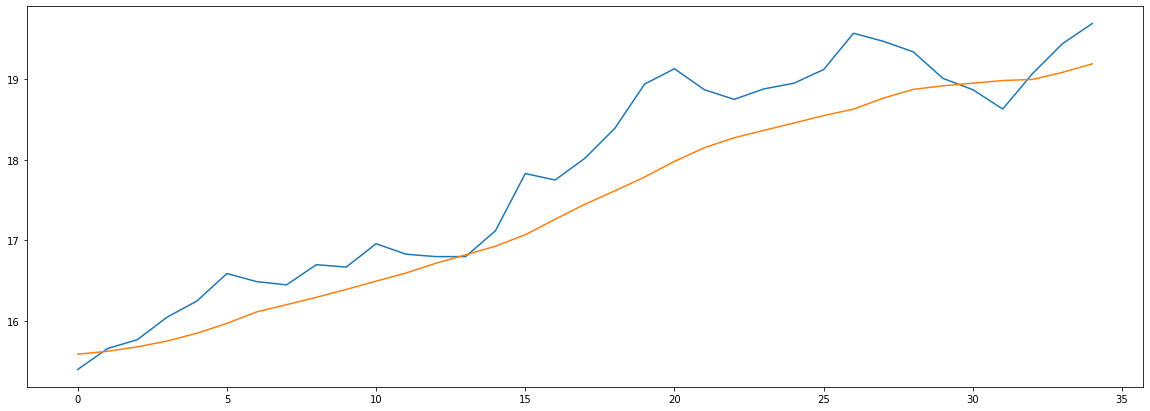

In [316]:
plt.plot(np.array(y_train))
plt.plot(y_train_pred)

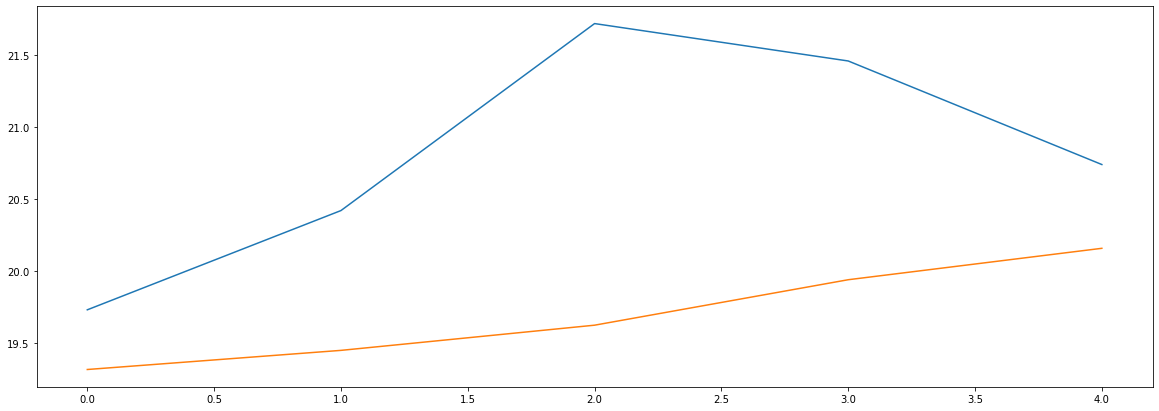

In [317]:
plt.plot(np.array(y_test))
plt.plot(y_test_pred)

# Обучим рекуррентную сеть

Для этого преобразуем данные, на вход будем подавать вектора ['women_median', women_average', 'men_median', 'men_average'] по каждому из 10 предшествующих этому году лет

In [345]:
df_rec = np.array(df[['women_median1years_back', 'women_average1years_back',
       'men_median1years_back', 'men_average1years_back', 
       'women_median2years_back', 'women_average2years_back',
       'men_median2years_back', 'men_average2years_back', 
       'women_median3years_back', 'women_average3years_back',
       'men_median3years_back', 'men_average3years_back', 
       'women_median4years_back', 'women_average4years_back',
       'men_median4years_back', 'men_average4years_back', 
       'women_median5years_back', 'women_average5years_back',
       'men_median5years_back', 'men_average5years_back', 
       'women_median6years_back', 'women_average6years_back',
       'men_median6years_back', 'men_average6years_back', 
       'women_median7years_back', 'women_average7years_back',
       'men_median7years_back', 'men_average7years_back', 
       'women_median8years_back', 'women_average8years_back',
       'men_median8years_back', 'men_average8years_back', 
       'women_median9years_back', 'women_average9years_back',
       'men_median9years_back', 'men_average9years_back', 
       'women_median10years_back', 'women_average10years_back',
       'men_median10years_back', 'men_average10years_back']][x_len:])

df_rec_scaled = scaler.fit_transform(df_rec)


df_rec_scaled.shape

(40, 40)

In [346]:
df_rec_scaled[0]

array([0.        , 0.        , 0.42342342, 0.04069176, 0.02575758,
       0.        , 0.42117117, 0.01831129, 0.01698113, 0.        ,
       0.93675889, 0.04563758, 0.03470716, 0.02191465, 1.        ,
       0.12589413, 0.01094092, 0.        , 1.        , 0.10873147,
       0.        , 0.        , 0.87318841, 0.08862876, 0.02466368,
       0.02607562, 0.78985507, 0.09962406, 0.        , 0.        ,
       0.93115942, 0.05252525, 0.        , 0.        , 0.79347826,
       0.05656566, 0.04690832, 0.03911343, 0.90217391, 0.15353535])

In [349]:
df_rec_scaled = df_rec_scaled.reshape(40, 10, 4)

In [350]:
df_rec_scaled[0]

array([[0.        , 0.        , 0.42342342, 0.04069176],
       [0.02575758, 0.        , 0.42117117, 0.01831129],
       [0.01698113, 0.        , 0.93675889, 0.04563758],
       [0.03470716, 0.02191465, 1.        , 0.12589413],
       [0.01094092, 0.        , 1.        , 0.10873147],
       [0.        , 0.        , 0.87318841, 0.08862876],
       [0.02466368, 0.02607562, 0.78985507, 0.09962406],
       [0.        , 0.        , 0.93115942, 0.05252525],
       [0.        , 0.        , 0.79347826, 0.05656566],
       [0.04690832, 0.03911343, 0.90217391, 0.15353535]])

In [351]:
X_train = df_rec_scaled[:35]
X_train.shape

(35, 10, 4)

In [352]:
X_test = df_rec_scaled[35:]
X_test.shape

(5, 10, 4)

In [353]:
model = Sequential()
model.add(LSTM(128, input_shape=(10, 4)))
model.add(Dense(1, activation='elu'))


model.compile(optimizer='Adam',
              loss='mse',
              metrics=['mae'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               68096     
                                                                 
 dense_16 (Dense)            (None, 1)                 129       
                                                                 
Total params: 68225 (266.50 KB)
Trainable params: 68225 (266.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [354]:
X_train.shape

(35, 10, 4)

In [355]:
%%time
model.fit(X_train, y_train,
          epochs=5000,
          validation_data=(X_test, y_test)
          )

Epoch 1/5000
2/2 [==============================] - 1s 243ms/step - loss: 318.4706 - mae: 17.7997 - val_loss: 417.2475 - val_mae: 20.4141
Epoch 2/5000
2/2 [==============================] - 0s 24ms/step - loss: 312.1010 - mae: 17.6237 - val_loss: 403.8221 - val_mae: 20.0828
Epoch 3/5000
2/2 [==============================] - 0s 22ms/step - loss: 305.2982 - mae: 17.4334 - val_loss: 387.8065 - val_mae: 19.6802
Epoch 4/5000
2/2 [==============================] - 0s 23ms/step - loss: 297.1122 - mae: 17.2021 - val_loss: 367.3531 - val_mae: 19.1539
Epoch 5/5000
2/2 [==============================] - 0s 23ms/step - loss: 287.2383 - mae: 16.9169 - val_loss: 340.2964 - val_mae: 18.4347
Epoch 6/5000
2/2 [==============================] - 0s 23ms/step - loss: 273.5698 - mae: 16.5140 - val_loss: 304.9711 - val_mae: 17.4510
Epoch 7/5000
2/2 [==============================] - 0s 23ms/step - loss: 254.2030 - mae: 15.9240 - val_loss: 262.0032 - val_mae: 16.1739
Epoch 8/5000
2/2 [======================

Epoch 124/5000
2/2 [==============================] - 0s 21ms/step - loss: 1.7250 - mae: 1.2058 - val_loss: 9.7393 - val_mae: 3.0372
Epoch 125/5000
2/2 [==============================] - 0s 22ms/step - loss: 1.7257 - mae: 1.2065 - val_loss: 9.7486 - val_mae: 3.0387
Epoch 126/5000
2/2 [==============================] - 0s 22ms/step - loss: 1.7257 - mae: 1.2066 - val_loss: 9.7095 - val_mae: 3.0323
Epoch 127/5000
2/2 [==============================] - 0s 22ms/step - loss: 1.7242 - mae: 1.2059 - val_loss: 9.6138 - val_mae: 3.0165
Epoch 128/5000
2/2 [==============================] - 0s 22ms/step - loss: 1.7226 - mae: 1.2049 - val_loss: 9.4954 - val_mae: 2.9968
Epoch 129/5000
2/2 [==============================] - 0s 20ms/step - loss: 1.7217 - mae: 1.2026 - val_loss: 9.4050 - val_mae: 2.9817
Epoch 130/5000
2/2 [==============================] - 0s 20ms/step - loss: 1.7199 - mae: 1.2015 - val_loss: 9.3349 - val_mae: 2.9699
Epoch 131/5000
2/2 [==============================] - 0s 21ms/step - 

2/2 [==============================] - 0s 20ms/step - loss: 1.6924 - mae: 1.1829 - val_loss: 8.6512 - val_mae: 2.8525
Epoch 247/5000
2/2 [==============================] - 0s 20ms/step - loss: 1.6913 - mae: 1.1860 - val_loss: 8.8369 - val_mae: 2.8849
Epoch 248/5000
2/2 [==============================] - 0s 20ms/step - loss: 1.6804 - mae: 1.1842 - val_loss: 8.9311 - val_mae: 2.9012
Epoch 249/5000
2/2 [==============================] - 0s 21ms/step - loss: 1.6803 - mae: 1.1856 - val_loss: 8.9650 - val_mae: 2.9070
Epoch 250/5000
2/2 [==============================] - 0s 20ms/step - loss: 1.6769 - mae: 1.1843 - val_loss: 8.9059 - val_mae: 2.8968
Epoch 251/5000
2/2 [==============================] - 0s 21ms/step - loss: 1.6761 - mae: 1.1836 - val_loss: 8.8231 - val_mae: 2.8825
Epoch 252/5000
2/2 [==============================] - 0s 20ms/step - loss: 1.6797 - mae: 1.1839 - val_loss: 8.8509 - val_mae: 2.8873
Epoch 253/5000
2/2 [==============================] - 0s 20ms/step - loss: 1.6731 - 

Epoch 308/5000
2/2 [==============================] - 0s 20ms/step - loss: 1.5452 - mae: 1.1412 - val_loss: 8.7789 - val_mae: 2.8752
Epoch 309/5000
2/2 [==============================] - 0s 21ms/step - loss: 1.5384 - mae: 1.1378 - val_loss: 8.5214 - val_mae: 2.8300
Epoch 310/5000
2/2 [==============================] - 0s 21ms/step - loss: 1.5331 - mae: 1.1335 - val_loss: 8.1815 - val_mae: 2.7693
Epoch 311/5000
2/2 [==============================] - 0s 21ms/step - loss: 1.5382 - mae: 1.1312 - val_loss: 7.9804 - val_mae: 2.7327
Epoch 312/5000
2/2 [==============================] - 0s 28ms/step - loss: 1.5346 - mae: 1.1269 - val_loss: 7.9442 - val_mae: 2.7261
Epoch 313/5000
2/2 [==============================] - 0s 20ms/step - loss: 1.5226 - mae: 1.1223 - val_loss: 7.9887 - val_mae: 2.7343
Epoch 314/5000
2/2 [==============================] - 0s 20ms/step - loss: 1.5061 - mae: 1.1183 - val_loss: 8.1131 - val_mae: 2.7571
Epoch 315/5000
2/2 [==============================] - 0s 20ms/step - 

Epoch 431/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.1118 - mae: 0.2496 - val_loss: 3.5921 - val_mae: 1.7560
Epoch 432/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.2013 - mae: 0.3725 - val_loss: 3.5965 - val_mae: 1.7573
Epoch 433/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.1832 - mae: 0.3514 - val_loss: 3.5182 - val_mae: 1.7348
Epoch 434/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.1493 - mae: 0.3148 - val_loss: 3.4677 - val_mae: 1.7202
Epoch 435/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.1411 - mae: 0.3106 - val_loss: 3.4292 - val_mae: 1.7093
Epoch 436/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.2512 - mae: 0.4084 - val_loss: 3.2548 - val_mae: 1.6571
Epoch 437/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.1638 - mae: 0.3241 - val_loss: 3.1269 - val_mae: 1.6178
Epoch 438/5000
2/2 [==============================] - 0s 21ms/step - 

Epoch 554/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.1303 - mae: 0.2827 - val_loss: 3.5392 - val_mae: 1.7415
Epoch 555/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.1458 - mae: 0.3098 - val_loss: 3.6405 - val_mae: 1.7704
Epoch 556/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.1428 - mae: 0.3127 - val_loss: 3.6276 - val_mae: 1.7667
Epoch 557/5000
2/2 [==============================] - 0s 27ms/step - loss: 0.1280 - mae: 0.2932 - val_loss: 3.5364 - val_mae: 1.7407
Epoch 558/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.1216 - mae: 0.2805 - val_loss: 3.4454 - val_mae: 1.7143
Epoch 559/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.1368 - mae: 0.2951 - val_loss: 3.4285 - val_mae: 1.7093
Epoch 560/5000
2/2 [==============================] - 0s 33ms/step - loss: 0.1210 - mae: 0.2769 - val_loss: 3.4916 - val_mae: 1.7278
Epoch 561/5000
2/2 [==============================] - 0s 24ms/step - 

Epoch 677/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0856 - mae: 0.2443 - val_loss: 3.0470 - val_mae: 1.5947
Epoch 678/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.0790 - mae: 0.2309 - val_loss: 3.0063 - val_mae: 1.5818
Epoch 679/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0729 - mae: 0.2285 - val_loss: 2.9436 - val_mae: 1.5618
Epoch 680/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0741 - mae: 0.2277 - val_loss: 2.9391 - val_mae: 1.5603
Epoch 681/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0782 - mae: 0.2319 - val_loss: 2.9557 - val_mae: 1.5656
Epoch 682/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0786 - mae: 0.2324 - val_loss: 2.9996 - val_mae: 1.5796
Epoch 683/5000
2/2 [==============================] - 0s 20ms/step - loss: 0.0757 - mae: 0.2306 - val_loss: 3.0482 - val_mae: 1.5950
Epoch 684/5000
2/2 [==============================] - 0s 20ms/step - 

Epoch 800/5000
2/2 [==============================] - 0s 20ms/step - loss: 0.1178 - mae: 0.2873 - val_loss: 3.1198 - val_mae: 1.6180
Epoch 801/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0910 - mae: 0.2505 - val_loss: 2.8699 - val_mae: 1.5384
Epoch 802/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0636 - mae: 0.1981 - val_loss: 2.6094 - val_mae: 1.4510
Epoch 803/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.1284 - mae: 0.3067 - val_loss: 2.4618 - val_mae: 1.3990
Epoch 804/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.2031 - mae: 0.3901 - val_loss: 2.4933 - val_mae: 1.4102
Epoch 805/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.1880 - mae: 0.3768 - val_loss: 2.7138 - val_mae: 1.4865
Epoch 806/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.1058 - mae: 0.2787 - val_loss: 3.0102 - val_mae: 1.5834
Epoch 807/5000
2/2 [==============================] - 0s 23ms/step - 

Epoch 923/5000
2/2 [==============================] - 0s 20ms/step - loss: 0.0608 - mae: 0.2055 - val_loss: 2.7721 - val_mae: 1.5061
Epoch 924/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0591 - mae: 0.2010 - val_loss: 2.8464 - val_mae: 1.5307
Epoch 925/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0607 - mae: 0.1990 - val_loss: 2.8608 - val_mae: 1.5354
Epoch 926/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.0598 - mae: 0.1979 - val_loss: 2.8623 - val_mae: 1.5358
Epoch 927/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.0584 - mae: 0.1978 - val_loss: 2.8607 - val_mae: 1.5353
Epoch 928/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0603 - mae: 0.2038 - val_loss: 2.8445 - val_mae: 1.5300
Epoch 929/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0635 - mae: 0.2124 - val_loss: 2.9077 - val_mae: 1.5506
Epoch 930/5000
2/2 [==============================] - 0s 21ms/step - 

2/2 [==============================] - 0s 23ms/step - loss: 0.0645 - mae: 0.2183 - val_loss: 2.8221 - val_mae: 1.5226
Epoch 1046/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.0594 - mae: 0.2052 - val_loss: 2.9127 - val_mae: 1.5521
Epoch 1047/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0562 - mae: 0.1905 - val_loss: 3.0322 - val_mae: 1.5903
Epoch 1048/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0645 - mae: 0.1975 - val_loss: 3.0943 - val_mae: 1.6097
Epoch 1049/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0703 - mae: 0.2073 - val_loss: 3.0408 - val_mae: 1.5930
Epoch 1050/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0626 - mae: 0.1973 - val_loss: 2.9790 - val_mae: 1.5733
Epoch 1051/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0574 - mae: 0.1925 - val_loss: 2.9512 - val_mae: 1.5644
Epoch 1052/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.

2/2 [==============================] - 0s 22ms/step - loss: 0.0674 - mae: 0.2041 - val_loss: 2.8719 - val_mae: 1.5391
Epoch 1168/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.0596 - mae: 0.1944 - val_loss: 2.7144 - val_mae: 1.4870
Epoch 1169/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0620 - mae: 0.2047 - val_loss: 2.7167 - val_mae: 1.4878
Epoch 1170/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0594 - mae: 0.2012 - val_loss: 2.8531 - val_mae: 1.5330
Epoch 1171/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0612 - mae: 0.1931 - val_loss: 2.9285 - val_mae: 1.5575
Epoch 1172/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.0625 - mae: 0.1927 - val_loss: 2.9436 - val_mae: 1.5623
Epoch 1173/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0597 - mae: 0.1900 - val_loss: 3.0393 - val_mae: 1.5926
Epoch 1174/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.

2/2 [==============================] - 0s 21ms/step - loss: 0.0862 - mae: 0.2521 - val_loss: 2.8355 - val_mae: 1.5270
Epoch 1290/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.0582 - mae: 0.2013 - val_loss: 3.0422 - val_mae: 1.5935
Epoch 1291/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0647 - mae: 0.1975 - val_loss: 3.1727 - val_mae: 1.6340
Epoch 1292/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0832 - mae: 0.2330 - val_loss: 3.1047 - val_mae: 1.6130
Epoch 1293/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0726 - mae: 0.2127 - val_loss: 2.9292 - val_mae: 1.5575
Epoch 1294/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0590 - mae: 0.1921 - val_loss: 2.7942 - val_mae: 1.5135
Epoch 1295/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0572 - mae: 0.1965 - val_loss: 2.7786 - val_mae: 1.5084
Epoch 1296/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.

2/2 [==============================] - 0s 21ms/step - loss: 0.0764 - mae: 0.2282 - val_loss: 3.1091 - val_mae: 1.6143
Epoch 1412/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.1027 - mae: 0.2684 - val_loss: 2.9592 - val_mae: 1.5671
Epoch 1413/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0699 - mae: 0.2105 - val_loss: 2.6834 - val_mae: 1.4762
Epoch 1414/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0573 - mae: 0.2004 - val_loss: 2.4641 - val_mae: 1.3997
Epoch 1415/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.0894 - mae: 0.2539 - val_loss: 2.4171 - val_mae: 1.3828
Epoch 1416/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0943 - mae: 0.2586 - val_loss: 2.5287 - val_mae: 1.4227
Epoch 1417/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0668 - mae: 0.2178 - val_loss: 2.6833 - val_mae: 1.4762
Epoch 1418/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.

2/2 [==============================] - 0s 21ms/step - loss: 0.0575 - mae: 0.1923 - val_loss: 2.9157 - val_mae: 1.5526
Epoch 1534/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0560 - mae: 0.1946 - val_loss: 2.8522 - val_mae: 1.5319
Epoch 1535/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0578 - mae: 0.2040 - val_loss: 2.8796 - val_mae: 1.5409
Epoch 1536/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0580 - mae: 0.2047 - val_loss: 2.9314 - val_mae: 1.5576
Epoch 1537/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0565 - mae: 0.1996 - val_loss: 3.0005 - val_mae: 1.5797
Epoch 1538/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0562 - mae: 0.1948 - val_loss: 3.0260 - val_mae: 1.5877
Epoch 1539/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.0556 - mae: 0.1926 - val_loss: 3.0014 - val_mae: 1.5799
Epoch 1540/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.

2/2 [==============================] - 0s 28ms/step - loss: 0.0677 - mae: 0.2078 - val_loss: 3.0177 - val_mae: 1.5852
Epoch 1656/5000
2/2 [==============================] - 0s 27ms/step - loss: 0.0617 - mae: 0.1993 - val_loss: 2.8266 - val_mae: 1.5236
Epoch 1657/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0570 - mae: 0.2026 - val_loss: 2.7659 - val_mae: 1.5035
Epoch 1658/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0630 - mae: 0.2137 - val_loss: 2.8613 - val_mae: 1.5350
Epoch 1659/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0549 - mae: 0.1932 - val_loss: 3.0356 - val_mae: 1.5909
Epoch 1660/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0651 - mae: 0.1986 - val_loss: 3.0319 - val_mae: 1.5898
Epoch 1661/5000
2/2 [==============================] - 0s 30ms/step - loss: 0.0618 - mae: 0.1940 - val_loss: 2.8051 - val_mae: 1.5166
Epoch 1662/5000
2/2 [==============================] - 0s 28ms/step - loss: 0.

2/2 [==============================] - 0s 28ms/step - loss: 0.0648 - mae: 0.1914 - val_loss: 3.4258 - val_mae: 1.7090
Epoch 1778/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0852 - mae: 0.2300 - val_loss: 3.3455 - val_mae: 1.6854
Epoch 1779/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0706 - mae: 0.2038 - val_loss: 3.1285 - val_mae: 1.6196
Epoch 1780/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0561 - mae: 0.1919 - val_loss: 2.9265 - val_mae: 1.5558
Epoch 1781/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0707 - mae: 0.2292 - val_loss: 2.8602 - val_mae: 1.5343
Epoch 1782/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0737 - mae: 0.2349 - val_loss: 2.9392 - val_mae: 1.5600
Epoch 1783/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0575 - mae: 0.1987 - val_loss: 3.0610 - val_mae: 1.5987
Epoch 1784/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.

2/2 [==============================] - 0s 25ms/step - loss: 0.0673 - mae: 0.2219 - val_loss: 2.8695 - val_mae: 1.5375
Epoch 1900/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0577 - mae: 0.2023 - val_loss: 2.9290 - val_mae: 1.5568
Epoch 1901/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0543 - mae: 0.1888 - val_loss: 2.8910 - val_mae: 1.5446
Epoch 1902/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0541 - mae: 0.1887 - val_loss: 2.8580 - val_mae: 1.5339
Epoch 1903/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0545 - mae: 0.1901 - val_loss: 2.8829 - val_mae: 1.5420
Epoch 1904/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0545 - mae: 0.1876 - val_loss: 2.9661 - val_mae: 1.5688
Epoch 1905/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0596 - mae: 0.1924 - val_loss: 3.0164 - val_mae: 1.5848
Epoch 1906/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.

2/2 [==============================] - 0s 24ms/step - loss: 0.0559 - mae: 0.1885 - val_loss: 2.9154 - val_mae: 1.5527
Epoch 2022/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0569 - mae: 0.1896 - val_loss: 2.9647 - val_mae: 1.5685
Epoch 2023/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0579 - mae: 0.1902 - val_loss: 2.9275 - val_mae: 1.5566
Epoch 2024/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0550 - mae: 0.1867 - val_loss: 2.8304 - val_mae: 1.5250
Epoch 2025/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0555 - mae: 0.1950 - val_loss: 2.8141 - val_mae: 1.5196
Epoch 2026/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0563 - mae: 0.1968 - val_loss: 2.8742 - val_mae: 1.5393
Epoch 2027/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0543 - mae: 0.1889 - val_loss: 2.9315 - val_mae: 1.5578
Epoch 2028/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.

2/2 [==============================] - 0s 23ms/step - loss: 0.0577 - mae: 0.1954 - val_loss: 2.9980 - val_mae: 1.5794
Epoch 2144/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0816 - mae: 0.2374 - val_loss: 2.9114 - val_mae: 1.5516
Epoch 2145/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0649 - mae: 0.2105 - val_loss: 2.6983 - val_mae: 1.4811
Epoch 2146/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0562 - mae: 0.1950 - val_loss: 2.6154 - val_mae: 1.4527
Epoch 2147/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0678 - mae: 0.2198 - val_loss: 2.7058 - val_mae: 1.4835
Epoch 2148/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0606 - mae: 0.2056 - val_loss: 2.9115 - val_mae: 1.5514
Epoch 2149/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0556 - mae: 0.1952 - val_loss: 2.9656 - val_mae: 1.5687
Epoch 2150/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.

2/2 [==============================] - 0s 24ms/step - loss: 0.0543 - mae: 0.1937 - val_loss: 3.0073 - val_mae: 1.5816
Epoch 2266/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0540 - mae: 0.1936 - val_loss: 3.0143 - val_mae: 1.5838
Epoch 2267/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0539 - mae: 0.1930 - val_loss: 2.9917 - val_mae: 1.5766
Epoch 2268/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0537 - mae: 0.1921 - val_loss: 3.0243 - val_mae: 1.5870
Epoch 2269/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0548 - mae: 0.1893 - val_loss: 3.0839 - val_mae: 1.6057
Epoch 2270/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0613 - mae: 0.1986 - val_loss: 2.9845 - val_mae: 1.5744
Epoch 2271/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0559 - mae: 0.1909 - val_loss: 2.7301 - val_mae: 1.4913
Epoch 2272/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.

2/2 [==============================] - 0s 24ms/step - loss: 0.0560 - mae: 0.1853 - val_loss: 3.1109 - val_mae: 1.6141
Epoch 2388/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0543 - mae: 0.1818 - val_loss: 3.2057 - val_mae: 1.6432
Epoch 2389/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0580 - mae: 0.1840 - val_loss: 3.2051 - val_mae: 1.6431
Epoch 2390/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0570 - mae: 0.1816 - val_loss: 3.0999 - val_mae: 1.6107
Epoch 2391/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0563 - mae: 0.1908 - val_loss: 3.1011 - val_mae: 1.6110
Epoch 2392/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0564 - mae: 0.1896 - val_loss: 3.1093 - val_mae: 1.6136
Epoch 2393/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0552 - mae: 0.1849 - val_loss: 3.0942 - val_mae: 1.6089
Epoch 2394/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.

2/2 [==============================] - 0s 24ms/step - loss: 0.0773 - mae: 0.2406 - val_loss: 2.7620 - val_mae: 1.5020
Epoch 2510/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0609 - mae: 0.2077 - val_loss: 2.9185 - val_mae: 1.5533
Epoch 2511/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.0547 - mae: 0.1808 - val_loss: 3.0154 - val_mae: 1.5843
Epoch 2512/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0604 - mae: 0.1952 - val_loss: 2.9515 - val_mae: 1.5640
Epoch 2513/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0563 - mae: 0.1863 - val_loss: 2.8503 - val_mae: 1.5313
Epoch 2514/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0527 - mae: 0.1785 - val_loss: 2.7827 - val_mae: 1.5090
Epoch 2515/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0543 - mae: 0.1864 - val_loss: 2.8169 - val_mae: 1.5203
Epoch 2516/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.

2/2 [==============================] - 0s 25ms/step - loss: 0.0550 - mae: 0.1890 - val_loss: 2.7409 - val_mae: 1.4949
Epoch 2632/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0536 - mae: 0.1858 - val_loss: 2.7591 - val_mae: 1.5010
Epoch 2633/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0537 - mae: 0.1875 - val_loss: 2.7832 - val_mae: 1.5090
Epoch 2634/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0534 - mae: 0.1868 - val_loss: 2.8937 - val_mae: 1.5452
Epoch 2635/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0578 - mae: 0.1916 - val_loss: 2.9134 - val_mae: 1.5515
Epoch 2636/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0568 - mae: 0.1931 - val_loss: 2.8626 - val_mae: 1.5350
Epoch 2637/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0522 - mae: 0.1864 - val_loss: 2.8348 - val_mae: 1.5259
Epoch 2638/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.

2/2 [==============================] - 0s 24ms/step - loss: 0.0520 - mae: 0.1852 - val_loss: 2.8924 - val_mae: 1.5446
Epoch 2754/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0503 - mae: 0.1813 - val_loss: 2.9161 - val_mae: 1.5522
Epoch 2755/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0496 - mae: 0.1789 - val_loss: 2.9959 - val_mae: 1.5777
Epoch 2756/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0491 - mae: 0.1762 - val_loss: 3.0725 - val_mae: 1.6018
Epoch 2757/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0499 - mae: 0.1743 - val_loss: 3.1196 - val_mae: 1.6165
Epoch 2758/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0507 - mae: 0.1727 - val_loss: 3.1577 - val_mae: 1.6282
Epoch 2759/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0520 - mae: 0.1716 - val_loss: 3.2068 - val_mae: 1.6432
Epoch 2760/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.

2/2 [==============================] - 0s 24ms/step - loss: 0.0491 - mae: 0.1718 - val_loss: 2.9926 - val_mae: 1.5766
Epoch 2876/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0504 - mae: 0.1735 - val_loss: 3.0209 - val_mae: 1.5856
Epoch 2877/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0545 - mae: 0.1788 - val_loss: 3.0348 - val_mae: 1.5900
Epoch 2878/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0565 - mae: 0.1820 - val_loss: 2.9671 - val_mae: 1.5685
Epoch 2879/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0525 - mae: 0.1751 - val_loss: 2.8844 - val_mae: 1.5419
Epoch 2880/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0490 - mae: 0.1711 - val_loss: 2.9248 - val_mae: 1.5549
Epoch 2881/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0486 - mae: 0.1702 - val_loss: 2.9804 - val_mae: 1.5727
Epoch 2882/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.

2/2 [==============================] - 0s 24ms/step - loss: 0.0502 - mae: 0.1712 - val_loss: 3.0771 - val_mae: 1.6030
Epoch 2998/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0532 - mae: 0.1735 - val_loss: 3.0423 - val_mae: 1.5921
Epoch 2999/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0490 - mae: 0.1689 - val_loss: 2.9066 - val_mae: 1.5488
Epoch 3000/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0539 - mae: 0.1953 - val_loss: 2.8521 - val_mae: 1.5311
Epoch 3001/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0618 - mae: 0.2142 - val_loss: 2.8876 - val_mae: 1.5426
Epoch 3002/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0566 - mae: 0.2003 - val_loss: 2.9422 - val_mae: 1.5603
Epoch 3003/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0487 - mae: 0.1734 - val_loss: 3.0223 - val_mae: 1.5858
Epoch 3004/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.

2/2 [==============================] - 0s 24ms/step - loss: 0.0873 - mae: 0.2508 - val_loss: 2.7674 - val_mae: 1.5033
Epoch 3120/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0504 - mae: 0.1790 - val_loss: 2.5288 - val_mae: 1.4216
Epoch 3121/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0866 - mae: 0.2503 - val_loss: 2.6085 - val_mae: 1.4494
Epoch 3122/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0820 - mae: 0.2384 - val_loss: 2.8929 - val_mae: 1.5446
Epoch 3123/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0692 - mae: 0.2070 - val_loss: 3.1598 - val_mae: 1.6288
Epoch 3124/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0917 - mae: 0.2440 - val_loss: 3.1920 - val_mae: 1.6386
Epoch 3125/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0822 - mae: 0.2273 - val_loss: 3.0676 - val_mae: 1.6001
Epoch 3126/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.

2/2 [==============================] - 0s 25ms/step - loss: 0.0485 - mae: 0.1776 - val_loss: 2.5851 - val_mae: 1.4413
Epoch 3242/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0740 - mae: 0.2323 - val_loss: 2.5812 - val_mae: 1.4400
Epoch 3243/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0621 - mae: 0.2062 - val_loss: 2.8651 - val_mae: 1.5356
Epoch 3244/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0550 - mae: 0.1865 - val_loss: 3.1239 - val_mae: 1.6178
Epoch 3245/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0776 - mae: 0.2316 - val_loss: 3.0741 - val_mae: 1.6022
Epoch 3246/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0573 - mae: 0.1820 - val_loss: 2.8224 - val_mae: 1.5215
Epoch 3247/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0577 - mae: 0.1988 - val_loss: 2.6946 - val_mae: 1.4788
Epoch 3248/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.

2/2 [==============================] - 0s 26ms/step - loss: 0.0481 - mae: 0.1668 - val_loss: 2.9580 - val_mae: 1.5652
Epoch 3364/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0479 - mae: 0.1714 - val_loss: 2.8609 - val_mae: 1.5339
Epoch 3365/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0541 - mae: 0.1973 - val_loss: 2.8989 - val_mae: 1.5462
Epoch 3366/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0521 - mae: 0.1881 - val_loss: 2.9278 - val_mae: 1.5556
Epoch 3367/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0475 - mae: 0.1687 - val_loss: 2.9028 - val_mae: 1.5476
Epoch 3368/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0470 - mae: 0.1663 - val_loss: 2.9395 - val_mae: 1.5594
Epoch 3369/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0514 - mae: 0.1758 - val_loss: 2.9349 - val_mae: 1.5580
Epoch 3370/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.

2/2 [==============================] - 0s 25ms/step - loss: 0.0493 - mae: 0.1686 - val_loss: 3.0165 - val_mae: 1.5838
Epoch 3486/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0478 - mae: 0.1676 - val_loss: 2.9358 - val_mae: 1.5581
Epoch 3487/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0473 - mae: 0.1711 - val_loss: 2.8264 - val_mae: 1.5225
Epoch 3488/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0518 - mae: 0.1849 - val_loss: 2.7552 - val_mae: 1.4989
Epoch 3489/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0578 - mae: 0.2015 - val_loss: 2.7204 - val_mae: 1.4873
Epoch 3490/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0565 - mae: 0.1937 - val_loss: 2.7621 - val_mae: 1.5013
Epoch 3491/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0539 - mae: 0.1947 - val_loss: 2.9282 - val_mae: 1.5557
Epoch 3492/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.

2/2 [==============================] - 0s 27ms/step - loss: 0.0475 - mae: 0.1658 - val_loss: 2.8399 - val_mae: 1.5270
Epoch 3608/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0480 - mae: 0.1707 - val_loss: 2.8389 - val_mae: 1.5266
Epoch 3609/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0481 - mae: 0.1693 - val_loss: 2.8396 - val_mae: 1.5269
Epoch 3610/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0479 - mae: 0.1710 - val_loss: 2.9420 - val_mae: 1.5600
Epoch 3611/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0471 - mae: 0.1703 - val_loss: 3.1253 - val_mae: 1.6177
Epoch 3612/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0490 - mae: 0.1679 - val_loss: 3.1605 - val_mae: 1.6285
Epoch 3613/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0494 - mae: 0.1710 - val_loss: 3.1592 - val_mae: 1.6281
Epoch 3614/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.

2/2 [==============================] - 0s 27ms/step - loss: 0.0619 - mae: 0.2081 - val_loss: 2.9604 - val_mae: 1.5663
Epoch 3730/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0586 - mae: 0.1958 - val_loss: 3.2610 - val_mae: 1.6598
Epoch 3731/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.1075 - mae: 0.2696 - val_loss: 3.2370 - val_mae: 1.6526
Epoch 3732/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0774 - mae: 0.2238 - val_loss: 3.0096 - val_mae: 1.5821
Epoch 3733/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0542 - mae: 0.1801 - val_loss: 2.8174 - val_mae: 1.5199
Epoch 3734/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0704 - mae: 0.2223 - val_loss: 2.8053 - val_mae: 1.5158
Epoch 3735/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0781 - mae: 0.2328 - val_loss: 2.9074 - val_mae: 1.5492
Epoch 3736/5000
2/2 [==============================] - 0s 29ms/step - loss: 0.

2/2 [==============================] - 0s 27ms/step - loss: 0.0565 - mae: 0.1696 - val_loss: 3.2838 - val_mae: 1.6661
Epoch 3852/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0526 - mae: 0.1639 - val_loss: 3.1166 - val_mae: 1.6150
Epoch 3853/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0502 - mae: 0.1780 - val_loss: 3.0448 - val_mae: 1.5926
Epoch 3854/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0508 - mae: 0.1852 - val_loss: 3.1167 - val_mae: 1.6151
Epoch 3855/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0495 - mae: 0.1705 - val_loss: 3.1440 - val_mae: 1.6235
Epoch 3856/5000
2/2 [==============================] - 0s 28ms/step - loss: 0.0512 - mae: 0.1654 - val_loss: 2.9864 - val_mae: 1.5742
Epoch 3857/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0488 - mae: 0.1732 - val_loss: 2.8439 - val_mae: 1.5282
Epoch 3858/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.

2/2 [==============================] - 0s 27ms/step - loss: 0.0516 - mae: 0.1768 - val_loss: 3.1723 - val_mae: 1.6322
Epoch 3974/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0565 - mae: 0.1766 - val_loss: 3.1566 - val_mae: 1.6274
Epoch 3975/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0543 - mae: 0.1742 - val_loss: 3.0945 - val_mae: 1.6081
Epoch 3976/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0559 - mae: 0.1867 - val_loss: 3.0782 - val_mae: 1.6030
Epoch 3977/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0614 - mae: 0.2036 - val_loss: 3.1243 - val_mae: 1.6173
Epoch 3978/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0596 - mae: 0.1945 - val_loss: 3.2256 - val_mae: 1.6484
Epoch 3979/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0603 - mae: 0.1829 - val_loss: 3.2042 - val_mae: 1.6419
Epoch 3980/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.

2/2 [==============================] - 0s 25ms/step - loss: 0.0487 - mae: 0.1667 - val_loss: 2.6635 - val_mae: 1.4679
Epoch 4096/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0501 - mae: 0.1762 - val_loss: 2.4655 - val_mae: 1.3989
Epoch 4097/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0608 - mae: 0.1977 - val_loss: 2.5052 - val_mae: 1.4131
Epoch 4098/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0516 - mae: 0.1668 - val_loss: 2.7345 - val_mae: 1.4922
Epoch 4099/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0604 - mae: 0.1994 - val_loss: 2.9371 - val_mae: 1.5587
Epoch 4100/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0811 - mae: 0.2438 - val_loss: 2.9088 - val_mae: 1.5495
Epoch 4101/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0612 - mae: 0.1958 - val_loss: 2.6748 - val_mae: 1.4719
Epoch 4102/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.

2/2 [==============================] - 0s 27ms/step - loss: 0.0644 - mae: 0.2166 - val_loss: 2.8025 - val_mae: 1.5142
Epoch 4218/5000
2/2 [==============================] - 0s 34ms/step - loss: 0.0788 - mae: 0.2368 - val_loss: 2.8842 - val_mae: 1.5410
Epoch 4219/5000
2/2 [==============================] - 0s 31ms/step - loss: 0.0726 - mae: 0.2177 - val_loss: 2.9953 - val_mae: 1.5767
Epoch 4220/5000
2/2 [==============================] - 0s 28ms/step - loss: 0.0722 - mae: 0.2079 - val_loss: 3.0539 - val_mae: 1.5952
Epoch 4221/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0722 - mae: 0.2066 - val_loss: 3.1081 - val_mae: 1.6121
Epoch 4222/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0681 - mae: 0.2006 - val_loss: 3.3428 - val_mae: 1.6833
Epoch 4223/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0720 - mae: 0.1973 - val_loss: 3.4854 - val_mae: 1.7252
Epoch 4224/5000
2/2 [==============================] - 0s 27ms/step - loss: 0.

2/2 [==============================] - 0s 24ms/step - loss: 0.0526 - mae: 0.1869 - val_loss: 2.8563 - val_mae: 1.5316
Epoch 4340/5000
2/2 [==============================] - 0s 27ms/step - loss: 0.0558 - mae: 0.1950 - val_loss: 2.9164 - val_mae: 1.5512
Epoch 4341/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0465 - mae: 0.1684 - val_loss: 2.9864 - val_mae: 1.5737
Epoch 4342/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0467 - mae: 0.1657 - val_loss: 3.0117 - val_mae: 1.5817
Epoch 4343/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0509 - mae: 0.1720 - val_loss: 2.9166 - val_mae: 1.5514
Epoch 4344/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0474 - mae: 0.1672 - val_loss: 2.6747 - val_mae: 1.4713
Epoch 4345/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0590 - mae: 0.1997 - val_loss: 2.6034 - val_mae: 1.4468
Epoch 4346/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.

2/2 [==============================] - 0s 23ms/step - loss: 0.0572 - mae: 0.1892 - val_loss: 3.0554 - val_mae: 1.5957
Epoch 4462/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0654 - mae: 0.2108 - val_loss: 3.0353 - val_mae: 1.5893
Epoch 4463/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0525 - mae: 0.1756 - val_loss: 2.9061 - val_mae: 1.5481
Epoch 4464/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0499 - mae: 0.1789 - val_loss: 2.8667 - val_mae: 1.5353
Epoch 4465/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0566 - mae: 0.1991 - val_loss: 2.9481 - val_mae: 1.5616
Epoch 4466/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0549 - mae: 0.1921 - val_loss: 3.1114 - val_mae: 1.6131
Epoch 4467/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0540 - mae: 0.1792 - val_loss: 3.2243 - val_mae: 1.6477
Epoch 4468/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.

2/2 [==============================] - 0s 23ms/step - loss: 0.0460 - mae: 0.1621 - val_loss: 2.8107 - val_mae: 1.5167
Epoch 4584/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0510 - mae: 0.1836 - val_loss: 2.8347 - val_mae: 1.5246
Epoch 4585/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0544 - mae: 0.1934 - val_loss: 2.9070 - val_mae: 1.5481
Epoch 4586/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0527 - mae: 0.1878 - val_loss: 2.9803 - val_mae: 1.5716
Epoch 4587/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0492 - mae: 0.1749 - val_loss: 3.1004 - val_mae: 1.6094
Epoch 4588/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0498 - mae: 0.1650 - val_loss: 3.1913 - val_mae: 1.6374
Epoch 4589/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0497 - mae: 0.1584 - val_loss: 3.1681 - val_mae: 1.6302
Epoch 4590/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.

2/2 [==============================] - 0s 30ms/step - loss: 0.0519 - mae: 0.1792 - val_loss: 3.0043 - val_mae: 1.5797
Epoch 4706/5000
2/2 [==============================] - 0s 27ms/step - loss: 0.0503 - mae: 0.1787 - val_loss: 2.8393 - val_mae: 1.5266
Epoch 4707/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0523 - mae: 0.1859 - val_loss: 2.7943 - val_mae: 1.5119
Epoch 4708/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0518 - mae: 0.1835 - val_loss: 2.7866 - val_mae: 1.5095
Epoch 4709/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0524 - mae: 0.1796 - val_loss: 2.7184 - val_mae: 1.4867
Epoch 4710/5000
2/2 [==============================] - 0s 28ms/step - loss: 0.0522 - mae: 0.1808 - val_loss: 2.6223 - val_mae: 1.4539
Epoch 4711/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0581 - mae: 0.1938 - val_loss: 2.6060 - val_mae: 1.4482
Epoch 4712/5000
2/2 [==============================] - 0s 27ms/step - loss: 0.

2/2 [==============================] - 0s 24ms/step - loss: 0.0519 - mae: 0.1858 - val_loss: 2.8223 - val_mae: 1.5197
Epoch 4828/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0516 - mae: 0.1851 - val_loss: 2.9143 - val_mae: 1.5497
Epoch 4829/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0467 - mae: 0.1723 - val_loss: 3.0187 - val_mae: 1.5830
Epoch 4830/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0502 - mae: 0.1745 - val_loss: 2.9051 - val_mae: 1.5468
Epoch 4831/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0476 - mae: 0.1701 - val_loss: 2.7614 - val_mae: 1.4996
Epoch 4832/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0471 - mae: 0.1718 - val_loss: 2.8029 - val_mae: 1.5131
Epoch 4833/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0463 - mae: 0.1714 - val_loss: 2.9602 - val_mae: 1.5638
Epoch 4834/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.

2/2 [==============================] - 0s 24ms/step - loss: 0.0461 - mae: 0.1560 - val_loss: 2.9840 - val_mae: 1.5726
Epoch 4950/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0462 - mae: 0.1640 - val_loss: 2.8383 - val_mae: 1.5255
Epoch 4951/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0461 - mae: 0.1717 - val_loss: 2.7116 - val_mae: 1.4834
Epoch 4952/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0527 - mae: 0.1869 - val_loss: 2.6879 - val_mae: 1.4753
Epoch 4953/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0537 - mae: 0.1901 - val_loss: 2.7576 - val_mae: 1.4988
Epoch 4954/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0469 - mae: 0.1741 - val_loss: 2.8977 - val_mae: 1.5449
Epoch 4955/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0453 - mae: 0.1561 - val_loss: 3.0256 - val_mae: 1.5858
Epoch 4956/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.

In [356]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 19ms/step - loss: 2.8540 - mae: 1.5305


[2.8539867401123047, 1.5304752588272095]

In [357]:
X_train[:2]

array([[[0.        , 0.        , 0.42342342, 0.04069176],
        [0.02575758, 0.        , 0.42117117, 0.01831129],
        [0.01698113, 0.        , 0.93675889, 0.04563758],
        [0.03470716, 0.02191465, 1.        , 0.12589413],
        [0.01094092, 0.        , 1.        , 0.10873147],
        [0.        , 0.        , 0.87318841, 0.08862876],
        [0.02466368, 0.02607562, 0.78985507, 0.09962406],
        [0.        , 0.        , 0.93115942, 0.05252525],
        [0.        , 0.        , 0.79347826, 0.05656566],
        [0.04690832, 0.03911343, 0.90217391, 0.15353535]],

       [[0.04242424, 0.01100917, 0.32657658, 0.04374364],
        [0.        , 0.02678571, 0.42342342, 0.04069176],
        [0.03207547, 0.00107643, 0.73913043, 0.02416107],
        [0.01952278, 0.        , 0.91153846, 0.04864092],
        [0.03501094, 0.02734839, 0.94202899, 0.14497529],
        [0.01345291, 0.00737101, 1.        , 0.11036789],
        [0.        , 0.        , 0.87318841, 0.09962406],
        [0.0

In [358]:
y_train

array([15.4 , 15.66, 15.77, 16.05, 16.25, 16.59, 16.49, 16.45, 16.7 ,
       16.67, 16.96, 16.83, 16.8 , 16.8 , 17.12, 17.83, 17.75, 18.02,
       18.39, 18.94, 19.13, 18.87, 18.75, 18.88, 18.95, 19.12, 19.57,
       19.47, 19.34, 19.01, 18.87, 18.63, 19.07, 19.44, 19.69])

In [359]:
y_train_pred = np.array(model.predict(X_train))
y_train_pred

2/2 [==============================] - 0s 2ms/step


array([[15.583584 ],
       [15.645204 ],
       [15.782682 ],
       [15.9726515],
       [16.198883 ],
       [16.368423 ],
       [16.560165 ],
       [16.56731  ],
       [16.651947 ],
       [16.777336 ],
       [16.84516  ],
       [16.800354 ],
       [16.824154 ],
       [16.988247 ],
       [17.244648 ],
       [17.509182 ],
       [17.749893 ],
       [18.070518 ],
       [18.491175 ],
       [18.81268  ],
       [18.959585 ],
       [19.010923 ],
       [19.018316 ],
       [19.029598 ],
       [19.075611 ],
       [19.140247 ],
       [19.167849 ],
       [19.193317 ],
       [19.222908 ],
       [19.24838  ],
       [19.253098 ],
       [19.24781  ],
       [19.23994  ],
       [19.251553 ],
       [19.265457 ]], dtype=float32)

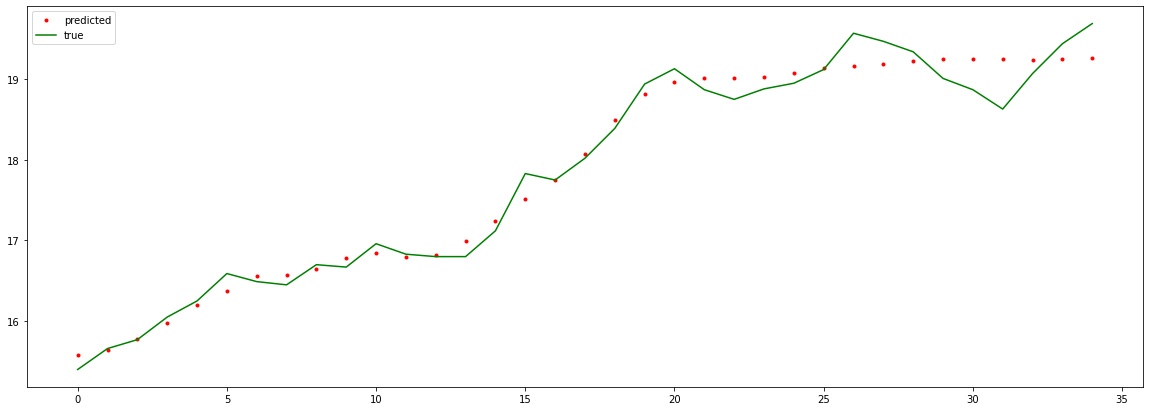

In [360]:
plt.plot(y_train_pred, '.r', label='predicted')
plt.plot(np.array(y_train), 'g', label='true')
plt.legend();

1/1 [==============================] - 0s 16ms/step


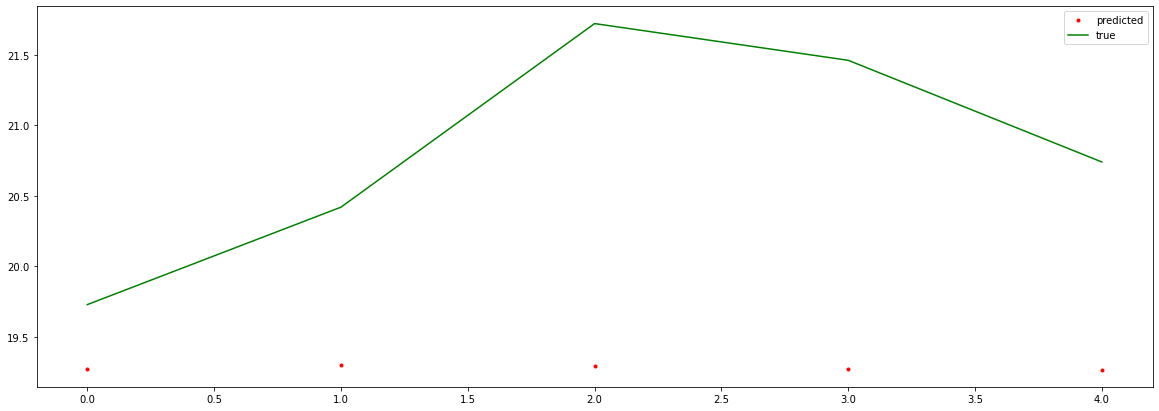

In [361]:
y_test_pred = np.array(model.predict(X_test))

plt.plot(y_test_pred, '.r', label='predicted')
plt.plot(np.array(y_test), 'g', label='true')
plt.legend();

In [362]:
y_test_pred = model.predict(X_test)
test_mse, test_mae = model.evaluate(X_test, y_test, verbose=2)


print 
(f'test_mse: {round(test_mse, 2)}, test_mae: {round(test_mae,2)}')

1/1 [==============================] - 0s 14ms/step
1/1 - 0s - loss: 2.8540 - mae: 1.5305 - 14ms/epoch - 14ms/step


'test_mse: 2.85, test_mae: 1.53'

## Gated Recurrent Unit (GRU)

Теперь, когда мы знаем как работает LSTM, давайте бегло взглянем на то, как работает GRU.

In [363]:
from tensorflow.keras.layers import GRU


model = Sequential()
model.add(GRU(128, input_shape=(10, 4)))
model.add(Dense(1, activation='elu'))


model.compile(optimizer='Adam',
              loss='mse',
              metrics=['mae'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 128)               51456     
                                                                 
 dense_17 (Dense)            (None, 1)                 129       
                                                                 
Total params: 51585 (201.50 KB)
Trainable params: 51585 (201.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [364]:
%%time
model.fit(X_train, y_train,
          epochs=5000,
          validation_data=(X_test, y_test)
          )

Epoch 1/5000
2/2 [==============================] - 1s 228ms/step - loss: 315.1051 - mae: 17.7036 - val_loss: 411.8324 - val_mae: 20.2805
Epoch 2/5000
2/2 [==============================] - 0s 26ms/step - loss: 308.1080 - mae: 17.5086 - val_loss: 398.3065 - val_mae: 19.9440
Epoch 3/5000
2/2 [==============================] - 0s 22ms/step - loss: 300.6981 - mae: 17.2989 - val_loss: 383.2193 - val_mae: 19.5619
Epoch 4/5000
2/2 [==============================] - 0s 23ms/step - loss: 292.2068 - mae: 17.0557 - val_loss: 365.3618 - val_mae: 19.0999
Epoch 5/5000
2/2 [==============================] - 0s 23ms/step - loss: 282.5379 - mae: 16.7725 - val_loss: 343.1857 - val_mae: 18.5102
Epoch 6/5000
2/2 [==============================] - 0s 22ms/step - loss: 270.1912 - mae: 16.4040 - val_loss: 313.9586 - val_mae: 17.7034
Epoch 7/5000
2/2 [==============================] - 0s 23ms/step - loss: 253.5419 - mae: 15.8937 - val_loss: 272.7861 - val_mae: 16.5003
Epoch 8/5000
2/2 [======================

Epoch 124/5000
2/2 [==============================] - 0s 21ms/step - loss: 1.7610 - mae: 1.2184 - val_loss: 10.0856 - val_mae: 3.0937
Epoch 125/5000
2/2 [==============================] - 0s 22ms/step - loss: 1.7618 - mae: 1.2191 - val_loss: 10.0862 - val_mae: 3.0938
Epoch 126/5000
2/2 [==============================] - 0s 21ms/step - loss: 1.7615 - mae: 1.2190 - val_loss: 10.0306 - val_mae: 3.0848
Epoch 127/5000
2/2 [==============================] - 0s 22ms/step - loss: 1.7593 - mae: 1.2180 - val_loss: 9.9110 - val_mae: 3.0654
Epoch 128/5000
2/2 [==============================] - 0s 21ms/step - loss: 1.7568 - mae: 1.2168 - val_loss: 9.7675 - val_mae: 3.0419
Epoch 129/5000
2/2 [==============================] - 0s 21ms/step - loss: 1.7554 - mae: 1.2141 - val_loss: 9.6574 - val_mae: 3.0237
Epoch 130/5000
2/2 [==============================] - 0s 21ms/step - loss: 1.7532 - mae: 1.2127 - val_loss: 9.5721 - val_mae: 3.0096
Epoch 131/5000
2/2 [==============================] - 0s 21ms/step

2/2 [==============================] - 0s 21ms/step - loss: 1.7368 - mae: 1.1975 - val_loss: 8.8630 - val_mae: 2.8895
Epoch 247/5000
2/2 [==============================] - 0s 23ms/step - loss: 1.7363 - mae: 1.2009 - val_loss: 9.0608 - val_mae: 2.9235
Epoch 248/5000
2/2 [==============================] - 0s 21ms/step - loss: 1.7253 - mae: 1.1992 - val_loss: 9.1557 - val_mae: 2.9397
Epoch 249/5000
2/2 [==============================] - 0s 20ms/step - loss: 1.7256 - mae: 1.2007 - val_loss: 9.1891 - val_mae: 2.9454
Epoch 250/5000
2/2 [==============================] - 0s 21ms/step - loss: 1.7225 - mae: 1.1996 - val_loss: 9.1255 - val_mae: 2.9346
Epoch 251/5000
2/2 [==============================] - 0s 21ms/step - loss: 1.7222 - mae: 1.1990 - val_loss: 9.0335 - val_mae: 2.9189
Epoch 252/5000
2/2 [==============================] - 0s 21ms/step - loss: 1.7266 - mae: 1.1994 - val_loss: 9.0566 - val_mae: 2.9228
Epoch 253/5000
2/2 [==============================] - 0s 21ms/step - loss: 1.7205 - 

Epoch 308/5000
2/2 [==============================] - 0s 21ms/step - loss: 1.6926 - mae: 1.1897 - val_loss: 9.0099 - val_mae: 2.9149
Epoch 309/5000
2/2 [==============================] - 0s 21ms/step - loss: 1.6922 - mae: 1.1884 - val_loss: 8.7710 - val_mae: 2.8736
Epoch 310/5000
2/2 [==============================] - 0s 21ms/step - loss: 1.6995 - mae: 1.1875 - val_loss: 8.4823 - val_mae: 2.8229
Epoch 311/5000
2/2 [==============================] - 0s 21ms/step - loss: 1.7154 - mae: 1.1876 - val_loss: 8.3292 - val_mae: 2.7956
Epoch 312/5000
2/2 [==============================] - 0s 21ms/step - loss: 1.7192 - mae: 1.1860 - val_loss: 8.3347 - val_mae: 2.7966
Epoch 313/5000
2/2 [==============================] - 0s 21ms/step - loss: 1.7162 - mae: 1.1852 - val_loss: 8.4129 - val_mae: 2.8106
Epoch 314/5000
2/2 [==============================] - 0s 21ms/step - loss: 1.7090 - mae: 1.1849 - val_loss: 8.5469 - val_mae: 2.8344
Epoch 315/5000
2/2 [==============================] - 0s 26ms/step - 

Epoch 431/5000
2/2 [==============================] - 0s 23ms/step - loss: 1.5511 - mae: 1.1127 - val_loss: 7.2030 - val_mae: 2.5869
Epoch 432/5000
2/2 [==============================] - 0s 22ms/step - loss: 1.5388 - mae: 1.1117 - val_loss: 7.2295 - val_mae: 2.5920
Epoch 433/5000
2/2 [==============================] - 0s 21ms/step - loss: 1.5300 - mae: 1.1092 - val_loss: 7.2402 - val_mae: 2.5941
Epoch 434/5000
2/2 [==============================] - 0s 21ms/step - loss: 1.5238 - mae: 1.1079 - val_loss: 7.4040 - val_mae: 2.6255
Epoch 435/5000
2/2 [==============================] - 0s 21ms/step - loss: 1.5088 - mae: 1.1078 - val_loss: 7.6718 - val_mae: 2.6761
Epoch 436/5000
2/2 [==============================] - 0s 20ms/step - loss: 1.4952 - mae: 1.1108 - val_loss: 7.9514 - val_mae: 2.7279
Epoch 437/5000
2/2 [==============================] - 0s 21ms/step - loss: 1.4833 - mae: 1.1109 - val_loss: 8.2642 - val_mae: 2.7847
Epoch 438/5000
2/2 [==============================] - 0s 22ms/step - 

Epoch 554/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.3175 - mae: 0.4600 - val_loss: 4.2958 - val_mae: 1.9472
Epoch 555/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.3191 - mae: 0.4680 - val_loss: 4.3802 - val_mae: 1.9687
Epoch 556/5000
2/2 [==============================] - 0s 20ms/step - loss: 0.2913 - mae: 0.4391 - val_loss: 4.3848 - val_mae: 1.9698
Epoch 557/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.2807 - mae: 0.4291 - val_loss: 4.3683 - val_mae: 1.9655
Epoch 558/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.2910 - mae: 0.4434 - val_loss: 4.3690 - val_mae: 1.9658
Epoch 559/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.2732 - mae: 0.4257 - val_loss: 4.4158 - val_mae: 1.9777
Epoch 560/5000
2/2 [==============================] - 0s 20ms/step - loss: 0.2611 - mae: 0.4079 - val_loss: 4.4443 - val_mae: 1.9850
Epoch 561/5000
2/2 [==============================] - 0s 20ms/step - 

Epoch 677/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.1024 - mae: 0.2669 - val_loss: 2.7596 - val_mae: 1.5025
Epoch 678/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0882 - mae: 0.2478 - val_loss: 2.7480 - val_mae: 1.4985
Epoch 679/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.1004 - mae: 0.2690 - val_loss: 2.7483 - val_mae: 1.4986
Epoch 680/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.1168 - mae: 0.2888 - val_loss: 2.7887 - val_mae: 1.5120
Epoch 681/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.1149 - mae: 0.2883 - val_loss: 2.8337 - val_mae: 1.5269
Epoch 682/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.1023 - mae: 0.2735 - val_loss: 2.8858 - val_mae: 1.5439
Epoch 683/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0927 - mae: 0.2612 - val_loss: 2.9260 - val_mae: 1.5569
Epoch 684/5000
2/2 [==============================] - 0s 22ms/step - 

Epoch 800/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.1017 - mae: 0.2655 - val_loss: 2.8542 - val_mae: 1.5344
Epoch 801/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.0962 - mae: 0.2587 - val_loss: 2.7724 - val_mae: 1.5072
Epoch 802/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0759 - mae: 0.2213 - val_loss: 2.6448 - val_mae: 1.4640
Epoch 803/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.1111 - mae: 0.2705 - val_loss: 2.5545 - val_mae: 1.4327
Epoch 804/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.1698 - mae: 0.3274 - val_loss: 2.5468 - val_mae: 1.4300
Epoch 805/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.1674 - mae: 0.3253 - val_loss: 2.6258 - val_mae: 1.4575
Epoch 806/5000
2/2 [==============================] - 0s 20ms/step - loss: 0.1084 - mae: 0.2684 - val_loss: 2.7468 - val_mae: 1.4987
Epoch 807/5000
2/2 [==============================] - 0s 21ms/step - 

Epoch 923/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0707 - mae: 0.2204 - val_loss: 2.6448 - val_mae: 1.4640
Epoch 924/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0702 - mae: 0.2192 - val_loss: 2.6712 - val_mae: 1.4730
Epoch 925/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0706 - mae: 0.2185 - val_loss: 2.6722 - val_mae: 1.4733
Epoch 926/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0699 - mae: 0.2175 - val_loss: 2.6801 - val_mae: 1.4760
Epoch 927/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0714 - mae: 0.2242 - val_loss: 2.6948 - val_mae: 1.4809
Epoch 928/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0742 - mae: 0.2281 - val_loss: 2.7004 - val_mae: 1.4828
Epoch 929/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0727 - mae: 0.2239 - val_loss: 2.7446 - val_mae: 1.4978
Epoch 930/5000
2/2 [==============================] - 0s 22ms/step - 

2/2 [==============================] - 0s 21ms/step - loss: 0.0743 - mae: 0.2265 - val_loss: 2.8106 - val_mae: 1.5192
Epoch 1046/5000
2/2 [==============================] - 0s 20ms/step - loss: 0.0675 - mae: 0.2174 - val_loss: 2.8463 - val_mae: 1.5310
Epoch 1047/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0655 - mae: 0.2091 - val_loss: 2.8936 - val_mae: 1.5464
Epoch 1048/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0693 - mae: 0.2133 - val_loss: 2.9325 - val_mae: 1.5590
Epoch 1049/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0747 - mae: 0.2218 - val_loss: 2.9146 - val_mae: 1.5532
Epoch 1050/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0712 - mae: 0.2153 - val_loss: 2.8872 - val_mae: 1.5443
Epoch 1051/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0668 - mae: 0.2104 - val_loss: 2.8727 - val_mae: 1.5395
Epoch 1052/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.

2/2 [==============================] - 0s 22ms/step - loss: 0.0700 - mae: 0.2086 - val_loss: 2.6988 - val_mae: 1.4825
Epoch 1168/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0735 - mae: 0.2145 - val_loss: 2.6461 - val_mae: 1.4645
Epoch 1169/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.0721 - mae: 0.2128 - val_loss: 2.6216 - val_mae: 1.4560
Epoch 1170/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0685 - mae: 0.2059 - val_loss: 2.6588 - val_mae: 1.4687
Epoch 1171/5000
2/2 [==============================] - 0s 20ms/step - loss: 0.0668 - mae: 0.2025 - val_loss: 2.6954 - val_mae: 1.4810
Epoch 1172/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.0651 - mae: 0.2015 - val_loss: 2.7365 - val_mae: 1.4948
Epoch 1173/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0638 - mae: 0.2015 - val_loss: 2.8407 - val_mae: 1.5292
Epoch 1174/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.

2/2 [==============================] - 0s 21ms/step - loss: 0.0978 - mae: 0.2596 - val_loss: 2.6002 - val_mae: 1.4477
Epoch 1290/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.0816 - mae: 0.2353 - val_loss: 2.7077 - val_mae: 1.4846
Epoch 1291/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0619 - mae: 0.2067 - val_loss: 2.8277 - val_mae: 1.5247
Epoch 1292/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.0653 - mae: 0.1993 - val_loss: 2.8882 - val_mae: 1.5446
Epoch 1293/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0773 - mae: 0.2207 - val_loss: 2.8727 - val_mae: 1.5396
Epoch 1294/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.0811 - mae: 0.2276 - val_loss: 2.8022 - val_mae: 1.5164
Epoch 1295/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0726 - mae: 0.2153 - val_loss: 2.7148 - val_mae: 1.4871
Epoch 1296/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.

2/2 [==============================] - 0s 24ms/step - loss: 0.0597 - mae: 0.1960 - val_loss: 2.7516 - val_mae: 1.4989
Epoch 1412/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0682 - mae: 0.2028 - val_loss: 2.8236 - val_mae: 1.5228
Epoch 1413/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0860 - mae: 0.2371 - val_loss: 2.7603 - val_mae: 1.5019
Epoch 1414/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.0769 - mae: 0.2208 - val_loss: 2.6036 - val_mae: 1.4487
Epoch 1415/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0620 - mae: 0.1995 - val_loss: 2.4569 - val_mae: 1.3971
Epoch 1416/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.0698 - mae: 0.2175 - val_loss: 2.3798 - val_mae: 1.3693
Epoch 1417/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.0824 - mae: 0.2402 - val_loss: 2.3823 - val_mae: 1.3702
Epoch 1418/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.

2/2 [==============================] - 0s 24ms/step - loss: 0.0688 - mae: 0.2076 - val_loss: 2.9322 - val_mae: 1.5581
Epoch 1534/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0604 - mae: 0.2006 - val_loss: 2.8607 - val_mae: 1.5350
Epoch 1535/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0717 - mae: 0.2189 - val_loss: 2.8597 - val_mae: 1.5347
Epoch 1536/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0884 - mae: 0.2437 - val_loss: 2.9236 - val_mae: 1.5554
Epoch 1537/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0757 - mae: 0.2257 - val_loss: 3.0302 - val_mae: 1.5893
Epoch 1538/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0630 - mae: 0.2037 - val_loss: 3.0851 - val_mae: 1.6065
Epoch 1539/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0643 - mae: 0.1970 - val_loss: 3.0596 - val_mae: 1.5985
Epoch 1540/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.

2/2 [==============================] - 0s 24ms/step - loss: 0.0620 - mae: 0.2119 - val_loss: 2.6877 - val_mae: 1.4781
Epoch 1656/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0588 - mae: 0.1953 - val_loss: 2.7135 - val_mae: 1.4867
Epoch 1657/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0609 - mae: 0.1901 - val_loss: 2.7639 - val_mae: 1.5035
Epoch 1658/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0663 - mae: 0.1994 - val_loss: 2.7919 - val_mae: 1.5128
Epoch 1659/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0701 - mae: 0.2081 - val_loss: 2.7830 - val_mae: 1.5098
Epoch 1660/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0680 - mae: 0.2042 - val_loss: 2.6985 - val_mae: 1.4816
Epoch 1661/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0588 - mae: 0.1865 - val_loss: 2.5443 - val_mae: 1.4287
Epoch 1662/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.

2/2 [==============================] - 0s 24ms/step - loss: 0.0582 - mae: 0.1961 - val_loss: 2.9465 - val_mae: 1.5631
Epoch 1778/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0575 - mae: 0.1906 - val_loss: 3.0009 - val_mae: 1.5804
Epoch 1779/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0580 - mae: 0.1882 - val_loss: 3.0218 - val_mae: 1.5870
Epoch 1780/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0581 - mae: 0.1876 - val_loss: 2.9953 - val_mae: 1.5787
Epoch 1781/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0578 - mae: 0.1960 - val_loss: 2.9452 - val_mae: 1.5628
Epoch 1782/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0606 - mae: 0.2083 - val_loss: 2.9228 - val_mae: 1.5557
Epoch 1783/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0597 - mae: 0.2067 - val_loss: 2.9404 - val_mae: 1.5613
Epoch 1784/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.

2/2 [==============================] - 0s 25ms/step - loss: 0.0571 - mae: 0.1947 - val_loss: 2.7092 - val_mae: 1.4848
Epoch 1900/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0569 - mae: 0.1911 - val_loss: 2.6901 - val_mae: 1.4783
Epoch 1901/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0567 - mae: 0.1912 - val_loss: 2.6601 - val_mae: 1.4681
Epoch 1902/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0571 - mae: 0.1934 - val_loss: 2.6676 - val_mae: 1.4707
Epoch 1903/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0564 - mae: 0.1908 - val_loss: 2.7098 - val_mae: 1.4850
Epoch 1904/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0559 - mae: 0.1843 - val_loss: 2.7872 - val_mae: 1.5109
Epoch 1905/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0591 - mae: 0.1849 - val_loss: 2.8597 - val_mae: 1.5347
Epoch 1906/5000
2/2 [==============================] - 0s 27ms/step - loss: 0.

2/2 [==============================] - 0s 25ms/step - loss: 0.0595 - mae: 0.1885 - val_loss: 2.8811 - val_mae: 1.5415
Epoch 2022/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0622 - mae: 0.1921 - val_loss: 2.9025 - val_mae: 1.5485
Epoch 2023/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0601 - mae: 0.1889 - val_loss: 2.8439 - val_mae: 1.5295
Epoch 2024/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0550 - mae: 0.1818 - val_loss: 2.7437 - val_mae: 1.4963
Epoch 2025/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0559 - mae: 0.1986 - val_loss: 2.6958 - val_mae: 1.4802
Epoch 2026/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0603 - mae: 0.2099 - val_loss: 2.7259 - val_mae: 1.4904
Epoch 2027/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0574 - mae: 0.2022 - val_loss: 2.7871 - val_mae: 1.5108
Epoch 2028/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.

2/2 [==============================] - 0s 23ms/step - loss: 0.0621 - mae: 0.2108 - val_loss: 2.7927 - val_mae: 1.5130
Epoch 2144/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0602 - mae: 0.2005 - val_loss: 2.9205 - val_mae: 1.5547
Epoch 2145/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0654 - mae: 0.2095 - val_loss: 2.9292 - val_mae: 1.5575
Epoch 2146/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0624 - mae: 0.2088 - val_loss: 2.8847 - val_mae: 1.5432
Epoch 2147/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0642 - mae: 0.2148 - val_loss: 2.8533 - val_mae: 1.5331
Epoch 2148/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0637 - mae: 0.2108 - val_loss: 2.9002 - val_mae: 1.5482
Epoch 2149/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0612 - mae: 0.2083 - val_loss: 2.8763 - val_mae: 1.5404
Epoch 2150/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.

2/2 [==============================] - 0s 24ms/step - loss: 0.0642 - mae: 0.2023 - val_loss: 2.9314 - val_mae: 1.5582
Epoch 2266/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0568 - mae: 0.1910 - val_loss: 2.8540 - val_mae: 1.5331
Epoch 2267/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0531 - mae: 0.1896 - val_loss: 2.7566 - val_mae: 1.5010
Epoch 2268/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0569 - mae: 0.2015 - val_loss: 2.7492 - val_mae: 1.4986
Epoch 2269/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0549 - mae: 0.1961 - val_loss: 2.8374 - val_mae: 1.5277
Epoch 2270/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0535 - mae: 0.1847 - val_loss: 2.8626 - val_mae: 1.5360
Epoch 2271/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0549 - mae: 0.1840 - val_loss: 2.7663 - val_mae: 1.5044
Epoch 2272/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.

2/2 [==============================] - 0s 24ms/step - loss: 0.0554 - mae: 0.1788 - val_loss: 3.0504 - val_mae: 1.5956
Epoch 2388/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0608 - mae: 0.1826 - val_loss: 3.1301 - val_mae: 1.6204
Epoch 2389/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0675 - mae: 0.1949 - val_loss: 3.0925 - val_mae: 1.6088
Epoch 2390/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0613 - mae: 0.1807 - val_loss: 2.9466 - val_mae: 1.5627
Epoch 2391/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0550 - mae: 0.1872 - val_loss: 2.8735 - val_mae: 1.5392
Epoch 2392/5000
2/2 [==============================] - 0s 28ms/step - loss: 0.0563 - mae: 0.1962 - val_loss: 2.8276 - val_mae: 1.5242
Epoch 2393/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0583 - mae: 0.2033 - val_loss: 2.8218 - val_mae: 1.5224
Epoch 2394/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.

2/2 [==============================] - 0s 26ms/step - loss: 0.0542 - mae: 0.1948 - val_loss: 2.6121 - val_mae: 1.4518
Epoch 2510/5000
2/2 [==============================] - 0s 27ms/step - loss: 0.0569 - mae: 0.2009 - val_loss: 2.5985 - val_mae: 1.4471
Epoch 2511/5000
2/2 [==============================] - 0s 28ms/step - loss: 0.0563 - mae: 0.1949 - val_loss: 2.6457 - val_mae: 1.4633
Epoch 2512/5000
2/2 [==============================] - 0s 28ms/step - loss: 0.0536 - mae: 0.1828 - val_loss: 2.6957 - val_mae: 1.4803
Epoch 2513/5000
2/2 [==============================] - 0s 30ms/step - loss: 0.0528 - mae: 0.1776 - val_loss: 2.7532 - val_mae: 1.4996
Epoch 2514/5000
2/2 [==============================] - 0s 29ms/step - loss: 0.0533 - mae: 0.1756 - val_loss: 2.8099 - val_mae: 1.5184
Epoch 2515/5000
2/2 [==============================] - 0s 27ms/step - loss: 0.0540 - mae: 0.1750 - val_loss: 2.8467 - val_mae: 1.5305
Epoch 2516/5000
2/2 [==============================] - 0s 27ms/step - loss: 0.

2/2 [==============================] - 0s 24ms/step - loss: 0.0549 - mae: 0.1965 - val_loss: 2.6626 - val_mae: 1.4686
Epoch 2632/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0536 - mae: 0.1910 - val_loss: 2.6877 - val_mae: 1.4771
Epoch 2633/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0519 - mae: 0.1817 - val_loss: 2.7550 - val_mae: 1.4997
Epoch 2634/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0529 - mae: 0.1764 - val_loss: 2.9010 - val_mae: 1.5477
Epoch 2635/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0637 - mae: 0.1945 - val_loss: 2.9311 - val_mae: 1.5575
Epoch 2636/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0634 - mae: 0.1966 - val_loss: 2.8494 - val_mae: 1.5311
Epoch 2637/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0532 - mae: 0.1804 - val_loss: 2.7817 - val_mae: 1.5091
Epoch 2638/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.

2/2 [==============================] - 0s 24ms/step - loss: 0.0515 - mae: 0.1818 - val_loss: 2.6865 - val_mae: 1.4772
Epoch 2754/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0505 - mae: 0.1809 - val_loss: 2.7366 - val_mae: 1.4941
Epoch 2755/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0498 - mae: 0.1804 - val_loss: 2.8140 - val_mae: 1.5197
Epoch 2756/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0494 - mae: 0.1781 - val_loss: 2.8814 - val_mae: 1.5417
Epoch 2757/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0501 - mae: 0.1776 - val_loss: 2.9344 - val_mae: 1.5588
Epoch 2758/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0509 - mae: 0.1771 - val_loss: 2.9738 - val_mae: 1.5713
Epoch 2759/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0516 - mae: 0.1762 - val_loss: 3.0212 - val_mae: 1.5863
Epoch 2760/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.

2/2 [==============================] - 0s 24ms/step - loss: 0.0544 - mae: 0.1809 - val_loss: 3.0331 - val_mae: 1.5905
Epoch 2876/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0582 - mae: 0.1869 - val_loss: 3.0036 - val_mae: 1.5812
Epoch 2877/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0558 - mae: 0.1811 - val_loss: 2.9224 - val_mae: 1.5552
Epoch 2878/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0501 - mae: 0.1723 - val_loss: 2.8328 - val_mae: 1.5261
Epoch 2879/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0495 - mae: 0.1793 - val_loss: 2.7910 - val_mae: 1.5123
Epoch 2880/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0500 - mae: 0.1830 - val_loss: 2.8630 - val_mae: 1.5359
Epoch 2881/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0494 - mae: 0.1758 - val_loss: 2.9614 - val_mae: 1.5676
Epoch 2882/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.

2/2 [==============================] - 0s 26ms/step - loss: 0.0473 - mae: 0.1713 - val_loss: 2.8035 - val_mae: 1.5162
Epoch 2998/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0486 - mae: 0.1788 - val_loss: 2.8022 - val_mae: 1.5157
Epoch 2999/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0494 - mae: 0.1809 - val_loss: 2.7880 - val_mae: 1.5110
Epoch 3000/5000
2/2 [==============================] - 0s 27ms/step - loss: 0.0497 - mae: 0.1810 - val_loss: 2.7501 - val_mae: 1.4984
Epoch 3001/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0513 - mae: 0.1902 - val_loss: 2.7207 - val_mae: 1.4885
Epoch 3002/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0537 - mae: 0.1972 - val_loss: 2.7237 - val_mae: 1.4895
Epoch 3003/5000
2/2 [==============================] - 0s 28ms/step - loss: 0.0512 - mae: 0.1886 - val_loss: 2.8154 - val_mae: 1.5200
Epoch 3004/5000
2/2 [==============================] - 0s 27ms/step - loss: 0.

2/2 [==============================] - 0s 24ms/step - loss: 0.1050 - mae: 0.2701 - val_loss: 2.8087 - val_mae: 1.5181
Epoch 3120/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0737 - mae: 0.2123 - val_loss: 2.5565 - val_mae: 1.4326
Epoch 3121/5000
2/2 [==============================] - 0s 30ms/step - loss: 0.0569 - mae: 0.1804 - val_loss: 2.4003 - val_mae: 1.3769
Epoch 3122/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0724 - mae: 0.2250 - val_loss: 2.4068 - val_mae: 1.3792
Epoch 3123/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0757 - mae: 0.2305 - val_loss: 2.5839 - val_mae: 1.4420
Epoch 3124/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0656 - mae: 0.2102 - val_loss: 2.8025 - val_mae: 1.5159
Epoch 3125/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0625 - mae: 0.1921 - val_loss: 2.9783 - val_mae: 1.5728
Epoch 3126/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.

2/2 [==============================] - 0s 26ms/step - loss: 0.0506 - mae: 0.1666 - val_loss: 2.5607 - val_mae: 1.4343
Epoch 3242/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0517 - mae: 0.1895 - val_loss: 2.3923 - val_mae: 1.3743
Epoch 3243/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0649 - mae: 0.2160 - val_loss: 2.4597 - val_mae: 1.3986
Epoch 3244/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0546 - mae: 0.1930 - val_loss: 2.7210 - val_mae: 1.4892
Epoch 3245/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0484 - mae: 0.1692 - val_loss: 2.9418 - val_mae: 1.5616
Epoch 3246/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0594 - mae: 0.1891 - val_loss: 2.9346 - val_mae: 1.5592
Epoch 3247/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0546 - mae: 0.1820 - val_loss: 2.7831 - val_mae: 1.5098
Epoch 3248/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.

2/2 [==============================] - 0s 25ms/step - loss: 0.0492 - mae: 0.1812 - val_loss: 2.8273 - val_mae: 1.5270
Epoch 3364/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0476 - mae: 0.1783 - val_loss: 2.8050 - val_mae: 1.5195
Epoch 3365/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0469 - mae: 0.1763 - val_loss: 2.8032 - val_mae: 1.5187
Epoch 3366/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.0461 - mae: 0.1723 - val_loss: 2.7361 - val_mae: 1.4962
Epoch 3367/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0461 - mae: 0.1717 - val_loss: 2.6443 - val_mae: 1.4649
Epoch 3368/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0465 - mae: 0.1721 - val_loss: 2.6442 - val_mae: 1.4647
Epoch 3369/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0465 - mae: 0.1655 - val_loss: 2.6843 - val_mae: 1.4783
Epoch 3370/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.

2/2 [==============================] - 0s 24ms/step - loss: 0.0445 - mae: 0.1664 - val_loss: 2.8688 - val_mae: 1.5393
Epoch 3486/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0447 - mae: 0.1639 - val_loss: 2.8393 - val_mae: 1.5296
Epoch 3487/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0441 - mae: 0.1640 - val_loss: 2.7378 - val_mae: 1.4961
Epoch 3488/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0450 - mae: 0.1707 - val_loss: 2.6298 - val_mae: 1.4595
Epoch 3489/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0484 - mae: 0.1815 - val_loss: 2.5682 - val_mae: 1.4382
Epoch 3490/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0502 - mae: 0.1845 - val_loss: 2.5915 - val_mae: 1.4463
Epoch 3491/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0473 - mae: 0.1760 - val_loss: 2.6916 - val_mae: 1.4805
Epoch 3492/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.

2/2 [==============================] - 0s 25ms/step - loss: 0.0462 - mae: 0.1744 - val_loss: 2.5476 - val_mae: 1.4318
Epoch 3608/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0473 - mae: 0.1770 - val_loss: 2.5946 - val_mae: 1.4482
Epoch 3609/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0454 - mae: 0.1693 - val_loss: 2.6749 - val_mae: 1.4757
Epoch 3610/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0432 - mae: 0.1614 - val_loss: 2.8189 - val_mae: 1.5237
Epoch 3611/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0452 - mae: 0.1624 - val_loss: 2.9859 - val_mae: 1.5775
Epoch 3612/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0493 - mae: 0.1633 - val_loss: 2.9886 - val_mae: 1.5783
Epoch 3613/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0485 - mae: 0.1649 - val_loss: 2.9422 - val_mae: 1.5635
Epoch 3614/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.

2/2 [==============================] - 0s 24ms/step - loss: 0.0641 - mae: 0.2112 - val_loss: 2.4899 - val_mae: 1.4131
Epoch 3730/5000
2/2 [==============================] - 0s 30ms/step - loss: 0.0444 - mae: 0.1644 - val_loss: 2.8149 - val_mae: 1.5240
Epoch 3731/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0610 - mae: 0.1961 - val_loss: 2.9802 - val_mae: 1.5774
Epoch 3732/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0778 - mae: 0.2283 - val_loss: 2.9245 - val_mae: 1.5597
Epoch 3733/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0606 - mae: 0.1905 - val_loss: 2.7618 - val_mae: 1.5066
Epoch 3734/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0452 - mae: 0.1561 - val_loss: 2.6094 - val_mae: 1.4551
Epoch 3735/5000
2/2 [==============================] - 0s 27ms/step - loss: 0.0489 - mae: 0.1874 - val_loss: 2.4995 - val_mae: 1.4168
Epoch 3736/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.

2/2 [==============================] - 0s 24ms/step - loss: 0.0455 - mae: 0.1644 - val_loss: 3.1555 - val_mae: 1.6327
Epoch 3852/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0519 - mae: 0.1628 - val_loss: 3.1722 - val_mae: 1.6378
Epoch 3853/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0517 - mae: 0.1616 - val_loss: 3.1236 - val_mae: 1.6229
Epoch 3854/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0486 - mae: 0.1589 - val_loss: 3.0787 - val_mae: 1.6090
Epoch 3855/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0468 - mae: 0.1583 - val_loss: 2.9838 - val_mae: 1.5793
Epoch 3856/5000
2/2 [==============================] - 0s 27ms/step - loss: 0.0449 - mae: 0.1630 - val_loss: 2.8222 - val_mae: 1.5272
Epoch 3857/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0474 - mae: 0.1847 - val_loss: 2.7338 - val_mae: 1.4980
Epoch 3858/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.

2/2 [==============================] - 0s 24ms/step - loss: 0.0423 - mae: 0.1499 - val_loss: 2.6959 - val_mae: 1.4871
Epoch 3974/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0471 - mae: 0.1596 - val_loss: 2.7210 - val_mae: 1.4955
Epoch 3975/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0467 - mae: 0.1556 - val_loss: 2.6828 - val_mae: 1.4827
Epoch 3976/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0426 - mae: 0.1486 - val_loss: 2.6218 - val_mae: 1.4619
Epoch 3977/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0418 - mae: 0.1576 - val_loss: 2.5579 - val_mae: 1.4399
Epoch 3978/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0427 - mae: 0.1672 - val_loss: 2.5449 - val_mae: 1.4354
Epoch 3979/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0422 - mae: 0.1642 - val_loss: 2.5345 - val_mae: 1.4318
Epoch 3980/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.

2/2 [==============================] - 0s 25ms/step - loss: 0.0394 - mae: 0.1479 - val_loss: 2.3026 - val_mae: 1.3499
Epoch 4096/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0432 - mae: 0.1659 - val_loss: 2.1566 - val_mae: 1.2946
Epoch 4097/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0508 - mae: 0.1832 - val_loss: 2.1834 - val_mae: 1.3050
Epoch 4098/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0455 - mae: 0.1650 - val_loss: 2.3767 - val_mae: 1.3774
Epoch 4099/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0457 - mae: 0.1552 - val_loss: 2.5783 - val_mae: 1.4489
Epoch 4100/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0613 - mae: 0.1949 - val_loss: 2.6268 - val_mae: 1.4657
Epoch 4101/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0606 - mae: 0.1934 - val_loss: 2.4650 - val_mae: 1.4092
Epoch 4102/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.

2/2 [==============================] - 0s 25ms/step - loss: 0.0471 - mae: 0.1600 - val_loss: 2.3552 - val_mae: 1.3715
Epoch 4218/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0369 - mae: 0.1509 - val_loss: 2.1721 - val_mae: 1.3028
Epoch 4219/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0532 - mae: 0.1929 - val_loss: 2.1171 - val_mae: 1.2815
Epoch 4220/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0643 - mae: 0.2145 - val_loss: 2.2463 - val_mae: 1.3311
Epoch 4221/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0497 - mae: 0.1891 - val_loss: 2.4786 - val_mae: 1.4160
Epoch 4222/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0370 - mae: 0.1474 - val_loss: 2.7305 - val_mae: 1.5026
Epoch 4223/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0537 - mae: 0.1727 - val_loss: 2.7684 - val_mae: 1.5152
Epoch 4224/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.

2/2 [==============================] - 0s 24ms/step - loss: 0.0389 - mae: 0.1508 - val_loss: 2.3577 - val_mae: 1.3751
Epoch 4340/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0373 - mae: 0.1490 - val_loss: 2.2712 - val_mae: 1.3430
Epoch 4341/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0351 - mae: 0.1448 - val_loss: 2.1850 - val_mae: 1.3103
Epoch 4342/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0362 - mae: 0.1459 - val_loss: 2.1747 - val_mae: 1.3064
Epoch 4343/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0368 - mae: 0.1427 - val_loss: 2.1857 - val_mae: 1.3106
Epoch 4344/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0375 - mae: 0.1425 - val_loss: 2.0943 - val_mae: 1.2751
Epoch 4345/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0400 - mae: 0.1545 - val_loss: 2.0778 - val_mae: 1.2685
Epoch 4346/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.

2/2 [==============================] - 0s 25ms/step - loss: 0.0319 - mae: 0.1328 - val_loss: 2.2400 - val_mae: 1.3337
Epoch 4462/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0364 - mae: 0.1364 - val_loss: 2.3173 - val_mae: 1.3627
Epoch 4463/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0408 - mae: 0.1489 - val_loss: 2.2710 - val_mae: 1.3455
Epoch 4464/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0358 - mae: 0.1355 - val_loss: 2.1630 - val_mae: 1.3044
Epoch 4465/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0319 - mae: 0.1342 - val_loss: 2.0965 - val_mae: 1.2784
Epoch 4466/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0326 - mae: 0.1414 - val_loss: 2.1221 - val_mae: 1.2886
Epoch 4467/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0322 - mae: 0.1399 - val_loss: 2.1975 - val_mae: 1.3180
Epoch 4468/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.

2/2 [==============================] - 0s 25ms/step - loss: 0.0350 - mae: 0.1308 - val_loss: 2.0001 - val_mae: 1.2425
Epoch 4584/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0331 - mae: 0.1261 - val_loss: 1.9610 - val_mae: 1.2268
Epoch 4585/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0308 - mae: 0.1227 - val_loss: 1.8855 - val_mae: 1.1955
Epoch 4586/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0316 - mae: 0.1389 - val_loss: 1.8087 - val_mae: 1.1624
Epoch 4587/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0371 - mae: 0.1595 - val_loss: 1.8521 - val_mae: 1.1809
Epoch 4588/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0339 - mae: 0.1499 - val_loss: 2.0000 - val_mae: 1.2426
Epoch 4589/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0299 - mae: 0.1279 - val_loss: 2.1279 - val_mae: 1.2937
Epoch 4590/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.

2/2 [==============================] - 0s 26ms/step - loss: 0.0325 - mae: 0.1335 - val_loss: 2.0273 - val_mae: 1.2535
Epoch 4706/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0302 - mae: 0.1246 - val_loss: 1.8653 - val_mae: 1.1852
Epoch 4707/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0283 - mae: 0.1202 - val_loss: 1.7487 - val_mae: 1.1334
Epoch 4708/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0326 - mae: 0.1342 - val_loss: 1.6865 - val_mae: 1.1048
Epoch 4709/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0370 - mae: 0.1460 - val_loss: 1.7103 - val_mae: 1.1156
Epoch 4710/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0355 - mae: 0.1415 - val_loss: 1.7842 - val_mae: 1.1491
Epoch 4711/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0311 - mae: 0.1296 - val_loss: 1.8699 - val_mae: 1.1868
Epoch 4712/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.

2/2 [==============================] - 0s 24ms/step - loss: 0.0253 - mae: 0.1213 - val_loss: 1.8850 - val_mae: 1.1781
Epoch 4828/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0302 - mae: 0.1347 - val_loss: 1.9851 - val_mae: 1.2192
Epoch 4829/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0262 - mae: 0.1266 - val_loss: 2.1496 - val_mae: 1.2847
Epoch 4830/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0286 - mae: 0.1294 - val_loss: 2.1369 - val_mae: 1.2795
Epoch 4831/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0283 - mae: 0.1277 - val_loss: 2.0136 - val_mae: 1.2302
Epoch 4832/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0249 - mae: 0.1160 - val_loss: 1.9525 - val_mae: 1.2056
Epoch 4833/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0242 - mae: 0.1134 - val_loss: 1.9463 - val_mae: 1.2042
Epoch 4834/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.

2/2 [==============================] - 0s 27ms/step - loss: 0.0208 - mae: 0.1035 - val_loss: 2.3529 - val_mae: 1.3405
Epoch 4950/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0236 - mae: 0.1084 - val_loss: 2.3635 - val_mae: 1.3438
Epoch 4951/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0227 - mae: 0.1093 - val_loss: 2.3294 - val_mae: 1.3307
Epoch 4952/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0229 - mae: 0.1163 - val_loss: 2.2840 - val_mae: 1.3132
Epoch 4953/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0261 - mae: 0.1218 - val_loss: 2.2614 - val_mae: 1.3042
Epoch 4954/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0286 - mae: 0.1264 - val_loss: 2.3485 - val_mae: 1.3372
Epoch 4955/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0256 - mae: 0.1198 - val_loss: 2.4541 - val_mae: 1.3764
Epoch 4956/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.

In [365]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 18ms/step - loss: 2.3729 - mae: 1.3500


[2.372873306274414, 1.349958062171936]

In [366]:
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

2/2 [==============================] - 0s 2ms/step


In [367]:
y_test_pred

array([[19.550222],
       [19.501951],
       [19.52603 ],
       [19.417261],
       [19.324743]], dtype=float32)

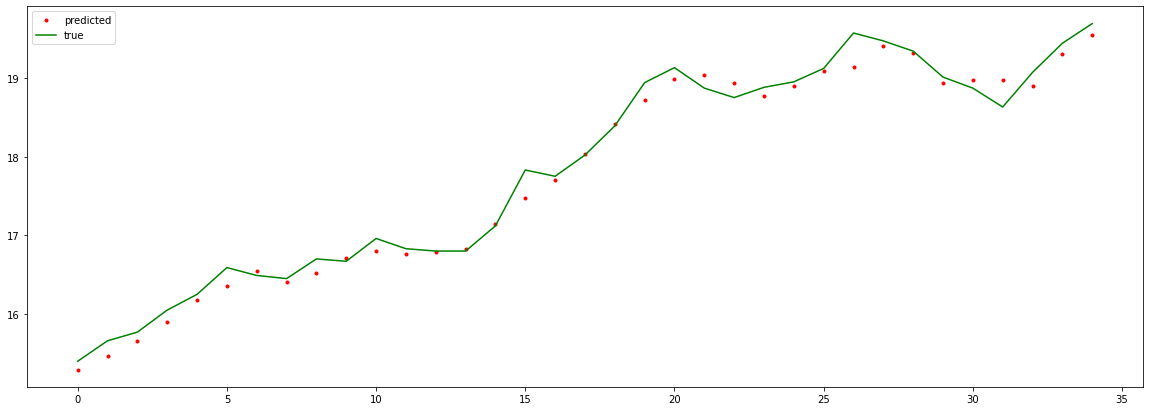

In [368]:
plt.plot(y_train_pred, '.r', label='predicted')
plt.plot(np.array(y_train), 'g', label='true')
plt.legend();

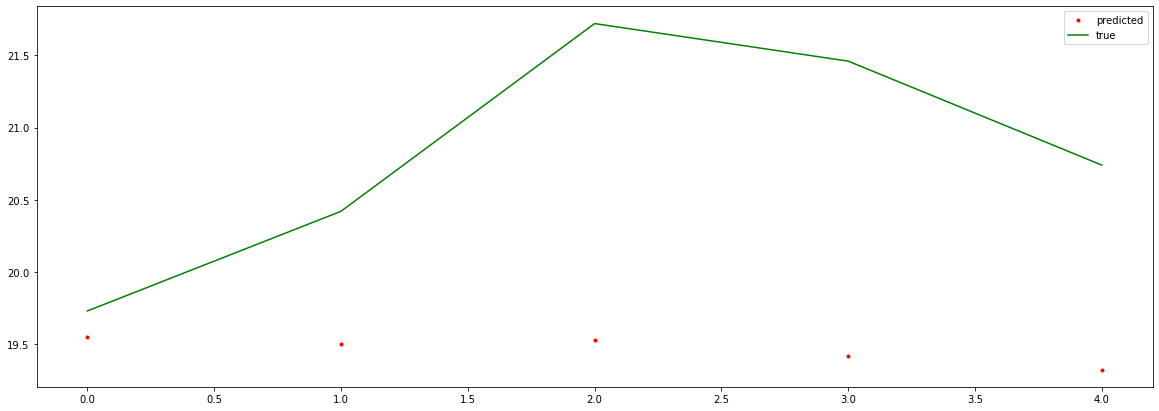

In [369]:
plt.plot(y_test_pred, '.r', label='predicted')
plt.plot(y_test, 'g', label='true')
plt.legend();

In [370]:
y_test_pred = model.predict(X_test)
test_mse, test_mae = model.evaluate(X_test, y_test, verbose=2)


print 
(f'test_mse: {round(test_mse, 2)}, test_mae: {round(test_mae,2)}')

1/1 [==============================] - 0s 13ms/step
1/1 - 0s - loss: 2.3729 - mae: 1.3500 - 14ms/epoch - 14ms/step


'test_mse: 2.37, test_mae: 1.35'

В результате применения 4-х разных моделей к прогнозированию медианной заработной платы женщин в условиях ограниченного набора данных (всего 50 экземпляров) мы получили следующие результаты работы моделей:
XGboost mse_test 2.754596856556042, mae_test 1.4506931915283203,
полносвязная нейронная сеть test_mse 1.63, test_mae: 1.12,
lstm test_mse: 2.85, test_mae: 1.53,
gru test_mse: 2.37, test_mae: 1.35.
Вывод: нейронные сети справляются с анализом и предсказаниями временных рядов не хуже, чем бустинги (даже после применения gridsearch для подбора гиперпараметров). Но у них есть существенный недостаток - они долго обучаются и требуют больших вычислительных ресурсов. Можно рассмотреть для оптимизации решения данной задачи другие типы бустингов или использовать полносвязную нейронную сеть.